Free to try everything in this code.

In [ ]:
###GCN+MOE+
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.metrics import mean_squared_error

# Generate station locations
np.random.seed(42)
num_stations = 10
station_coords = np.random.rand(num_stations, 2)

# Temperature data for one year (one data point per hour, 24 hours * 365 days)
time_steps = 24 * 365
temperature_data = np.random.rand(num_stations, time_steps) * 30  # Temperature range 0 to 30 degrees

# Min-Max normalization for each station's temperature series
min_temp = np.min(temperature_data, axis=1).reshape(-1, 1)
max_temp = np.max(temperature_data, axis=1).reshape(-1, 1)
temperature_data_normalized = (temperature_data - min_temp) / (max_temp - min_temp)

# Generate interpolation point location and true temperature values
interpolation_point = np.random.rand(1, 2)
true_interpolation_temp = np.random.rand(time_steps) * 30  # Assume true temperature range is also 0 to 30 degrees

# Normalize true_interpolation_temp
true_min_temp = np.min(true_interpolation_temp)
true_max_temp = np.max(true_interpolation_temp)
true_interpolation_temp_normalized = (true_interpolation_temp - true_min_temp) / (true_max_temp - true_min_temp)

# Define two subgraphs
subgraph_1 = [0, 1, 2, 3, 4]
subgraph_2 = [5, 6, 7, 8, 9]


# Inverse Distance Weighting (IDW) interpolation
def idw_interpolation(station_coords, temperatures, target_point, power=2):
    distances = np.linalg.norm(station_coords - target_point, axis=1)
    weights = 1 / (distances ** power)
    weights /= weights.sum()
    interpolated_value = np.dot(weights, temperatures)
    return interpolated_value


# Apply IDW interpolation to the two subgraphs
idw_estimate_1 = np.array(
    [idw_interpolation(station_coords[subgraph_1], temperature_data_normalized[subgraph_1, t], interpolation_point) for
     t in range(time_steps)])
idw_estimate_2 = np.array(
    [idw_interpolation(station_coords[subgraph_2], temperature_data_normalized[subgraph_2, t], interpolation_point) for
     t in range(time_steps)])


# Define GCN model
class GCNModel(nn.Module):
    def __init__(self, num_features, hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index, adj):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x


def calculate_inverse_distance_adj(station_coords, decay):
    num_nodes = station_coords.shape[0]
    adj = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                distance = np.linalg.norm(station_coords[i] - station_coords[j])
                adj[i, j] = np.exp(-decay * distance)
    return torch.tensor(adj, dtype=torch.float)


def prepare_data(subgraph, temperature_data, idw_estimate, decay):
    edge_index = torch.tensor([[i, j] for i in range(len(subgraph)) for j in range(len(subgraph))],
                              dtype=torch.long).t().contiguous()
    adj = calculate_inverse_distance_adj(station_coords[subgraph], decay)
    x = torch.tensor(temperature_data[subgraph], dtype=torch.float).t()
    y = torch.tensor(idw_estimate, dtype=torch.float).t()
    data = Data(x=x, edge_index=edge_index, y=y, adj=adj)
    return data


# Initialize models
def initialize_models(hidden_dim):
    model_1 = GCNModel(num_features=len(subgraph_1), hidden_dim=hidden_dim, output_dim=1)
    model_2 = GCNModel(num_features=len(subgraph_2), hidden_dim=hidden_dim, output_dim=1)
    return model_1, model_2


# Define MoE model
class MoEModel(nn.Module):
    def __init__(self, gcn1, gcn2, hidden_dim):
        super(MoEModel, self).__init__()
        self.gcn1 = gcn1
        self.gcn2 = gcn2
        self.gate = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x1, edge_index1, adj1, x2, edge_index2, adj2):
        out1 = self.gcn1(x1, edge_index1, adj1).view(-1, 1)
        out2 = self.gcn2(x2, edge_index2, adj2).view(-1, 1)
        gate_input = torch.cat([out1, out2], dim=1)
        gate_output = self.gate(gate_input)
        out = gate_output[:, 0].unsqueeze(1) * out1 + gate_output[:, 1].unsqueeze(1) * out2
        return out


# Train MoE model
def train_model(moe_model, data_1, data_2, optimizer, criterion, num_epochs=200):
    for epoch in range(num_epochs):
        moe_model.train()
        optimizer.zero_grad()

        out = moe_model(data_1.x, data_1.edge_index, data_1.adj, data_2.x, data_2.edge_index, data_2.adj)

        loss_1 = criterion(out.squeeze(), data_1.y)
        loss_2 = criterion(out.squeeze(), data_2.y)

        total_loss = loss_1 + loss_2
        total_loss.backward()

        optimizer.step()

        if (epoch + 1) % 20 == 0:
            print(
                f'Epoch {epoch + 1}/{num_epochs}, Loss_1: {loss_1.item()}, Loss_2: {loss_2.item()}, Total Loss: {total_loss.item()}')


# Predict temperature for the interpolation point
def predict(moe_model, data_1, data_2):
    moe_model.eval()
    with torch.no_grad():
        predicted_temp = moe_model(data_1.x, data_1.edge_index, data_1.adj, data_2.x, data_2.edge_index, data_2.adj)
    return predicted_temp.squeeze().numpy()


# Define loss function and optimizer
criterion = nn.MSELoss()


# MCMC for evaluating decay coefficients
def mcmc_decay_selection(decay_coefficients, num_samples=100):
    samples = []
    current_decay = np.random.choice(decay_coefficients)
    current_mse = evaluate_decay(current_decay)
    samples.append((current_decay, current_mse))

    for _ in range(num_samples):
        proposed_decay = np.random.choice(decay_coefficients)
        proposed_mse = evaluate_decay(proposed_decay)

        acceptance_prob = min(1, np.exp(current_mse - proposed_mse))
        if np.random.rand() < acceptance_prob:
            current_decay = proposed_decay
            current_mse = proposed_mse

        samples.append((current_decay, current_mse))

    return samples


def evaluate_decay(decay):
    hidden_dim = 16  # Define hidden_dim here
    data_1 = prepare_data(subgraph_1, temperature_data_normalized, idw_estimate_1, decay)
    data_2 = prepare_data(subgraph_2, temperature_data_normalized, idw_estimate_2, decay)
    model_1, model_2 = initialize_models(hidden_dim)
    moe_model = MoEModel(model_1, model_2, hidden_dim)
    optimizer = optim.Adam(moe_model.parameters(), lr=0.01)

    train_model(moe_model, data_1, data_2, optimizer, criterion)
    predicted_temp_normalized = predict(moe_model, data_1, data_2)
    mse = mean_squared_error(true_interpolation_temp_normalized, predicted_temp_normalized)

    return mse


# Evaluate different decay coefficients using MCMC
decay_coefficients = np.arange(0, 1.6, 0.1)
samples = mcmc_decay_selection(decay_coefficients)
best_sample = min(samples, key=lambda x: x[1])
best_decay = best_sample[0]
best_mse = best_sample[1]

print(f'Best decay coefficient: {best_decay}, MSE: {best_mse}')


In [1]:
import os

import numpy as np
import six.moves.cPickle as pickle
import torch
import torch.nn as nn
import torch.utils.data as data

import os
import pandas as pd
import torch

In [2]:
import numpy as np
from sklearn.metrics.pairwise import haversine_distances
from math import radians

def inverse_distance_weighting(lat, lon, power=2):
    num_points = len(lat)
    adjacency_matrix = np.zeros((num_points, num_points))

    # Convert latitude and longitude to radians
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    coords_rad = np.column_stack((lat_rad, lon_rad))

    for i in range(num_points):
        for j in range(i + 1, num_points):
            # Compute Haversine distance between points i and j
            distance = haversine_distances(coords_rad[[i]], coords_rad[[j]])[0, 0]

            # Apply inverse distance weighting formula
            if distance != 0:
                weight = 1 / distance ** power
                adjacency_matrix[i, j] = weight
                adjacency_matrix[j, i] = weight  # Adjacency matrix is symmetric

    return adjacency_matrix

# Example usage
a = [3, 2, 3, 4]
b = [4, 3, 1, 4]
adjacency_matrix = inverse_distance_weighting(a, b)
print("Adjacency matrix based on inverse distance weighting:")
print(adjacency_matrix)


Adjacency matrix based on inverse distance weighting:
[[   0.         1642.98716316  365.7583206  3282.80635001]
 [1642.98716316    0.          657.57568615  656.93456909]
 [ 365.7583206   657.57568615    0.          329.39333003]
 [3282.80635001  656.93456909  329.39333003    0.        ]]


In [4]:
# Example usage
from data_loader import *
import argparse
import sys

flags = parse_args(sys.argv[1:])
dataset=flags.dataset

folder_path = "data"+dataset
shenzhen_dataset = ShenzhenDataset(folder_path+"/Value")
dataset_tensor = shenzhen_dataset.read_csv_files()
dataset_tensor = np.transpose(dataset_tensor, (1, 0, 2))
print("dataset_tensor.shape",dataset_tensor.shape)#Three dimensions: Timesteps*stations*features
Latitude=pd.read_csv(folder_path+"/Station info.csv")['Lat']
print("Latitude",np.array(Latitude))
num_points = len(Latitude)
print("num_points",num_points)
# a=[2,3,2,3]
# b=[4,3,2,1]
# try_tensor=ShenzhenDataset.inverse_distance_weighting(a,b)
# print("try_tensor:",try_tensor)
adj_tensor=ShenzhenDataset.inverse_distance_weighting(np.array(pd.read_csv(folder_path+"/Station info.csv")['Lat']),np.array(pd.read_csv(folder_path+"/Station info.csv")['Long']))
print("Shape of the dataset tensor:", dataset_tensor.shape)
print("Shape of the adj_tensor:", adj_tensor.shape)

usage: ipykernel_launcher.py [-h] [--dataset DATASET]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/xren451/.local/share/jupyter/runtime/kernel-23ffa7d7-5631-404c-9f7a-9e38faa20a95.json


SystemExit: 2

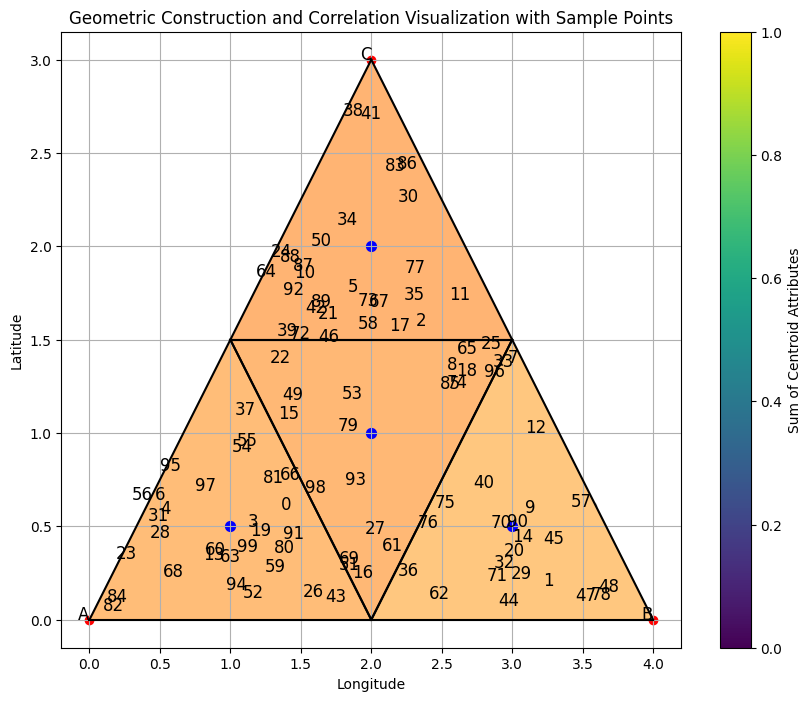

Point 0: [1.43304806 0.59019707], Correlations: [0.76463657 0.8        0.62404467]
Point 1: [3.29472024 0.18520251], Correlations: [0.8        0.93370833 0.71833079]
Point 2: [2.38992213 1.57893163], Correlations: [0.6        0.76381624 0.84566448]
Point 3: [1.20142458 0.50261061], Correlations: [0.81679073 0.8        0.63114495]
Point 4: [0.57818009 0.56984147], Correlations: [0.9063928  0.8        0.67534373]
Point 5: [1.90533949 1.75983513], Correlations: [0.62077525 0.7        0.8181489 ]
Point 6: [0.53835641 0.64479671], Correlations: [0.90457821 0.8        0.68511823]
Point 7: [3.03934973 1.37804265], Correlations: [0.8        0.84898816 0.82682344]
Point 8: [2.61338502 1.34339333], Correlations: [0.6        0.80289103 0.81964793]
Point 9: [3.16721956 0.57431509], Correlations: [0.8        0.90571722 0.74911334]
Point 10: [1.60515122 1.83541623], Correlations: [0.67675774 0.7        0.83697973]
Point 11: [2.70240607 1.71517178], Correlations: [0.6        0.79841807 0.86275466]
Po

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Define coordinates for points A, B, C
A = np.array([0, 0])
B = np.array([4, 0])
C = np.array([2, 3])

# Calculate distance between two points
def distance(p1, p2):
    return np.linalg.norm(p1 - p2)

# Calculate midpoint between two points
def midpoint(p1, p2):
    return (p1 + p2) / 2

# Recursively subdivide triangle
def subdivide_triangle(A, B, C, min_length):
    triangles = []
    stack = [(A, B, C)]
    while stack:
        A, B, C = stack.pop()
        AB, BC, CA = distance(A, B), distance(B, C), distance(C, A)
        if AB < min_length and BC < min_length and CA < min_length:
            triangles.append((A, B, C))
            continue
        mid_AB, mid_BC, mid_CA = midpoint(A, B), midpoint(B, C), midpoint(C, A)
        stack.extend([(A, mid_AB, mid_CA), (mid_AB, B, mid_BC), (mid_CA, mid_BC, C), (mid_AB, mid_BC, mid_CA)])
    return triangles

# Uniformly sample points in triangle
def sample_points_in_triangle(A, B, C, N):
    points = []
    for _ in range(N):
        r1, r2 = np.random.rand(), np.random.rand()
        sqrt_r1 = np.sqrt(r1)
        point = (1 - sqrt_r1) * A + (sqrt_r1 * (1 - r2)) * B + (sqrt_r1 * r2) * C
        points.append(point)
    return np.array(points)

# Correlation function
def correlation(distance, start_value, end_value, max_distance, lambda_param=1.0):
    normalized_distance = (distance / max_distance) ** lambda_param
    return start_value - (start_value - end_value) * normalized_distance

# Calculate correlations for sampled points
def calculate_correlations(points, A, B, C):
    lambda_param = 1.0
    correlations = []
    for point in points:
        dist_to_A, dist_to_B, dist_to_C = np.linalg.norm(point - A), np.linalg.norm(point - B), np.linalg.norm(point - C)
        max_dist = max(dist_to_A, dist_to_B, dist_to_C)
        corr_A = correlation(dist_to_A, 1, 0.8 if dist_to_B < dist_to_C else 0.6, max_dist, lambda_param)
        corr_B = correlation(dist_to_B, 1, 0.8 if dist_to_A < dist_to_C else 0.7, max_dist, lambda_param)
        corr_C = correlation(dist_to_C, 1, 0.7 if dist_to_B < dist_to_A else 0.6, max_dist, lambda_param)
        correlations.append([corr_A, corr_B, corr_C])
    return np.array(correlations)

# Check if point is inside triangle
def is_point_inside_triangle(point, triangle):
    A, B, C = triangle
    sign_1 = np.cross(B - A, point - A) < 0.0
    sign_2 = np.cross(C - B, point - B) < 0.0
    sign_3 = np.cross(A - C, point - C) < 0.0
    return (sign_1 == sign_2) and (sign_2 == sign_3)

# Determine points inside each triangle
def determine_points_in_triangles(triangles, sampled_points):
    points_in_triangles = []
    for triangle in triangles:
        points_in_triangles.append([point for point in sampled_points if is_point_inside_triangle(point, triangle)])
    return points_in_triangles

# Calculate average properties for each triangle
def calculate_average_properties_in_triangles(points_in_triangles, correlations):
    avg_properties = []
    for points in points_in_triangles:
        if len(points) == 0:
            avg_properties.append([0, 0, 0])
        else:
            avg_properties.append(np.mean([correlations[np.where((sampled_points == point).all(axis=1))[0][0]] for point in points], axis=0))
    return np.array(avg_properties)

# Plot triangle centroids
def plot_triangle_centroids(triangles, avg_properties):
    centroid_sums = np.sum(avg_properties, axis=1)
    for i, triangle in enumerate(triangles):
        polygon = Polygon(triangle, closed=True, facecolor=plt.cm.copper(centroid_sums[i] / np.max(centroid_sums)))
        plt.gca().add_patch(polygon)
        centroid = np.mean(triangle, axis=0)
        plt.scatter(centroid[0], centroid[1], c='blue', marker='o', s=50)

# Generate initial triangle and subdivide
triangles = subdivide_triangle(A, B, C, 3)

# Plot initial triangles
plt.figure(figsize=(10, 8))
for triangle in triangles:
    tA, tB, tC = triangle
    plt.plot([tA[0], tB[0]], [tA[1], tB[1]], 'k-')
    plt.plot([tB[0], tC[0]], [tB[1], tC[1]], 'k-')
    plt.plot([tC[0], tA[0]], [tC[1], tA[1]], 'k-')

# Mark points A, B, C
plt.scatter([A[0], B[0], C[0]], [A[1], B[1], C[1]], c='r')
plt.text(A[0], A[1], 'A', fontsize=12, ha='right')
plt.text(B[0], B[1], 'B', fontsize=12, ha='right')
plt.text(C[0], C[1], 'C', fontsize=12, ha='right')

# Sample points and calculate correlations
N = 100
sampled_points = sample_points_in_triangle(A, B, C, N)
correlations = calculate_correlations(sampled_points, A, B, C)

# Visualize sampled points
for i, point in enumerate(sampled_points):
    plt.scatter(point[0], point[1], c='gray', alpha=0.5)
    plt.text(point[0], point[1], str(i), fontsize=12, ha='right')

# Determine points in each triangle and calculate average properties
points_in_triangles = determine_points_in_triangles(triangles, sampled_points)
avg_properties = calculate_average_properties_in_triangles(points_in_triangles, correlations)

# Plot triangle centroids and fill based on average properties
plot_triangle_centroids(triangles, avg_properties)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geometric Construction and Correlation Visualization with Sample Points')
plt.grid(True)
plt.colorbar(label='Sum of Centroid Attributes')
plt.show()

# Print attributes for each sampled point
for i, point in enumerate(sampled_points):
    print(f"Point {i}: {point}, Correlations: {correlations[i]}")


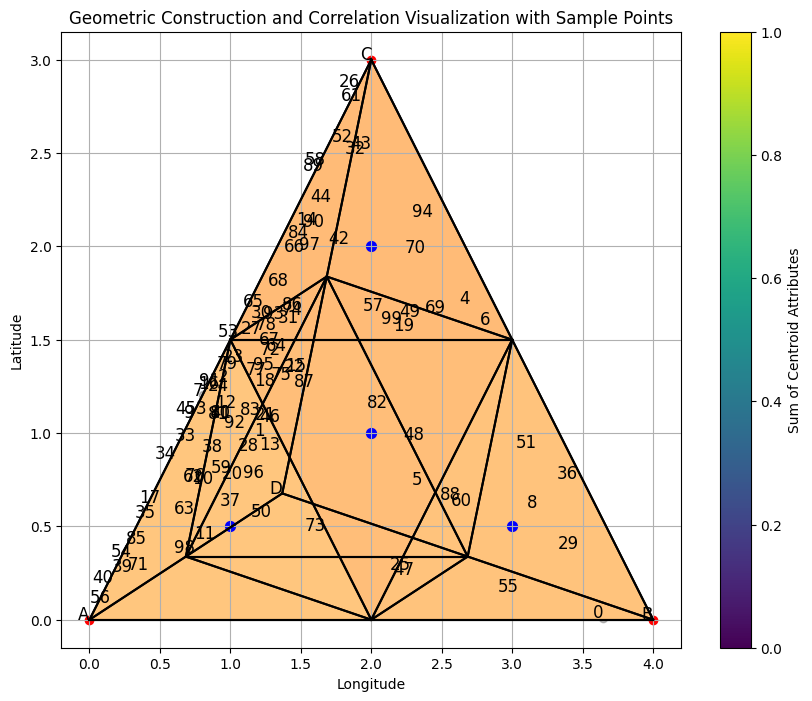

Point 0: [3.64587646 0.01176377], Correlations: [0.8        0.97084511 0.71928547 0.7722167 ]
Point 1: [1.24288076 0.9898636 ], Correlations: [0.78304371 0.8        0.70670105 0.97121775]
Point 2: [0.98801399 1.27812992], Correlations: [0.80250526 0.8        0.75583559 0.94563848]
Point 3: [0.82690586 1.10454959], Correlations: [0.83573244 0.8        0.73461881 0.94866389]
Point 4: [2.70210803 1.69314184], Correlations: [0.6        0.79929118 0.86042918 0.81592736]
Point 5: [2.36286168 0.72442701], Correlations: [0.8        0.78268481 0.72028345 0.85897218]
Point 6: [2.84654007 1.58410161], Correlations: [0.6        0.81954198 0.8480799  0.81363403]
Point 7: [0.80858842 1.20185637], Correlations: [0.83009376 0.8        0.74699181 0.94374325]
Point 8: [3.17583112 0.60218053], Correlations: [0.8        0.9052669  0.75214197 0.80410447]
Point 9: [0.74890384 1.08536323], Correlations: [0.84610721 0.8        0.73308058 0.94588307]
Point 10: [0.87814523 0.72785126], Correlations: [0.85767658

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Define coordinates for points A, B, C, and D
A = np.array([0, 0])
B = np.array([4, 0])
C = np.array([2, 3])
D = np.array([np.random.uniform(0, 4), np.random.uniform(0, 3)])

# Calculate distance between two points
def distance(p1, p2):
    return np.linalg.norm(p1 - p2)

# Calculate midpoint between two points
def midpoint(p1, p2):
    return (p1 + p2) / 2

# Recursively subdivide triangle
def subdivide_triangle(A, B, C, D, min_length):
    triangles = []
    stack = [(A, B, C), (A, B, D), (A, C, D), (B, C, D)]
    while stack:
        A, B, C = stack.pop()
        AB, BC, CA = distance(A, B), distance(B, C), distance(C, A)
        if AB < min_length and BC < min_length and CA < min_length:
            triangles.append((A, B, C))
            continue
        mid_AB, mid_BC, mid_CA = midpoint(A, B), midpoint(B, C), midpoint(C, A)
        stack.extend([(A, mid_AB, mid_CA), (mid_AB, B, mid_BC), (mid_CA, mid_BC, C), (mid_AB, mid_BC, mid_CA)])
    return triangles

# Uniformly sample points in quadrilateral
def sample_points_in_quadrilateral(A, B, C, D, N):
    points = []
    for _ in range(N):
        r1, r2 = np.random.rand(), np.random.rand()
        if r1 + r2 <= 1:
            point = r1 * A + r2 * B + (1 - r1 - r2) * C
        else:
            r1, r2 = 1 - r1, 1 - r2
            point = r1 * A + r2 * C + (1 - r1 - r2) * D
        points.append(point)
    return np.array(points)

# Correlation function
def correlation(distance, start_value, end_value, max_distance, lambda_param=1.0):
    normalized_distance = (distance / max_distance) ** lambda_param
    return start_value - (start_value - end_value) * normalized_distance

# Calculate correlations for sampled points
def calculate_correlations(points, A, B, C, D):
    lambda_param = 1.0
    correlations = []
    for point in points:
        dist_to_A, dist_to_B, dist_to_C, dist_to_D = (np.linalg.norm(point - A), np.linalg.norm(point - B), 
                                                      np.linalg.norm(point - C), np.linalg.norm(point - D))
        max_dist = max(dist_to_A, dist_to_B, dist_to_C, dist_to_D)
        corr_A = correlation(dist_to_A, 1, 0.8 if dist_to_B < dist_to_C else 0.6, max_dist, lambda_param)
        corr_B = correlation(dist_to_B, 1, 0.8 if dist_to_A < dist_to_C else 0.7, max_dist, lambda_param)
        corr_C = correlation(dist_to_C, 1, 0.7 if dist_to_B < dist_to_A else 0.6, max_dist, lambda_param)
        corr_D = correlation(dist_to_D, 1, 0.75 if dist_to_A < dist_to_B else 0.65, max_dist, lambda_param)
        correlations.append([corr_A, corr_B, corr_C, corr_D])
    return np.array(correlations)

# Check if point is inside triangle
def is_point_inside_triangle(point, triangle):
    A, B, C = triangle
    sign_1 = np.cross(B - A, point - A) < 0.0
    sign_2 = np.cross(C - B, point - B) < 0.0
    sign_3 = np.cross(A - C, point - C) < 0.0
    return (sign_1 == sign_2) and (sign_2 == sign_3)

# Determine points inside each triangle
def determine_points_in_triangles(triangles, sampled_points):
    points_in_triangles = []
    for triangle in triangles:
        points_in_triangles.append([point for point in sampled_points if is_point_inside_triangle(point, triangle)])
    return points_in_triangles

# Calculate average properties for each triangle
def calculate_average_properties_in_triangles(points_in_triangles, correlations):
    avg_properties = []
    for points in points_in_triangles:
        if len(points) == 0:
            avg_properties.append([0, 0, 0, 0])
        else:
            avg_properties.append(np.mean([correlations[np.where((sampled_points == point).all(axis=1))[0][0]] for point in points], axis=0))
    return np.array(avg_properties)

# Plot triangle centroids
def plot_triangle_centroids(triangles, avg_properties):
    centroid_sums = np.sum(avg_properties, axis=1)
    for i, triangle in enumerate(triangles):
        polygon = Polygon(triangle, closed=True, facecolor=plt.cm.copper(centroid_sums[i] / np.max(centroid_sums)))
        plt.gca().add_patch(polygon)
        centroid = np.mean(triangle, axis=0)
        plt.scatter(centroid[0], centroid[1], c='blue', marker='o', s=50)

# Generate initial triangles and subdivide
triangles = subdivide_triangle(A, B, C, D, 3)

# Plot initial triangles
plt.figure(figsize=(10, 8))
for triangle in triangles:
    tA, tB, tC = triangle
    plt.plot([tA[0], tB[0]], [tA[1], tB[1]], 'k-')
    plt.plot([tB[0], tC[0]], [tB[1], tC[1]], 'k-')
    plt.plot([tC[0], tA[0]], [tC[1], tA[1]], 'k-')

# Mark points A, B, C, D
plt.scatter([A[0], B[0], C[0], D[0]], [A[1], B[1], C[1], D[1]], c='r')
plt.text(A[0], A[1], 'A', fontsize=12, ha='right')
plt.text(B[0], B[1], 'B', fontsize=12, ha='right')
plt.text(C[0], C[1], 'C', fontsize=12, ha='right')
plt.text(D[0], D[1], 'D', fontsize=12, ha='right')

# Sample points and calculate correlations
N = 100
sampled_points = sample_points_in_quadrilateral(A, B, C, D, N)
correlations = calculate_correlations(sampled_points, A, B, C, D)

# Visualize sampled points
for i, point in enumerate(sampled_points):
    plt.scatter(point[0], point[1], c='gray', alpha=0.5)
    plt.text(point[0], point[1], str(i), fontsize=12, ha='right')

# Determine points in each triangle and calculate average properties
points_in_triangles = determine_points_in_triangles(triangles, sampled_points)
avg_properties = calculate_average_properties_in_triangles(points_in_triangles, correlations)

# Plot triangle centroids and fill based on average properties
plot_triangle_centroids(triangles, avg_properties)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geometric Construction and Correlation Visualization with Sample Points')
plt.grid(True)
plt.colorbar(label='Sum of Centroid Attributes')
plt.show()

# Print attributes for each sampled point
for i, point in enumerate(sampled_points):
    print(f"Point {i}: {point}, Correlations: {correlations[i]}")


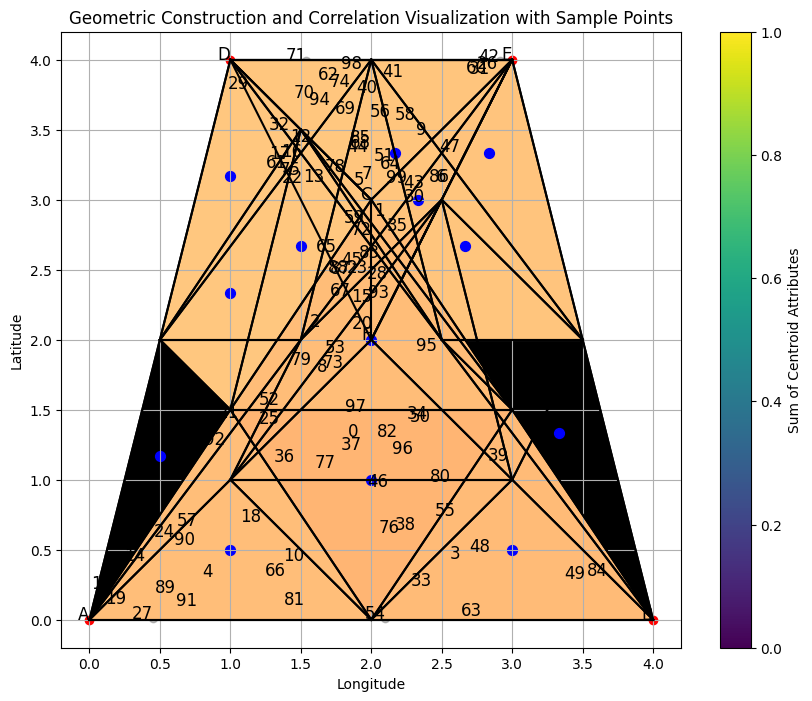

Point 0: [1.90608537 1.30624088], Correlations: [0.68209146 0.74534553 0.76661491 0.75561824 0.65       0.93980134]
Point 1: [2.09325498 2.88679325], Correlations: [0.6        0.70893392 0.9876604  0.84685457 0.89933937 0.91247837]
Point 2: [1.64029698 2.09564065], Correlations: [0.66269794 0.7        0.87664263 0.84084573 0.74049401 0.97051578]
Point 3: [2.6335157 0.4412031], Correlations: [0.8636179  0.88998805 0.79804422 0.65       0.68022642 0.84960507]
Point 4: [0.87299475 0.30728038], Correlations: [0.91312952 0.85253684 0.72600644 0.78323898 0.65       0.88070039]
Point 5: [1.95350803 3.10838735], Correlations: [0.60540739 0.7        0.98732392 0.91230679 0.90764583 0.92547787]
Point 6: [2.53137049 3.13212315], Correlations: [0.6        0.74229903 0.95921072 0.84702125 0.93877088 0.89130857]
Point 7: [2.00844938 3.15218373], Correlations: [0.6        0.70072666 0.98776631 0.87662903 0.91274002 0.89210503]
Point 8: [1.6853993  1.77365001], Correlations: [0.66437711 0.7        0.8

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Define coordinates for points A, B, C, D, E, F
A = np.array([0, 0])
B = np.array([4, 0])
C = np.array([2, 3])
D = np.array([1, 4])
E = np.array([3, 4])
F = np.array([2, 2])

# Calculate distance between two points
def distance(p1, p2):
    return np.linalg.norm(p1 - p2)

# Calculate midpoint between two points
def midpoint(p1, p2):
    return (p1 + p2) / 2

# Recursively subdivide hexagon into triangles
def subdivide_hexagon(A, B, C, D, E, F, min_length):
    triangles = []
    stack = [(A, B, C), (A, C, D), (A, D, E), (A, E, F), (A, F, B), (B, C, D), (B, D, E), (B, E, F), (C, D, E), (C, E, F), (D, E, F)]
    while stack:
        A, B, C = stack.pop()
        AB, BC, CA = distance(A, B), distance(B, C), distance(C, A)
        if AB < min_length and BC < min_length and CA < min_length:
            triangles.append((A, B, C))
            continue
        mid_AB, mid_BC, mid_CA = midpoint(A, B), midpoint(B, C), midpoint(C, A)
        stack.extend([(A, mid_AB, mid_CA), (mid_AB, B, mid_BC), (mid_CA, mid_BC, C), (mid_AB, mid_BC, mid_CA)])
    return triangles

# Uniformly sample points in hexagon
def sample_points_in_hexagon(A, B, C, D, E, F, N):
    points = []
    for _ in range(N):
        r1, r2 = np.random.rand(), np.random.rand()
        if r1 + r2 <= 1:
            if r1 + r2 <= 0.5:
                point = r1 * A + r2 * B + (1 - r1 - r2) * C
            else:
                point = r1 * D + r2 * E + (1 - r1 - r2) * F
        else:
            r1, r2 = 1 - r1, 1 - r2
            if r1 + r2 <= 0.5:
                point = r1 * D + r2 * E + (1 - r1 - r2) * F
            else:
                point = r1 * A + r2 * B + (1 - r1 - r2) * C
        points.append(point)
    return np.array(points)

# Correlation function
def correlation(distance, start_value, end_value, max_distance, lambda_param=1.0):
    normalized_distance = (distance / max_distance) ** lambda_param
    return start_value - (start_value - end_value) * normalized_distance

# Calculate correlations for sampled points
def calculate_correlations(points, A, B, C, D, E, F):
    lambda_param = 1.0
    correlations = []
    for point in points:
        dist_to_A, dist_to_B, dist_to_C, dist_to_D, dist_to_E, dist_to_F = (np.linalg.norm(point - A), np.linalg.norm(point - B), 
                                                                           np.linalg.norm(point - C), np.linalg.norm(point - D), 
                                                                           np.linalg.norm(point - E), np.linalg.norm(point - F))
        max_dist = max(dist_to_A, dist_to_B, dist_to_C, dist_to_D, dist_to_E, dist_to_F)
        corr_A = correlation(dist_to_A, 1, 0.8 if dist_to_B < dist_to_C else 0.6, max_dist, lambda_param)
        corr_B = correlation(dist_to_B, 1, 0.8 if dist_to_A < dist_to_C else 0.7, max_dist, lambda_param)
        corr_C = correlation(dist_to_C, 1, 0.7 if dist_to_B < dist_to_A else 0.6, max_dist, lambda_param)
        corr_D = correlation(dist_to_D, 1, 0.75 if dist_to_A < dist_to_B else 0.65, max_dist, lambda_param)
        corr_E = correlation(dist_to_E, 1, 0.75 if dist_to_C < dist_to_F else 0.65, max_dist, lambda_param)
        corr_F = correlation(dist_to_F, 1, 0.75 if dist_to_D < dist_to_E else 0.65, max_dist, lambda_param)
        correlations.append([corr_A, corr_B, corr_C, corr_D, corr_E, corr_F])
    return np.array(correlations)

# Check if point is inside triangle
def is_point_inside_triangle(point, triangle):
    A, B, C = triangle
    sign_1 = np.cross(B - A, point - A) < 0.0
    sign_2 = np.cross(C - B, point - B) < 0.0
    sign_3 = np.cross(A - C, point - C) < 0.0
    return (sign_1 == sign_2) and (sign_2 == sign_3)

# Determine points inside each triangle
def determine_points_in_triangles(triangles, sampled_points):
    points_in_triangles = []
    for triangle in triangles:
        points_in_triangles.append([point for point in sampled_points if is_point_inside_triangle(point, triangle)])
    return points_in_triangles

# Calculate average properties for each triangle
def calculate_average_properties_in_triangles(points_in_triangles, correlations):
    avg_properties = []
    for points in points_in_triangles:
        if len(points) == 0:
            avg_properties.append([0, 0, 0, 0, 0, 0])
        else:
            avg_properties.append(np.mean([correlations[np.where((sampled_points == point).all(axis=1))[0][0]] for point in points], axis=0))
    return np.array(avg_properties)

# Plot triangle centroids
def plot_triangle_centroids(triangles, avg_properties):
    centroid_sums = np.sum(avg_properties, axis=1)
    for i, triangle in enumerate(triangles):
        polygon = Polygon(triangle, closed=True, facecolor=plt.cm.copper(centroid_sums[i] / np.max(centroid_sums)))
        plt.gca().add_patch(polygon)
        centroid = np.mean(triangle, axis=0)
        plt.scatter(centroid[0], centroid[1], c='blue', marker='o', s=50)

# Generate initial triangles and subdivide
triangles = subdivide_hexagon(A, B, C, D, E, F, 3)

# Plot initial triangles
plt.figure(figsize=(10, 8))
for triangle in triangles:
    tA, tB, tC = triangle
    plt.plot([tA[0], tB[0]], [tA[1], tB[1]], 'k-')
    plt.plot([tB[0], tC[0]], [tB[1], tC[1]], 'k-')
    plt.plot([tC[0], tA[0]], [tC[1], tA[1]], 'k-')

# Mark points A, B, C, D, E, F
plt.scatter([A[0], B[0], C[0], D[0], E[0], F[0]], [A[1], B[1], C[1], D[1], E[1], F[1]], c='r')
plt.text(A[0], A[1], 'A', fontsize=12, ha='right')
plt.text(B[0], B[1], 'B', fontsize=12, ha='right')
plt.text(C[0], C[1], 'C', fontsize=12, ha='right')
plt.text(D[0], D[1], 'D', fontsize=12, ha='right')
plt.text(E[0], E[1], 'E', fontsize=12, ha='right')
plt.text(F[0], F[1], 'F', fontsize=12, ha='right')

# Sample points and calculate correlations
N = 100
sampled_points = sample_points_in_hexagon(A, B, C, D, E, F, N)
correlations = calculate_correlations(sampled_points, A, B, C, D, E, F)

# Visualize sampled points
for i, point in enumerate(sampled_points):
    plt.scatter(point[0], point[1], c='gray', alpha=0.5)
    plt.text(point[0], point[1], str(i), fontsize=12, ha='right')

# Determine points in each triangle and calculate average properties
points_in_triangles = determine_points_in_triangles(triangles, sampled_points)
avg_properties = calculate_average_properties_in_triangles(points_in_triangles, correlations)

# Plot triangle centroids and fill based on average properties
plot_triangle_centroids(triangles, avg_properties)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geometric Construction and Correlation Visualization with Sample Points')
plt.grid(True)
plt.colorbar(label='Sum of Centroid Attributes')
plt.show()

# Print attributes for each sampled point
for i, point in enumerate(sampled_points):
    print(f"Point {i}: {point}, Correlations: {correlations[i]}")


In [29]:
from shapely.geometry import Point, Polygon

# Define the coordinates of the three points
points = [(35.6895, 139.6917), (34.0522, -118.2437), (40.7128, -74.0060),(36.7128, -70.0060)]

# Create a polygon from the points
polygon = Polygon(points)

# Calculate the area of the polygon
area = polygon.area
print(f"The area of the polygon is: {area} square units")

# Define the point to check
check_point = Point(36.7783, -119.4179)

# Check if the point is inside the polygon
is_inside = polygon.contains(check_point)

if is_inside:
    print("The point is inside the area.")
else:
    print("The point is outside the area.")

The area of the polygon is: 405.43826951500023 square units
The point is outside the area.


The point is inside the polygon.
New adjacency matrix:
[[1.         0.8        0.6        0.20189652]
 [0.8        1.         0.5        0.00302755]
 [0.6        0.5        1.         0.082085  ]
 [0.20189652 0.00302755 0.082085   0.90483742]]


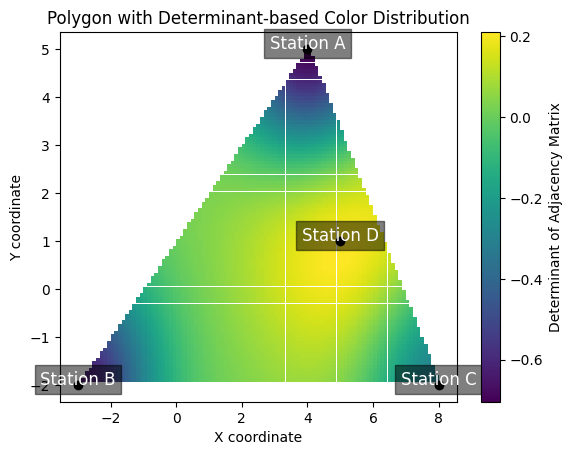

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point
import matplotlib.colors as mcolors

# Define the station coordinates
stations = np.array([
    [4, 5],   # A
    [-3, -2], # B
    [8, -2],  # C
    [5, 1]    # D
])

# Adjacency matrix
adjacency_matrix = np.array([
    [1, 0.8, 0.6, 0.3],
    [0.8, 1, 0.5, 0.6],
    [0.6, 0.5, 1, 0.5],
    [0.3, 0.6, 0.5, 1]
])

# Define the convex hull function
def convex_hull(points):
    if len(points) < 3:
        return points  # Convex hull is not defined for fewer than 3 points
    hull = ConvexHull(points)
    return hull.vertices

# Define the decay function (e.g., Gaussian decay)
def decay_function(distance, alpha=0.1):
    return np.exp(-alpha * distance**2)

# Compute the correlation between the patch and each station
def compute_correlation(x, y, stations, decay_function, alpha=0.1):
    distances = np.sqrt((x - stations[:, 0])**2 + (y - stations[:, 1])**2)
    correlations = decay_function(distances, alpha)
    return correlations

# Create the convex hull
hull_indices = convex_hull(stations)
hull_points = stations[hull_indices]

# Create the polygon
polygon = Polygon(hull_points)

# Function to check if a point is inside the polygon and compute the adjacency matrix
def check_point_and_compute_adj_matrix(point, polygon, stations, adjacency_matrix):
    if polygon.contains(point):
        x, y = point.x, point.y
        correlations = compute_correlation(x, y, stations, decay_function)
        new_adj_matrix = np.copy(adjacency_matrix)
        for k in range(len(stations)):
            new_adj_matrix[-1, k] = new_adj_matrix[k, -1] = correlations[k]
        return True, new_adj_matrix
    else:
        return False, None

# Test the function with an example point
test_point = Point(4, 1)
inside, new_adj_matrix = check_point_and_compute_adj_matrix(test_point, polygon, stations, adjacency_matrix)

if inside:
    print("The point is inside the polygon.")
    print("New adjacency matrix:")
    print(new_adj_matrix)
else:
    print("The point is outside the polygon.")

# Create a grid of points within the polygon
min_x, min_y, max_x, max_y = polygon.bounds
grid_x, grid_y = np.meshgrid(np.linspace(min_x, max_x, 100), np.linspace(min_y, max_y, 100))

# Compute the attributes of each grid point based on the new adjacency matrix
attributes = np.zeros(grid_x.shape)
for i in range(grid_x.shape[0]):
    for j in range(grid_x.shape[1]):
        point = Point(grid_x[i, j], grid_y[i, j])
        if polygon.contains(point):
            # Compute correlations between the patch and each station
            correlations = compute_correlation(grid_x[i, j], grid_y[i, j], stations, decay_function)
            
            # Construct the new adjacency matrix for this patch
            new_adj_matrix = np.copy(adjacency_matrix)
            for k in range(len(stations)):
                new_adj_matrix[-1, k] = new_adj_matrix[k, -1] = correlations[k]
            
            # Calculate the determinant of the new adjacency matrix
            determinant = np.linalg.det(new_adj_matrix)
            attributes[i, j] = determinant

# Plot the polygon and color the patches based on attributes
fig, ax = plt.subplots()

# Color the patches based on attributes
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=attributes.min(), vmax=attributes.max())

for i in range(grid_x.shape[0]):
    for j in range(grid_x.shape[1]):
        point = Point(grid_x[i, j], grid_y[i, j])
        if polygon.contains(point):
            color = cmap(norm(attributes[i, j]))
            ax.add_patch(plt.Rectangle((grid_x[i, j], grid_y[i, j]), (max_x - min_x) / 100, (max_y - min_y) / 100, color=color, ec='none'))

# Plot the stations
ax.plot(stations[:, 0], stations[:, 1], 'ko')

# Annotate the stations
for i, (x, y) in enumerate(stations):
    ax.text(x, y, f'Station {chr(65+i)}', fontsize=12, ha='center', color='white', bbox=dict(facecolor='black', alpha=0.5))

# Add colorbar for reference
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, orientation='vertical', label='Determinant of Adjacency Matrix')

plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Polygon with Determinant-based Color Distribution')
plt.show()


The point is inside the polygon.
New adjacency matrix:
[[1.         0.8        0.6        0.3        0.20189652]
 [0.8        1.         0.5        0.6        0.00302755]
 [0.6        0.5        1.         0.5        0.082085  ]
 [0.3        0.6        0.5        1.         0.90483742]
 [0.20189652 0.00302755 0.082085   0.90483742 0.00551656]]


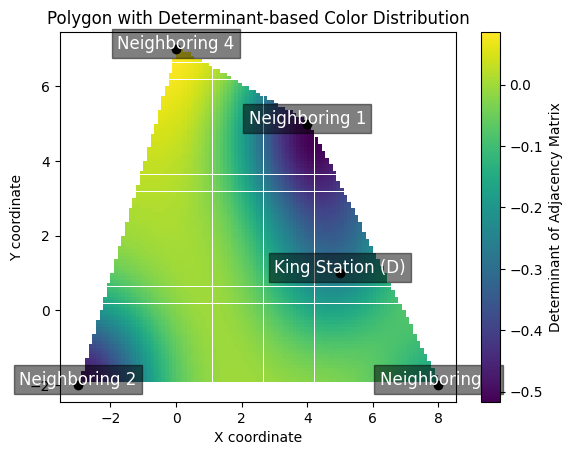

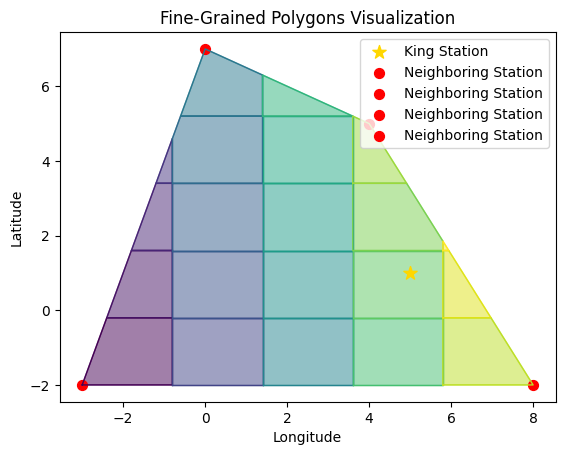

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point
import matplotlib.colors as mcolors

# Define the station coordinates
stations = np.array([
    [4, 5],   # Neighboring 1
    [-3, -2], # Neighboring 2
    [8, -2],  # Neighboring 3
    [5, 1],   # King Station (D)
    [0, 7]    # Neighboring 4
])

# Adjacency matrix
adjacency_matrix = np.array([
    [1, 0.8, 0.6, 0.3, 0.5],
    [0.8, 1, 0.5, 0.6, 0.4],
    [0.6, 0.5, 1, 0.5, 0.3],
    [0.3, 0.6, 0.5, 1, 0.7],
    [0.5, 0.4, 0.3, 0.7, 1]
])

# Define the convex hull function
def convex_hull(points):
    if len(points) < 3:
        return points  # Convex hull is not defined for fewer than 3 points
    hull = ConvexHull(points)
    return hull.vertices

# Define the decay function (e.g., Gaussian decay)
def decay_function(distance, alpha=0.1):
    return np.exp(-alpha * distance**2)

# Compute the correlation between the patch and each station
def compute_correlation(x, y, stations, decay_function, alpha=0.1):
    distances = np.sqrt((x - stations[:, 0])**2 + (y - stations[:, 1])**2)
    correlations = decay_function(distances, alpha)
    return correlations

# Create the convex hull
hull_indices = convex_hull(stations)
hull_points = stations[hull_indices]

# Create the polygon
polygon = Polygon(hull_points)

# Function to check if a point is inside the polygon and compute the adjacency matrix
def check_point_and_compute_adj_matrix(point, polygon, stations, adjacency_matrix):
    if polygon.contains(point):
        x, y = point.x, point.y
        correlations = compute_correlation(x, y, stations, decay_function)
        new_adj_matrix = np.copy(adjacency_matrix)
        for k in range(len(stations)):
            new_adj_matrix[-1, k] = new_adj_matrix[k, -1] = correlations[k]
        return True, new_adj_matrix
    else:
        return False, None

# Test the function with an example point
test_point = Point(4, 1)
inside, new_adj_matrix = check_point_and_compute_adj_matrix(test_point, polygon, stations, adjacency_matrix)

if inside:
    print("The point is inside the polygon.")
    print("New adjacency matrix:")
    print(new_adj_matrix)
else:
    print("The point is outside the polygon.")

# Create a grid of points within the polygon
min_x, min_y, max_x, max_y = polygon.bounds
grid_x, grid_y = np.meshgrid(np.linspace(min_x, max_x, 100), np.linspace(min_y, max_y, 100))

# Compute the attributes of each grid point based on the new adjacency matrix
attributes = np.zeros(grid_x.shape)
for i in range(grid_x.shape[0]):
    for j in range(grid_x.shape[1]):
        point = Point(grid_x[i, j], grid_y[i, j])
        if polygon.contains(point):
            # Compute correlations between the patch and each station
            correlations = compute_correlation(grid_x[i, j], grid_y[i, j], stations, decay_function)
            
            # Construct the new adjacency matrix for this patch
            new_adj_matrix = np.copy(adjacency_matrix)
            for k in range(len(stations)):
                new_adj_matrix[-1, k] = new_adj_matrix[k, -1] = correlations[k]
            
            # Calculate the determinant of the new adjacency matrix
            determinant = np.linalg.det(new_adj_matrix)
            attributes[i, j] = determinant

# Plot the polygon and color the patches based on attributes
fig, ax = plt.subplots()

# Color the patches based on attributes
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=attributes.min(), vmax=attributes.max())

for i in range(grid_x.shape[0]):
    for j in range(grid_x.shape[1]):
        point = Point(grid_x[i, j], grid_y[i, j])
        if polygon.contains(point):
            color = cmap(norm(attributes[i, j]))
            ax.add_patch(plt.Rectangle((grid_x[i, j], grid_y[i, j]), (max_x - min_x) / 100, (max_y - min_y) / 100, color=color, ec='none'))

# Plot the stations
ax.plot(stations[:, 0], stations[:, 1], 'ko')

# Annotate the stations
labels = ['Neighboring 1', 'Neighboring 2', 'Neighboring 3', 'King Station (D)', 'Neighboring 4']
for i, (x, y) in enumerate(stations):
    ax.text(x, y, labels[i], fontsize=12, ha='center', color='white', bbox=dict(facecolor='black', alpha=0.5))

# Add colorbar for reference
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, orientation='vertical', label='Determinant of Adjacency Matrix')

plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Polygon with Determinant-based Color Distribution')
plt.show()

# Subdivide the polygon into fine-grained polygons
def subdivide_polygon(polygon, num_subdivisions):
    minx, miny, maxx, maxy = polygon.bounds
    width = (maxx - minx) / num_subdivisions
    height = (maxy - miny) / num_subdivisions
    sub_polygons = []
    for i in range(num_subdivisions):
        for j in range(num_subdivisions):
            sub_poly = Polygon([
                (minx + i * width, miny + j * height),
                (minx + (i + 1) * width, miny + j * height),
                (minx + (i + 1) * width, miny + (j + 1) * height),
                (minx + i * width, miny + (j + 1) * height)
            ])
            if sub_poly.intersects(polygon):
                sub_polygons.append(sub_poly.intersection(polygon))
    return sub_polygons

# Generate the fine-grained polygons
num_subdivisions = 5
fine_polygons = subdivide_polygon(polygon, num_subdivisions)

# Plot the fine-grained polygons
def plot_fine_polygons(fine_polygons, king_station, neighboring_stations):
    fig, ax = plt.subplots()
    colors = plt.cm.viridis(np.linspace(0, 1, len(fine_polygons)))
    for poly, color in zip(fine_polygons, colors):
        if poly.is_valid:
            x, y = poly.exterior.xy
            ax.plot(x, y, color=color, lw=1)
            ax.fill(x, y, color=color, alpha=0.5)
    
    # Plot king station
    king_x, king_y = king_station
    ax.scatter(king_x, king_y, color='gold', marker='*', s=100, label='King Station')
    
    # Plot neighboring stations
    for station in neighboring_stations:
        neigh_x, neigh_y = station
        ax.scatter(neigh_x, neigh_y, color='red', marker='o', s=50, label='Neighboring Station')
    
    ax.set_title('Fine-Grained Polygons Visualization')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

# Plot the fine-grained polygons with king station and neighboring stations
plot_fine_polygons(fine_polygons, (5, 1), [(4, 5), (-3, -2), (8, -2), (0, 7)])


The point is outside the polygon.


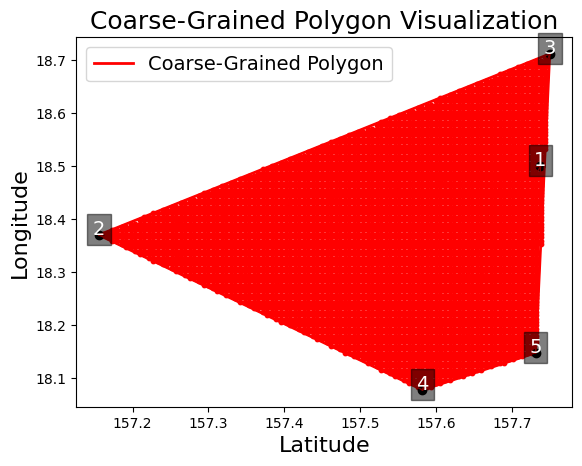

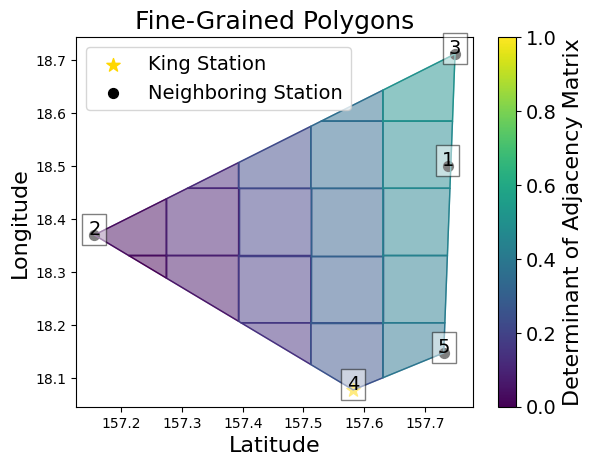

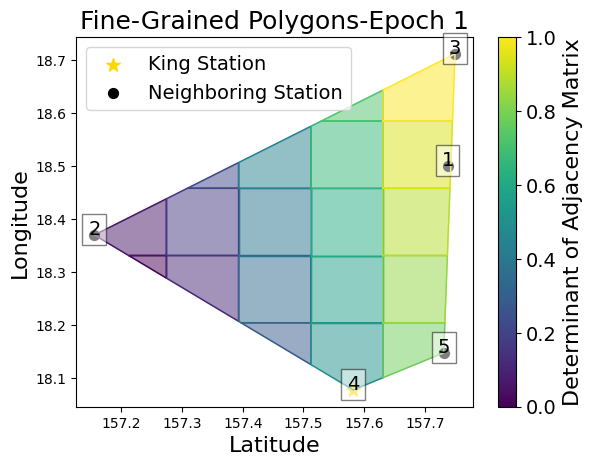

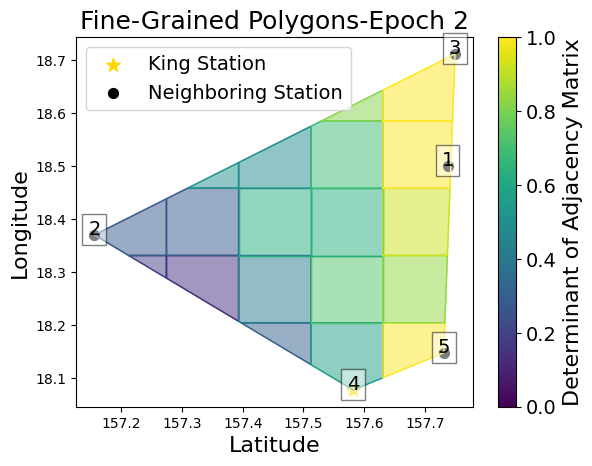

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point
import matplotlib.colors as mcolors

# Define the random ranges for latitude and longitude
lat_range = (156.5, 157.8)
long_range = (17.8, 19.8)

# Generate random station coordinates within the specified ranges
stations = np.column_stack((
    np.random.uniform(lat_range[0], lat_range[1], 5),  # Random latitudes
    np.random.uniform(long_range[0], long_range[1], 5)  # Random longitudes
))

# Adjacency matrix
adjacency_matrix = np.array([
    [1, 0.3, 0.2, 0.3, 0.2],
    [0.3, 1, 0.5, 0.6, 0.4],
    [0.2, 0.5, 1, 0.5, 0.3],
    [0.3, 0.6, 0.5, 1, 0.9],
    [0.2, 0.4, 0.3, 0.9, 1]
])

# Define the convex hull function
def convex_hull(points):
    if len(points) < 3:
        return points  # Convex hull is not defined for fewer than 3 points
    hull = ConvexHull(points)
    return hull.vertices

# Define the decay function (e.g., Gaussian decay)
def decay_function(distance, alpha=0.1):
    return np.exp(-alpha * distance**2)

# Compute the correlation between the patch and each station
def compute_correlation(x, y, stations, decay_function, alpha=0.1):
    distances = np.sqrt((x - stations[:, 0])**2 + (y - stations[:, 1])**2)
    correlations = decay_function(distances, alpha)
    return correlations

# Create the convex hull
hull_indices = convex_hull(stations)
hull_points = stations[hull_indices]

# Create the polygon
polygon = Polygon(hull_points)

# Function to check if a point is inside the polygon and compute the adjacency matrix
def check_point_and_compute_adj_matrix(point, polygon, stations, adjacency_matrix):
    if polygon.contains(point):
        x, y = point.x, point.y
        correlations = compute_correlation(x, y, stations, decay_function)
        new_adj_matrix = np.copy(adjacency_matrix)
        for k in range(len(stations)):
            new_adj_matrix[-1, k] = new_adj_matrix[k, -1] = correlations[k]
        return True, new_adj_matrix
    else:
        return False, None

# Test the function with an example point
test_point = Point(157.0, 18.0)
inside, new_adj_matrix = check_point_and_compute_adj_matrix(test_point, polygon, stations, adjacency_matrix)

if inside:
    print("The point is inside the polygon.")
    print("New adjacency matrix:")
    print(new_adj_matrix)
else:
    print("The point is outside the polygon.")

# Create a grid of points within the polygon
min_x, min_y, max_x, max_y = polygon.bounds
grid_x, grid_y = np.meshgrid(np.linspace(min_x, max_x, 100), np.linspace(min_y, max_y, 100))

# Compute the attributes of each grid point based on the new adjacency matrix
attributes = np.zeros(grid_x.shape)
for i in range(grid_x.shape[0]):
    for j in range(grid_x.shape[1]):
        point = Point(grid_x[i, j], grid_y[i, j])
        if polygon.contains(point):
            # Compute correlations between the patch and each station
            correlations = compute_correlation(grid_x[i, j], grid_y[i, j], stations, decay_function)
            
            # Construct the new adjacency matrix for this patch
            new_adj_matrix = np.copy(adjacency_matrix)
            for k in range(len(stations)):
                new_adj_matrix[-1, k] = new_adj_matrix[k, -1] = correlations[k]
            
            # Calculate the determinant of the new adjacency matrix
            determinant = np.linalg.det(new_adj_matrix)
            attributes[i, j] = determinant

# Plot the coarse-grained polygon and points inside it
fig, ax = plt.subplots()

# Plot the polygon
x, y = polygon.exterior.xy
ax.plot(x, y, 'r-', lw=2)

# Plot the points inside the polygon
for i in range(grid_x.shape[0]):
    for j in range(grid_x.shape[1]):
        point = Point(grid_x[i, j], grid_y[i, j])
        if polygon.contains(point):
            ax.scatter(grid_x[i, j], grid_y[i, j], color='red', s=10)

# Plot the stations
ax.plot(stations[:, 0], stations[:, 1], 'ko')

# Annotate the stations
for i, (x, y) in enumerate(stations):
    ax.text(x, y, str(i + 1), fontsize=14, ha='center', color='white', bbox=dict(facecolor='black', alpha=0.5))

# Draw red lines connecting the stations
for i in range(len(stations)):
    for j in range(i + 1, len(stations)):
        ax.plot([stations[i, 0], stations[j, 0]], [stations[i, 1], stations[j, 1]], 'r-', lw=1)

plt.xlabel('Latitude', fontsize=16)
plt.ylabel('Longitude', fontsize=16)
plt.title('Coarse-Grained Polygon Visualization', fontsize=18)
plt.legend(['Coarse-Grained Polygon'], fontsize=14)
plt.show()

# Subdivide the polygon into fine-grained polygons
def subdivide_polygon(polygon, num_subdivisions):
    minx, miny, maxx, maxy = polygon.bounds
    width = (maxx - minx) / num_subdivisions
    height = (maxy - miny) / num_subdivisions
    sub_polygons = []
    for i in range(num_subdivisions):
        for j in range(num_subdivisions):
            sub_poly = Polygon([
                (minx + i * width, miny + j * height),
                (minx + (i + 1) * width, miny + j * height),
                (minx + (i + 1) * width, miny + (j + 1) * height),
                (minx + i * width, miny + (j + 1) * height)
            ])
            if sub_poly.intersects(polygon):
                sub_polygons.append(sub_poly.intersection(polygon))
    return sub_polygons

# Generate the fine-grained polygons
num_subdivisions = 5
fine_polygons = subdivide_polygon(polygon, num_subdivisions)

# Function to plot fine-grained polygons with custom title and random color replacements
def plot_fine_polygons(fine_polygons, king_station, neighboring_stations, title, randomize_colors=False):
    fig, ax = plt.subplots()
    colors = plt.cm.viridis(np.linspace(0, 1, len(fine_polygons)))
    
    if randomize_colors:
        # Randomly replace some colors
        num_replacements = 10
        for _ in range(num_replacements):
            idx = np.random.randint(len(colors))
            colors[idx] = np.random.rand(3,)
    
    for poly, color in zip(fine_polygons, colors):
        if poly.is_valid:
            x, y = poly.exterior.xy
            ax.plot(x, y, color=color, lw=1)
            ax.fill(x, y, color=color, alpha=0.5)
    
    # Plot king station
    king_x, king_y = king_station
    ax.scatter(king_x, king_y, color='gold', marker='*', s=100, label='King Station')
    
    # Plot neighboring stations
    for station in neighboring_stations:
        neigh_x, neigh_y = station
        ax.scatter(neigh_x, neigh_y, color='black', marker='o', s=50, label='Neighboring Station')
    
    # Annotate the nodes
    for i, (x, y) in enumerate(stations):
        ax.text(x, y, str(i + 1), fontsize=14, ha='center', color='black', bbox=dict(facecolor='white', alpha=0.5))
    
    # Add colorbar for fine-grained polygons
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=mcolors.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='Determinant of Adjacency Matrix')
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('Determinant of Adjacency Matrix', fontsize=16)
    
    ax.set_title(title, fontsize=18)
    plt.xlabel('Latitude', fontsize=16)
    plt.ylabel('Longitude', fontsize=16)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize=14)
    plt.show()

def plot_fine_polygons_2(fine_polygons, king_station, neighboring_stations, title, randomize_colors=False):
    fig, ax = plt.subplots()
    colors = plt.cm.viridis(np.linspace(0, 1, len(fine_polygons))/2)
    
    if randomize_colors:
        # Randomly replace some colors
        num_replacements =10
        for _ in range(num_replacements):
            idx = np.random.randint(len(colors))
            colors[idx] = np.random.rand(3,)
    
    for poly, color in zip(fine_polygons, colors):
        if poly.is_valid:
            x, y = poly.exterior.xy
            ax.plot(x, y, color=color, lw=1)
            ax.fill(x, y, color=color, alpha=0.5)
    
    # Plot king station
    king_x, king_y = king_station
    ax.scatter(king_x, king_y, color='gold', marker='*', s=100, label='King Station')
    
    # Plot neighboring stations
    for station in neighboring_stations:
        neigh_x, neigh_y = station
        ax.scatter(neigh_x, neigh_y, color='black', marker='o', s=50, label='Neighboring Station')
    
    # Annotate the nodes
    for i, (x, y) in enumerate(stations):
        ax.text(x, y, str(i + 1), fontsize=14, ha='center', color='black', bbox=dict(facecolor='white', alpha=0.5))
    
    # Add colorbar for fine-grained polygons
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=mcolors.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='Determinant of Adjacency Matrix')
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('Determinant of Adjacency Matrix', fontsize=16)
    
    ax.set_title(title, fontsize=18)
    plt.xlabel('Latitude', fontsize=16)
    plt.ylabel('Longitude', fontsize=16)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize=14)
    plt.show()
    
def plot_fine_polygons_3(fine_polygons, king_station, neighboring_stations, title, randomize_colors=False):
    fig, ax = plt.subplots()
    
    if randomize_colors:
        colors = plt.cm.viridis(np.random.rand(len(fine_polygons)))
    else:
        colors = plt.cm.viridis(np.linspace(0, 1, len(fine_polygons))+0.3*np.random.rand(len(fine_polygons)))
   
    for poly, color in zip(fine_polygons, colors):
        if poly.is_valid:
            x, y = poly.exterior.xy
            ax.plot(x, y, color=color, lw=1)
            ax.fill(x, y, color=color, alpha=0.5)
    
    # Plot king station
    king_x, king_y = king_station
    ax.scatter(king_x, king_y, color='gold', marker='*', s=100, label='King Station')
    
    # Plot neighboring stations
    for station in neighboring_stations:
        neigh_x, neigh_y = station
        ax.scatter(neigh_x, neigh_y, color='black', marker='o', s=50, label='Neighboring Station')
    
    # Annotate the nodes
    for i, (x, y) in enumerate(stations):
        ax.text(x, y, str(i + 1), fontsize=14, ha='center', color='black', bbox=dict(facecolor='white', alpha=0.5))
    
    # Add colorbar for fine-grained polygons
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=mcolors.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='Determinant of Adjacency Matrix')
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('Determinant of Adjacency Matrix', fontsize=16)
    
    ax.set_title(title, fontsize=18)
    plt.xlabel('Latitude', fontsize=16)
    plt.ylabel('Longitude', fontsize=16)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize=14)
    plt.show()

# Plot the fine-grained polygons with king station and neighboring stations
plot_fine_polygons_2(fine_polygons, (stations[3, 0], stations[3, 1]), [tuple(stations[i]) for i in range(len(stations)) if i != 3], 'Fine-Grained Polygons')

# Plot the fine-grained polygons with modified colors for Epoch 1
plot_fine_polygons(fine_polygons, (stations[3, 0], stations[3, 1]), [tuple(stations[i]) for i in range(len(stations)) if i != 3], 'Fine-Grained Polygons-Epoch 1')

# Plot the fine-grained polygons with modified colors for Epoch 2
plot_fine_polygons_3(fine_polygons, (stations[3, 0], stations[3, 1]), [tuple(stations[i]) for i in range(len(stations)) if i != 3], 'Fine-Grained Polygons-Epoch 2')


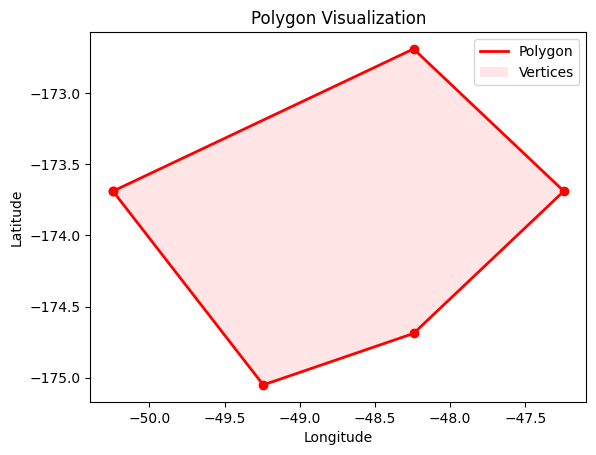

In [44]:
#########
#Useful code just for recording.
#########
import random
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import numpy as np

station_info = np.array([
    ['Station_1', -50.243061, -173.689087],
    ['Station_17', -50.71249, -175.050995],
    ['Station_29', -51.243061, -174.689087],
    ['Station_37', -52.243061, -173.689087],
    ['Station_42', -50.243061, -172.689087],
    ['Station_52', -49.243061, -173.689087],
    ['Station_61', -50.243061, -171.689087],
    ['Station_68', -51.71249, -175.050995],
    ['Station_69', -52.243061, -174.689087],
    ['Station_70', -51.243061, -172.689087],
    ['Station_82', -50.243061, -170.689087],
    ['Station_64', -49.243061, -175.050995],
    ['Station_38', -48.243061, -174.689087],
    ['Station_66', -49.243061, -173.689087],
    ['Station_80', -48.243061, -172.689087],
    ['Station_88', -47.243061, -173.689087]
])

Complete_Sub_matrix = np.array([
    [['Station_1', 'Station_64', 'Station_38', 'Station_66', 'Station_80', 'Station_88']] * 8
] * 11)

# Convert station_info to a dictionary for easy lookup
station_coords = {row[0]: (float(row[1]), float(row[2])) for row in station_info}

def convex_hull(points):
    if len(points) < 3:
        return points  # Convex hull is not defined for fewer than 3 points
    hull = ConvexHull(points)
    return [points[vertex] for vertex in hull.vertices]

def create_polygon_matrix(complete_sub_matrix, station_coords):
    complete_sub_polygon = np.empty((complete_sub_matrix.shape[0], complete_sub_matrix.shape[1]), dtype=object)
    for i in range(complete_sub_matrix.shape[0]):
        for j in range(complete_sub_matrix.shape[1]):
            stations = complete_sub_matrix[i, j]
            coords = [station_coords[station] for station in stations if station in station_coords]
            if len(coords) > 2:
                hull_coords = convex_hull(coords)
                complete_sub_polygon[i, j] = Polygon(hull_coords)
            else:
                complete_sub_polygon[i, j] = Polygon(coords)
    return complete_sub_polygon

# Generate the Complete_Sub_polygon matrix
Complete_Sub_polygon = create_polygon_matrix(Complete_Sub_matrix, station_coords)

# Example usage: plot the first polygon in the matrix
polygon = Complete_Sub_polygon[0, 2]

def plot_polygon(polygon):
    fig, ax = plt.subplots()
    if polygon.is_valid:
        x, y = polygon.exterior.xy
        ax.plot(x, y, 'r-', lw=2)
        ax.fill(x, y, 'red', alpha=0.1)
        ax.scatter(x, y, color='red')
    
    ax.set_title('Polygon Visualization')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(['Polygon', 'Vertices'])
    plt.show()

# Plot the first polygon
plot_polygon(polygon)


In [ ]:
###########
#Useful code just to record
###########
import random
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

def random_int_list(start, end, num):
    return [random.randint(start, end) for _ in range(num)]

def generate_points(num_points=100):
    x = random_int_list(1, 1000, num_points)
    y = random_int_list(1, 1000, num_points)
    return list(zip(x, y))

def convex_hull(points):
    hull = ConvexHull(points)
    return [points[vertex] for vertex in hull.vertices]

def plot_points(points, hull):
    x, y = zip(*points)
    plt.plot(x, y, 'o')
    
    hx, hy = zip(*hull)
    hx += (hx[0],)
    hy += (hy[0],)
    plt.plot(hx, hy, 'r-', lw=2)
    plt.fill(hx, hy, 'red', alpha=0.1)
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Convex Hull')
    plt.show()

def point_in_polygon(point, polygon):
    return polygon.contains(Point(point))

def shoelace_formula(x, y):
    n = len(x)
    area = 0.0
    j = n - 1
    for i in range(0, n):
        area += (x[j] + x[i]) * (y[j] - y[i])
        j = i  # j is previous vertex to i
    return abs(area / 2.0)

if __name__ == '__main__':
    points = generate_points()
    print("Generated Points:")
    print(points)
    
    hull_points = convex_hull(points)
    print("Convex Hull Points:")
    print(hull_points)
    
    plot_points(points, hull_points)
    
    polygon = Polygon(hull_points)
    
    # Example test point
    test_point = (500, 500)
    is_inside = point_in_polygon(test_point, polygon)
    print(f"Test Point {test_point}: {'inside' if is_inside else 'outside'} the convex hull")
    
    # Extract x and y coordinates of the convex hull
    x_line, y_line = zip(*hull_points)
    
    # Calculate the area of the polygon using the Shoelace formula
    area = shoelace_formula(x_line, y_line)
    print(f"Area of the polygon: {area}")
    
    # Plot the test point
    plt.plot(*zip(*points), 'o')  # All points
    plt.plot(x_line + (x_line[0],), y_line + (y_line[0],), 'r-', lw=2)  # Convex hull
    plt.fill(x_line + (x_line[0],), y_line + (y_line[0],), 'red', alpha=0.1)  # Convex hull area
    plt.plot(test_point[0], test_point[1], 'go' if is_inside else 'bo', markersize=10)  # Test point
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Convex Hull with Test Point')
    plt.legend(['Points', 'Convex Hull', 'Test Point'])
    plt.show()


In [19]:
import numpy as np
import torch
from MOESTKF_functions import *
# Example usage
N, T, F, Prop = 100, 365*24, 8, 'Gaussian'
station_info, station_value = Toy_generation(N, T, F, Prop)
complete_stations, complete_indices = get_complete_stations(station_info, station_value)
K = 5
subgraph_matrix = Feature_wise_Subgraph(station_info, station_value, complete_stations, complete_indices, K)
complete_sub_matrix = np.empty((subgraph_matrix.shape[0], subgraph_matrix.shape[1], 6), dtype=object)

# Fill the new matrix
for i, complete_station in enumerate(complete_stations):
    for j in range(subgraph_matrix.shape[1]):
        complete_sub_matrix[i, j] = np.insert(subgraph_matrix[i, j], 0, complete_station)

def compute_adjacency_matrix_with_decay(complete_sub_matrix, station_value, station_info, alpha=0.01):
    num_king_stations = complete_sub_matrix.shape[0]
    num_features = complete_sub_matrix.shape[1]
    num_sub_stations = complete_sub_matrix.shape[1]

    adjacency_matrix = []

    # Create a dictionary to map station names to their indices in station_value and extract coordinates
    station_indices = {station_info[i][0]: i for i in range(len(station_info))}
    station_coords = {station_info[i][0]: (station_info[i][1], station_info[i][2]) for i in range(len(station_info))}

    def decay_function(distance, alpha=0.1):
        return np.exp(-alpha * distance**2)

    for i in range(num_king_stations):
        for j in range(num_features):
            adjacency_matrices = np.zeros((num_sub_stations, num_sub_stations))
            for k in range(num_sub_stations):
                for l in range(num_sub_stations):
                    station_k = complete_sub_matrix[i, j, k]
                    station_l = complete_sub_matrix[i, j, l]

                    if station_k in station_indices and station_l in station_indices:
                        index_k = station_indices[station_k]
                        index_l = station_indices[station_l]

                        feature_k = station_value[index_k, :, j].numpy()
                        feature_l = station_value[index_l, :, j].numpy()

                        # Compute Pearson correlation
                        if np.std(feature_k) != 0 and np.std(feature_l) != 0:
                            correlation = np.corrcoef(feature_k, feature_l)[0, 1]
                        else:
                            correlation = 0

                        adjacency_matrices[k, l] = correlation
            
            adjacency_matrix.append(adjacency_matrices)

    adjacency_matrix = np.array(adjacency_matrix).reshape((num_king_stations, num_features, num_sub_stations, num_sub_stations)).tolist()

    # Transform adjacency_matrix into adjacency_matrix_decay
    adjacency_matrix_decay = []

    for i in range(num_king_stations):
        station_decay = []
        for j in range(num_features):
            corr_matrix = np.array(adjacency_matrix[i][j])
            sub_station_names = complete_sub_matrix[i, j]
            coords = np.array([station_coords[station] for station in sub_station_names])
            distances = np.linalg.norm(coords[:, np.newaxis] - coords[np.newaxis, :], axis=2)
            decay_values = decay_function(distances, alpha)
            corr_matrix *= decay_values
            station_decay.append(corr_matrix)
        adjacency_matrix_decay.append(station_decay)

    return adjacency_matrix_decay

# Example usage
adjacency_matrix_decay = compute_adjacency_matrix_with_decay(complete_sub_matrix, station_value, station_info, alpha=0.01)

# Print the results
for i, station_decay in enumerate(adjacency_matrix_decay):
    print(f"King Station {i + 1}:")
    for j, decay_matrix in enumerate(station_decay):
        print(f"  Feature {j + 1} Decay Matrix:")
        print(decay_matrix)


IndexError: index 6 is out of bounds for axis 2 with size 6

In [20]:
##Just for recording
import matplotlib.pyplot as plt
import numpy as np

# The string containing the polygon definition
complete_sub_polygon=Complete_Sub_polygon
# Extract the coordinates from the string
polygon_coords_str = complete_sub_polygon.replace("POLYGON ((", "").replace("))", "")
polygon_coords_list = polygon_coords_str.split(", ")

# Convert the string coordinates to a numpy array
polygon_coords = np.array([list(map(float, coord.split())) for coord in polygon_coords_list])

# Plot the polygon
plt.figure()
plt.plot(polygon_coords[:, 1], polygon_coords[:, 0], marker='o')  # Plot the points
plt.fill(polygon_coords[:, 1], polygon_coords[:, 0], 'skyblue', alpha=0.5)  # Fill the polygon
plt.title('Polygon Visualization')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.axis('equal')

# Show the plot
plt.show()

NameError: name 'Complete_Sub_polygon' is not defined

In [21]:
import torch
torch.__version__



'2.3.1+cu121'

In [58]:
!nvidia-smi


Failed to initialize NVML: Driver/library version mismatch
NVML library version: 535.171


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

class GNNTimeSeriesPyG(nn.Module):
    def __init__(self, num_nodes, num_timesteps, hidden_dim):
        super(GNNTimeSeriesPyG, self).__init__()
        self.num_nodes = num_nodes
        self.num_timesteps = num_timesteps
        self.hidden_dim = hidden_dim
        
        # Learnable adjacency matrix
        self.adj_matrix = nn.Parameter(torch.rand(num_nodes, num_nodes))
        
        # Graph convolutional layer
        self.gcn = GCNConv(num_timesteps, hidden_dim)
        
        # Output layer for prediction
        self.output_layer = nn.Linear(hidden_dim, 1)
    
    def forward(self, data):
        A = F.softmax(self.adj_matrix, dim=1)  # Normalize adjacency matrix
        x, edge_index = data.x, data.edge_index
        x = torch.matmul(A, x)  # Apply adjacency matrix
        x = self.gcn(x, edge_index)
        x = F.relu(x)
        x = self.output_layer(x)
        return x

# Parameters
num_nodes = 4
num_timesteps = 500
hidden_dim = 128

# Create a sample graph
edge_index = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes)], dtype=torch.long).t().contiguous()
data = torch.randn(num_nodes, num_timesteps)  # Example feature matrix with 4 nodes and 500 timesteps
targets = torch.randn(num_nodes, 1)  # Example target values

# Create a PyTorch Geometric graph
graph_data = Data(x=data, edge_index=edge_index)

# Model instantiation
model = GNNTimeSeriesPyG(num_nodes, num_timesteps, hidden_dim)

# Training parameters
learning_rate = 0.01
num_epochs = 1000

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    predictions = model(graph_data)
    
    # Compute loss
    loss = criterion(predictions, targets)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

# Best adjacency matrix
best_adj_matrix = model.adj_matrix.detach().numpy()
print("Best Adjacency Matrix:")
print(best_adj_matrix)


Epoch [0/1000], Loss: 0.0812
Epoch [100/1000], Loss: 0.0790
Epoch [200/1000], Loss: 0.0760
Epoch [300/1000], Loss: 0.0760
Epoch [400/1000], Loss: 0.0760
Epoch [500/1000], Loss: 0.0760
Epoch [600/1000], Loss: 0.0760
Epoch [700/1000], Loss: 0.0760
Epoch [800/1000], Loss: 0.0760
Epoch [900/1000], Loss: 0.0760
Best Adjacency Matrix:
[[0.31750387 0.5421595  0.6990938  0.61968446]
 [0.33999637 1.0092825  0.32291454 0.37736064]
 [0.77381897 0.24726447 0.86870867 0.745386  ]
 [0.8526382  0.5940254  0.8022954  0.3821163 ]]


In [2]:
!pip install pydantic


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.0/409.0 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 94.4 MB/s eta 0:00:00


Epoch 1/100
7/7 [==============================] - 0s 5ms/step - loss: 0.4109
Epoch 2/100
7/7 [==============================] - 0s 3ms/step - loss: 0.4014
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 0.3962
Epoch 4/100
7/7 [==============================] - 0s 1ms/step - loss: 0.3913
Epoch 5/100
7/7 [==============================] - 0s 639us/step - loss: 0.3874
Epoch 6/100
7/7 [==============================] - 0s 854us/step - loss: 0.3853
Epoch 7/100
7/7 [==============================] - 0s 808us/step - loss: 0.3835
Epoch 8/100
7/7 [==============================] - 0s 515us/step - loss: 0.3822
Epoch 9/100
7/7 [==============================] - 0s 532us/step - loss: 0.3810
Epoch 10/100
7/7 [==============================] - 0s 522us/step - loss: 0.3803
Epoch 11/100
7/7 [==============================] - 0s 448us/step - loss: 0.3803
Epoch 12/100
7/7 [==============================] - 0s 489us/step - loss: 0.3791
Epoch 13/100
7/7 [===========================

/home/xren451/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/xren451/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21333 (\N{CJK UNIFIED IDEOGRAPH-5355}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/xren451/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21464 (\N{CJK UNIFIED IDEOGRAPH-53D8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/xren451/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/xren451/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  

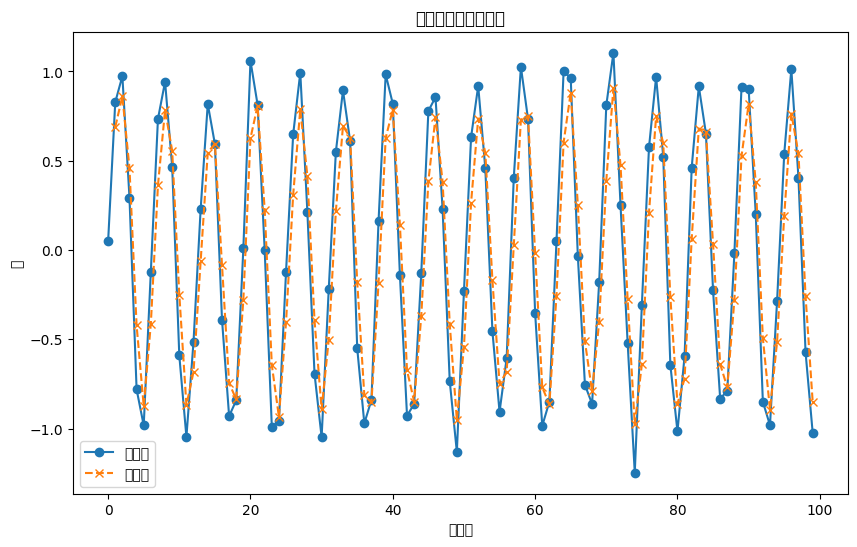

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
import matplotlib.pyplot as plt

# Random seed
np.random.seed(42)
tf.random.set_seed(42)

# Input generation
def generate_data(T):
    time = np.arange(T)
    data = np.sin(time) + np.random.normal(scale=0.1, size=(T,))
    return data

# Parameters
T = 100  # Time steps

# Generate data
train = generate_data(T)
tgt = generate_data(T)

# State equation model
def state_transition(x, u):
    return x + 0.1 * u

def observation_model(x):
    return x

# Learnable component
def build_nn_model(input_dim, output_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(16, activation='relu')(inputs)
    outputs = Dense(output_dim)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# Create neural network models
state_nn = build_nn_model(1, 1)
obs_nn = build_nn_model(1, 1)

# UKF
class UnscentedKalmanFilter:
    def __init__(self, state_dim, process_noise, measurement_noise):
        self.state_dim = state_dim
        self.process_noise = process_noise
        self.measurement_noise = measurement_noise
        self.state_mean = np.zeros(state_dim)
        self.state_cov = np.eye(state_dim)

    def predict(self, control_input):
        nn_input = control_input.reshape(1, -1)
        self.state_mean = state_nn.predict(nn_input).flatten()
        self.state_cov += self.process_noise

    def update(self, observation):
        nn_input = self.state_mean.reshape(1, -1)
        predicted_obs = obs_nn.predict(nn_input).flatten()
        kalman_gain = self.state_cov / (self.state_cov + self.measurement_noise)
        self.state_mean += kalman_gain @ (observation - predicted_obs)
        self.state_cov = (np.eye(self.state_dim) - kalman_gain) @ self.state_cov

# Initial parameters
process_noise = np.eye(1) * 0.1
measurement_noise = np.eye(1) * 0.1

# Create UKF object
ukf = UnscentedKalmanFilter(1, process_noise, measurement_noise)

# Training
X_train = train[:-1].reshape(-1, 1)  # Shape (T-1, 1)
y_train = train[1:].reshape(-1, 1)   # Shape (T-1, 1)

# Train the neural networks
state_nn.fit(X_train, y_train, epochs=100, batch_size=16)
obs_nn.fit(X_train, y_train, epochs=100, batch_size=16)

# Prediction
predictions = []
for t in range(T-1):
    control_input = train[t]
    ukf.predict(np.array([control_input]))
    
    observation = train[t+1]
    ukf.update(np.array([observation]))
    
    predictions.append(ukf.state_mean)

predictions = np.array(predictions).flatten()

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(train, label='真实值', marker='o')
plt.plot(np.arange(1, T), predictions, label='预测值', linestyle='--', marker='x')
plt.xlabel('时间步')
plt.ylabel('值')
plt.title('单变量时间序列预测')
plt.legend()
plt.show()


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from spektral.layers import GCNConv
from spektral.utils import normalized_adjacency

# Define the GCN model
def create_gcn(input_dim, hidden_dim, output_dim):
    X_in = Input(shape=(input_dim,))
    A_in = Input(shape=(None,), sparse=True)

    x = GCNConv(hidden_dim, activation='relu')([X_in, A_in])
    x = GCNConv(output_dim)([x, A_in])

    model = Model(inputs=[X_in, A_in], outputs=x)
    model.compile(optimizer='adam', loss='mse')
    return model

# Define the UKF
class UnscentedKalmanFilter:
    def __init__(self, state_dim):
        self.state_dim = state_dim
        self.Q = np.eye(state_dim) * 0.01  # Process noise covariance
        self.R = np.eye(state_dim) * 0.1   # Measurement noise covariance

    def predict(self, x, P):
        # Predict step (here, we use identity for simplicity)
        x_pred = x  # In practice, use the state transition function
        P_pred = P + self.Q
        return x_pred, P_pred

    def update(self, x_pred, P_pred, z):
        # Update step
        Pz = P_pred + self.R
        K = P_pred @ np.linalg.inv(Pz)  # Kalman gain
        x = x_pred + (z - x_pred) @ K.T
        P = P_pred - K @ Pz @ K.T
        return x, P

# Initialize parameters
input_dim = 10  # Example input dimension
hidden_dim = 16
output_dim = input_dim
state_dim = input_dim
num_nodes = 5
num_steps = 50

# Generate synthetic data for demonstration
X = np.random.randn(num_nodes, input_dim)  # Node features
A = normalized_adjacency(np.eye(num_nodes))  # Initial adjacency matrix (identity for simplicity)
A = tf.sparse.from_dense(A)

# Initialize GCN, UKF, and state
gcn = create_gcn(input_dim, hidden_dim, output_dim)
ukf = UnscentedKalmanFilter(state_dim)
x = X
P = np.eye(state_dim)  # Initial state covariance

# Training loop
for t in range(num_steps):
    with tf.GradientTape() as tape:
        # GCN forward pass
        x_pred = gcn([x, A])

        # Convert predictions to numpy for UKF
        x_pred_np = x_pred.numpy()

        # UKF predict step
        x_pred_np, P_pred = ukf.predict(x_pred_np, P)

        # Simulate observation (for demonstration purposes)
        z = x_pred_np + np.random.randn(*x_pred_np.shape) * 0.1

        # UKF update step
        x_np, P = ukf.update(x_pred_np, P_pred, z)

        # Convert updated state back to tensor
        x = x_np

        # Loss computation (mean squared error for simplicity)
        loss = tf.reduce_mean(tf.square(x_pred - x))

    # Compute gradients and update weights
    gradients = tape.gradient(loss, gcn.trainable_variables)
    gcn.optimizer.apply_gradients(zip(gradients, gcn.trainable_variables))

    # Update adjacency matrix based on new state (simplified example)
    A = normalized_adjacency(np.eye(num_nodes))  # In practice, calculate new adjacency matrix based on updated state
    A = tf.sparse.from_dense(A)

    if t % 10 == 0:
        print(f'Step {t}, Loss: {loss.numpy()}')

print('Training complete.')


Step 0, Loss: 0.01060956809669733
Step 10, Loss: 0.0010618902742862701
Step 20, Loss: 0.0004309690266381949
Step 30, Loss: 0.0006107382941991091
Step 40, Loss: 0.0006493739201687276
Training complete.


The point is inside the polygon.
New adjacency matrix:
[[1.         0.8        0.6        0.20189652]
 [0.8        1.         0.5        0.00302755]
 [0.6        0.5        1.         0.082085  ]
 [0.20189652 0.00302755 0.082085   0.90483742]]
Attributes (determinants) of all polygons:
[-0.637518796246746, -0.6327637138155813, -0.624940108300411, -0.6141605698592413, -0.6005791299001502, -0.5843875155975624, -0.565810557022231, -0.5451008991704058, -0.5225331910777417, -0.4983979369143145, -0.4729951991365976, -0.44662834145209207, -0.4195979899234205, -0.3921963747168798, -0.36470219377439644, -0.3373761142542436, -0.31045699927558895, -0.28415891770280505, -0.2586689647862855, -0.2341458927171609, -0.21071952368463742, -0.18849089478123845, -0.1675330647888012, -0.14789249795671178, -0.12959092956632287, -0.1126276123394658, -0.09698184136154651, -0.08261565774087354, -0.06947663716853177, -0.05750067823627784, -0.04661471612215168, -0.03673929936404139, -0.02779098023679661, -0.0196

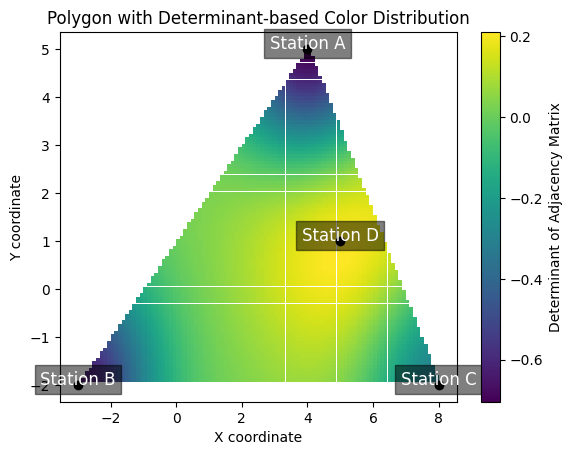

In [1]:
##########
# Visualize_complete_stations_and_subgraph
##########


import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point
import matplotlib.colors as mcolors

# Define the station coordinates
stations = np.array([
    [4, 5],   # A
    [-3, -2], # B
    [8, -2],  # C
    [5, 1]    # D
])

# Adjacency matrix
adjacency_matrix = np.array([
    [1, 0.8, 0.6, 0.3],
    [0.8, 1, 0.5, 0.6],
    [0.6, 0.5, 1, 0.5],
    [0.3, 0.6, 0.5, 1]
])

# Define the convex hull function
def convex_hull(points):
    if len(points) < 3:
        return points  # Convex hull is not defined for fewer than 3 points
    hull = ConvexHull(points)
    return hull.vertices

# Define the decay function (e.g., Gaussian decay)
def decay_function(distance, alpha=0.1):
    return np.exp(-alpha * distance**2)

# Compute the correlation between the patch and each station
def compute_correlation(x, y, stations, decay_function, alpha=0.1):
    distances = np.sqrt((x - stations[:, 0])**2 + (y - stations[:, 1])**2)
    correlations = decay_function(distances, alpha)
    return correlations

# Create the convex hull
hull_indices = convex_hull(stations)
hull_points = stations[hull_indices]

# Create the polygon
polygon = Polygon(hull_points)

# Function to check if a point is inside the polygon and compute the adjacency matrix
def check_point_and_compute_adj_matrix(point, polygon, stations, adjacency_matrix):
    if polygon.contains(point):
        x, y = point.x, point.y
        correlations = compute_correlation(x, y, stations, decay_function)
        new_adj_matrix = np.copy(adjacency_matrix)
        for k in range(len(stations)):
            new_adj_matrix[-1, k] = new_adj_matrix[k, -1] = correlations[k]
        return True, new_adj_matrix
    else:
        return False, None

# Test the function with an example point
test_point = Point(4, 1)
inside, new_adj_matrix = check_point_and_compute_adj_matrix(test_point, polygon, stations, adjacency_matrix)

if inside:
    print("The point is inside the polygon.")
    print("New adjacency matrix:")
    print(new_adj_matrix)
else:
    print("The point is outside the polygon.")

# Create a grid of points within the polygon
min_x, min_y, max_x, max_y = polygon.bounds
grid_x, grid_y = np.meshgrid(np.linspace(min_x, max_x, 100), np.linspace(min_y, max_y, 100))

# Compute the attributes of each grid point based on the new adjacency matrix
attributes = np.zeros(grid_x.shape)
all_determinants = []  # List to store the attributes of all polygons

for i in range(grid_x.shape[0]):
    for j in range(grid_x.shape[1]):
        point = Point(grid_x[i, j], grid_y[i, j])
        if polygon.contains(point):
            # Compute correlations between the patch and each station
            correlations = compute_correlation(grid_x[i, j], grid_y[i, j], stations, decay_function)
            
            # Construct the new adjacency matrix for this patch
            new_adj_matrix = np.copy(adjacency_matrix)
            for k in range(len(stations)):
                new_adj_matrix[-1, k] = new_adj_matrix[k, -1] = correlations[k]
            
            # Calculate the determinant of the new adjacency matrix
            determinant = np.linalg.det(new_adj_matrix)
            attributes[i, j] = determinant
            all_determinants.append(determinant)  # Store the determinant

# Print the attributes of all polygons
print("Attributes (determinants) of all polygons:")
print(all_determinants)

# Plot the polygon and color the patches based on attributes
fig, ax = plt.subplots()

# Color the patches based on attributes
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=attributes.min(), vmax=attributes.max())

for i in range(grid_x.shape[0]):
    for j in range(grid_x.shape[1]):
        point = Point(grid_x[i, j], grid_y[i, j])
        if polygon.contains(point):
            color = cmap(norm(attributes[i, j]))
            ax.add_patch(plt.Rectangle((grid_x[i, j], grid_y[i, j]), (max_x - min_x) / 100, (max_y - min_y) / 100, color=color, ec='none'))

# Plot the stations
ax.plot(stations[:, 0], stations[:, 1], 'ko')

# Annotate the stations
for i, (x, y) in enumerate(stations):
    ax.text(x, y, f'Station {chr(65+i)}', fontsize=12, ha='center', color='white', bbox=dict(facecolor='black', alpha=0.5))

# Add colorbar for reference
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, orientation='vertical', label='Determinant of Adjacency Matrix')

plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Polygon with Determinant-based Color Distribution')
plt.show()


In [3]:
##Realization of using two subgraphs separately.
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.metrics import mean_squared_error

# 生成站点位置
np.random.seed(42)
num_stations = 10
station_coords = np.random.rand(num_stations, 2)

# 一年的温度数据 (每小时一个数据点，24小时 * 365天)
time_steps = 24 * 365
temperature_data = np.random.rand(num_stations, time_steps) * 30  # 温度范围为0到30度

# 生成待插值点的位置和真实温度值
interpolation_point = np.random.rand(1, 2)
true_interpolation_temp = np.random.rand(time_steps) * 30  # 假设真实温度范围也为0到30度

# 定义两组子图
subgraph_1 = [0, 1, 2, 3, 4]
subgraph_2 = [5, 6, 7, 8, 9]

# 计算反向距离加权 (IDW) 方法的权重
def idw_interpolation(station_coords, temperatures, target_point, power=2):
    distances = np.linalg.norm(station_coords - target_point, axis=1)
    weights = 1 / (distances ** power)
    weights /= weights.sum()
    interpolated_value = np.dot(weights, temperatures)
    return interpolated_value

# 对两个子图应用 IDW 方法进行插值
idw_estimate_1 = np.array([idw_interpolation(station_coords[subgraph_1], temperature_data[subgraph_1, t], interpolation_point) for t in range(time_steps)])
idw_estimate_2 = np.array([idw_interpolation(station_coords[subgraph_2], temperature_data[subgraph_2, t], interpolation_point) for t in range(time_steps)])


# 构建GCN模型
class GCNModel(nn.Module):
    def __init__(self, num_features, hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

def prepare_data(subgraph, temperature_data, idw_estimate):
    edge_index = torch.tensor([[i, j] for i in range(len(subgraph)) for j in range(len(subgraph))], dtype=torch.long).t().contiguous()
    x = torch.tensor(temperature_data[subgraph], dtype=torch.float).t()
    y = torch.tensor(idw_estimate, dtype=torch.float).t()
    data = Data(x=x, edge_index=edge_index, y=y)
    return data

# 准备两个子图的数据
data_1 = prepare_data(subgraph_1, temperature_data, idw_estimate_1)
data_2 = prepare_data(subgraph_2, temperature_data, idw_estimate_2)

# 初始化模型
model_1 = GCNModel(num_features=len(subgraph_1), hidden_dim=16, output_dim=1)
model_2 = GCNModel(num_features=len(subgraph_2), hidden_dim=16, output_dim=1)


# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=0.01)
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.01)

# 训练模型并计算聚合的MSE损失
def train_model(model_1, model_2, data_1, data_2, optimizer_1, optimizer_2, criterion, num_epochs=200):
    for epoch in range(num_epochs):
        model_1.train()
        model_2.train()
        optimizer_1.zero_grad()
        optimizer_2.zero_grad()
        
        out_1 = model_1(data_1.x, data_1.edge_index)
        loss_1 = criterion(out_1.squeeze(), data_1.y)
        
        out_2 = model_2(data_2.x, data_2.edge_index)
        loss_2 = criterion(out_2.squeeze(), data_2.y)
        
        total_loss = loss_1 + loss_2
        total_loss.backward()
        
        optimizer_1.step()
        optimizer_2.step()
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss_1: {loss_1.item()}, Loss_2: {loss_2.item()}, Total Loss: {total_loss.item()}')

train_model(model_1, model_2, data_1, data_2, optimizer_1, optimizer_2, criterion)


# 预测待插值点的温度值
def predict(model, data):
    model.eval()
    with torch.no_grad():
        predicted_temp = model(data.x, data.edge_index)
    return predicted_temp.squeeze().numpy()

predicted_temp_1 = predict(model_1, data_1)
predicted_temp_2 = predict(model_2, data_2)

# 计算MSE
mse_1 = mean_squared_error(true_interpolation_temp, predicted_temp_1)
mse_2 = mean_squared_error(true_interpolation_temp, predicted_temp_2)

print("MSE for the interpolation point based on subgraph 1: ", mse_1)
print("MSE for the interpolation point based on subgraph 2: ", mse_2)


Epoch 20/200, Loss_1: 3.6249442100524902, Loss_2: 1.357730507850647, Total Loss: 4.982674598693848
Epoch 40/200, Loss_1: 1.1389092206954956, Loss_2: 0.23039202392101288, Total Loss: 1.369301199913025
Epoch 60/200, Loss_1: 0.6042481660842896, Loss_2: 0.07475045323371887, Total Loss: 0.678998589515686
Epoch 80/200, Loss_1: 0.25932955741882324, Loss_2: 0.04053173586726189, Total Loss: 0.29986128211021423
Epoch 100/200, Loss_1: 0.1479940414428711, Loss_2: 0.028716733679175377, Total Loss: 0.17671076953411102
Epoch 120/200, Loss_1: 0.11761508136987686, Loss_2: 0.022987855598330498, Total Loss: 0.1406029313802719
Epoch 140/200, Loss_1: 0.09892741590738297, Loss_2: 0.019299587234854698, Total Loss: 0.11822700500488281
Epoch 160/200, Loss_1: 0.08461498469114304, Loss_2: 0.01661567948758602, Total Loss: 0.1012306660413742
Epoch 180/200, Loss_1: 0.0730242058634758, Loss_2: 0.014576560817658901, Total Loss: 0.08760076761245728
Epoch 200/200, Loss_1: 0.06331859529018402, Loss_2: 0.0129810869693756

In [5]:
###MOE+GCN+IDW---Done perfectly!!!

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.metrics import mean_squared_error

# 生成站点位置
np.random.seed(42)
num_stations = 10
station_coords = np.random.rand(num_stations, 2)

# 一年的温度数据 (每小时一个数据点，24小时 * 365天)
time_steps = 24 * 365
temperature_data = np.random.rand(num_stations, time_steps) * 30  # 温度范围为0到30度

# 生成待插值点的位置和真实温度值
interpolation_point = np.random.rand(1, 2)
true_interpolation_temp = np.random.rand(time_steps) * 30  # 假设真实温度范围也为0到30度

# 定义两组子图
subgraph_1 = [0, 1, 2, 3, 4]
subgraph_2 = [5, 6, 7, 8, 9]

# 计算反向距离加权 (IDW) 方法的权重
def idw_interpolation(station_coords, temperatures, target_point, power=2):
    distances = np.linalg.norm(station_coords - target_point, axis=1)
    weights = 1 / (distances ** power)
    weights /= weights.sum()
    interpolated_value = np.dot(weights, temperatures)
    return interpolated_value

# 对两个子图应用 IDW 方法进行插值
idw_estimate_1 = np.array([idw_interpolation(station_coords[subgraph_1], temperature_data[subgraph_1, t], interpolation_point) for t in range(time_steps)])
idw_estimate_2 = np.array([idw_interpolation(station_coords[subgraph_2], temperature_data[subgraph_2, t], interpolation_point) for t in range(time_steps)])

# 构建GCN模型
class GCNModel(nn.Module):
    def __init__(self, num_features, hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

def prepare_data(subgraph, temperature_data, idw_estimate):
    edge_index = torch.tensor([[i, j] for i in range(len(subgraph)) for j in range(len(subgraph))], dtype=torch.long).t().contiguous()
    x = torch.tensor(temperature_data[subgraph], dtype=torch.float).t()
    y = torch.tensor(idw_estimate, dtype=torch.float).t()
    data = Data(x=x, edge_index=edge_index, y=y)
    return data

# 准备两个子图的数据
data_1 = prepare_data(subgraph_1, temperature_data, idw_estimate_1)
data_2 = prepare_data(subgraph_2, temperature_data, idw_estimate_2)

# 初始化模型
model_1 = GCNModel(num_features=len(subgraph_1), hidden_dim=16, output_dim=1)
model_2 = GCNModel(num_features=len(subgraph_2), hidden_dim=16, output_dim=1)

# 定义MoE模型
class MoEModel(nn.Module):
    def __init__(self, gcn1, gcn2, hidden_dim):
        super(MoEModel, self).__init__()
        self.gcn1 = gcn1
        self.gcn2 = gcn2
        self.gate = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x1, edge_index1, x2, edge_index2):
        out1 = self.gcn1(x1, edge_index1).view(-1, 1)
        out2 = self.gcn2(x2, edge_index2).view(-1, 1)
        gate_input = torch.cat([out1, out2], dim=1)
        gate_output = self.gate(gate_input)
        out = gate_output[:, 0].unsqueeze(1) * out1 + gate_output[:, 1].unsqueeze(1) * out2
        return out

# 初始化MoE模型
hidden_dim = 16
moe_model = MoEModel(model_1, model_2, hidden_dim)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(moe_model.parameters(), lr=0.01)

# 训练MoE模型
def train_model(moe_model, data_1, data_2, optimizer, criterion, num_epochs=200):
    for epoch in range(num_epochs):
        moe_model.train()
        optimizer.zero_grad()
        
        out = moe_model(data_1.x, data_1.edge_index, data_2.x, data_2.edge_index)
        
        loss_1 = criterion(out.squeeze(), data_1.y)
        loss_2 = criterion(out.squeeze(), data_2.y)
        
        total_loss = loss_1 + loss_2
        total_loss.backward()
        
        optimizer.step()
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss_1: {loss_1.item()}, Loss_2: {loss_2.item()}, Total Loss: {total_loss.item()}')

train_model(moe_model, data_1, data_2, optimizer, criterion)

# 预测待插值点的温度值
def predict(moe_model, data_1, data_2):
    moe_model.eval()
    with torch.no_grad():
        predicted_temp = moe_model(data_1.x, data_1.edge_index, data_2.x, data_2.edge_index)
    return predicted_temp.squeeze().numpy()

predicted_temp = predict(moe_model, data_1, data_2)

# 计算MSE
mse = mean_squared_error(true_interpolation_temp, predicted_temp)

print("MSE for the interpolation point based on MoE: ", mse)


Epoch 20/200, Loss_1: 44.45172882080078, Loss_2: 12.3259859085083, Total Loss: 56.777713775634766
Epoch 40/200, Loss_1: 10.031998634338379, Loss_2: 22.212543487548828, Total Loss: 32.24454116821289
Epoch 60/200, Loss_1: 11.082686424255371, Loss_2: 14.890462875366211, Total Loss: 25.973148345947266
Epoch 80/200, Loss_1: 11.915462493896484, Loss_2: 10.233261108398438, Total Loss: 22.148723602294922
Epoch 100/200, Loss_1: 11.259462356567383, Loss_2: 10.43935489654541, Total Loss: 21.69881820678711
Epoch 120/200, Loss_1: 10.80937385559082, Loss_2: 10.662515640258789, Total Loss: 21.47188949584961
Epoch 140/200, Loss_1: 10.720182418823242, Loss_2: 10.618102073669434, Total Loss: 21.33828353881836
Epoch 160/200, Loss_1: 10.649215698242188, Loss_2: 10.586006164550781, Total Loss: 21.23522186279297
Epoch 180/200, Loss_1: 10.597330093383789, Loss_2: 10.552395820617676, Total Loss: 21.14972686767578
Epoch 200/200, Loss_1: 10.555078506469727, Loss_2: 10.521711349487305, Total Loss: 21.07678985595

In [19]:
##MOE+GCN+IDW---Done perfectly!!!
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.metrics import mean_squared_error

# Generate station locations
np.random.seed(42)
num_stations = 10
station_coords = np.random.rand(num_stations, 2)

# Temperature data for one year (one data point per hour, 24 hours * 365 days)
time_steps = 24 * 365
temperature_data = np.random.rand(num_stations, time_steps) * 30  # Temperature range 0 to 30 degrees

# Generate interpolation point location and true temperature values
interpolation_point = np.random.rand(1, 2)
true_interpolation_temp = np.random.rand(time_steps) * 30  # Assume true temperature range is also 0 to 30 degrees

# Define two subgraphs
subgraph_1 = [0, 1, 2, 3, 4]
subgraph_2 = [5, 6, 7, 8, 9]

# Inverse Distance Weighting (IDW) interpolation
def idw_interpolation(station_coords, temperatures, target_point, power=2):
    distances = np.linalg.norm(station_coords - target_point, axis=1)
    weights = 1 / (distances ** power)
    weights /= weights.sum()
    interpolated_value = np.dot(weights, temperatures)
    return interpolated_value

# Apply IDW interpolation to the two subgraphs
idw_estimate_1 = np.array([idw_interpolation(station_coords[subgraph_1], temperature_data[subgraph_1, t], interpolation_point) for t in range(time_steps)])
idw_estimate_2 = np.array([idw_interpolation(station_coords[subgraph_2], temperature_data[subgraph_2, t], interpolation_point) for t in range(time_steps)])

# Define GCN model
class GCNModel(nn.Module):
    def __init__(self, num_features, hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
    
    def forward(self, x, edge_index, adj):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

def calculate_inverse_distance_adj(station_coords, decay):
    num_nodes = station_coords.shape[0]
    adj = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                distance = np.linalg.norm(station_coords[i] - station_coords[j])
                adj[i, j] = np.exp(-decay * distance)
    return torch.tensor(adj, dtype=torch.float)

def prepare_data(subgraph, temperature_data, idw_estimate, decay):
    edge_index = torch.tensor([[i, j] for i in range(len(subgraph)) for j in range(len(subgraph))], dtype=torch.long).t().contiguous()
    adj = calculate_inverse_distance_adj(station_coords[subgraph], decay)
    x = torch.tensor(temperature_data[subgraph], dtype=torch.float).t()
    y = torch.tensor(idw_estimate, dtype=torch.float).t()
    data = Data(x=x, edge_index=edge_index, y=y, adj=adj)
    return data

# Initialize models
def initialize_models():
    model_1 = GCNModel(num_features=len(subgraph_1), hidden_dim=16, output_dim=1)
    model_2 = GCNModel(num_features=len(subgraph_2), hidden_dim=16, output_dim=1)
    return model_1, model_2

# Define MoE model
class MoEModel(nn.Module):
    def __init__(self, gcn1, gcn2, hidden_dim):
        super(MoEModel, self).__init__()
        self.gcn1 = gcn1
        self.gcn2 = gcn2
        self.gate = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x1, edge_index1, adj1, x2, edge_index2, adj2):
        out1 = self.gcn1(x1, edge_index1, adj1).view(-1, 1)
        out2 = self.gcn2(x2, edge_index2, adj2).view(-1, 1)
        gate_input = torch.cat([out1, out2], dim=1)
        gate_output = self.gate(gate_input)
        out = gate_output[:, 0].unsqueeze(1) * out1 + gate_output[:, 1].unsqueeze(1) * out2
        return out

# Train MoE model
def train_model(moe_model, data_1, data_2, optimizer, criterion, num_epochs=200):
    for epoch in range(num_epochs):
        moe_model.train()
        optimizer.zero_grad()
        
        out = moe_model(data_1.x, data_1.edge_index, data_1.adj, data_2.x, data_2.edge_index, data_2.adj)
        
        loss_1 = criterion(out.squeeze(), data_1.y)
        loss_2 = criterion(out.squeeze(), data_2.y)
        
        total_loss = loss_1 + loss_2
        total_loss.backward()
        
        optimizer.step()
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss_1: {loss_1.item()}, Loss_2: {loss_2.item()}, Total Loss: {total_loss.item()}')

# Predict temperature for the interpolation point
def predict(moe_model, data_1, data_2):
    moe_model.eval()
    with torch.no_grad():
        predicted_temp = moe_model(data_1.x, data_1.edge_index, data_1.adj, data_2.x, data_2.edge_index, data_2.adj)
    return predicted_temp.squeeze().numpy()

# Define loss function and optimizer
criterion = nn.MSELoss()

# MCMC for evaluating decay coefficients
def mcmc_decay_selection(decay_coefficients, num_samples=100):
    samples = []
    current_decay = np.random.choice(decay_coefficients)
    current_mse = evaluate_decay(current_decay)
    samples.append((current_decay, current_mse))

    for _ in range(num_samples):
        proposed_decay = np.random.choice(decay_coefficients)
        proposed_mse = evaluate_decay(proposed_decay)

        acceptance_prob = min(1, np.exp(current_mse - proposed_mse))
        if np.random.rand() < acceptance_prob:
            current_decay = proposed_decay
            current_mse = proposed_mse
        
        samples.append((current_decay, current_mse))
    
    return samples

def evaluate_decay(decay):
    data_1 = prepare_data(subgraph_1, temperature_data, idw_estimate_1, decay)
    data_2 = prepare_data(subgraph_2, temperature_data, idw_estimate_2, decay)
    model_1, model_2 = initialize_models()
    moe_model = MoEModel(model_1, model_2, hidden_dim)
    optimizer = optim.Adam(moe_model.parameters(), lr=0.01)
    
    train_model(moe_model, data_1, data_2, optimizer, criterion)
    predicted_temp = predict(moe_model, data_1, data_2)
    mse = mean_squared_error(true_interpolation_temp, predicted_temp)
    
    return mse

# Evaluate different decay coefficients using MCMC
decay_coefficients = np.arange(0, 1.6, 0.1)
samples = mcmc_decay_selection(decay_coefficients)
best_sample = min(samples, key=lambda x: x[1])
best_decay = best_sample[0]
best_mse = best_sample[1]

print(f'Best decay coefficient: {best_decay}, MSE: {best_mse}')


Epoch 20/200, Loss_1: 37.64280319213867, Loss_2: 11.409466743469238, Total Loss: 49.052268981933594
Epoch 40/200, Loss_1: 29.93665885925293, Loss_2: 5.663915634155273, Total Loss: 35.6005744934082
Epoch 60/200, Loss_1: 27.27684211730957, Loss_2: 6.198276996612549, Total Loss: 33.475120544433594
Epoch 80/200, Loss_1: 12.01282787322998, Loss_2: 13.401081085205078, Total Loss: 25.413909912109375
Epoch 100/200, Loss_1: 12.130440711975098, Loss_2: 11.008453369140625, Total Loss: 23.138893127441406
Epoch 120/200, Loss_1: 10.89117431640625, Loss_2: 11.484134674072266, Total Loss: 22.375308990478516
Epoch 140/200, Loss_1: 10.795836448669434, Loss_2: 11.104419708251953, Total Loss: 21.900257110595703
Epoch 160/200, Loss_1: 10.565078735351562, Loss_2: 11.014655113220215, Total Loss: 21.579734802246094
Epoch 180/200, Loss_1: 10.398354530334473, Loss_2: 10.959837913513184, Total Loss: 21.358192443847656
Epoch 200/200, Loss_1: 10.326875686645508, Loss_2: 10.877296447753906, Total Loss: 21.204172134

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.metrics import mean_squared_error

# Generate station locations
np.random.seed(42)
num_stations = 10
station_coords = np.random.rand(num_stations, 2)

# Temperature data for one year (one data point per hour, 24 hours * 365 days)
time_steps = 24 * 365
temperature_data = np.random.rand(num_stations, time_steps) * 30  # Temperature range 0 to 30 degrees

# Min-Max normalization for each station's temperature series
min_temp = np.min(temperature_data, axis=1).reshape(-1, 1)
max_temp = np.max(temperature_data, axis=1).reshape(-1, 1)
temperature_data_normalized = (temperature_data - min_temp) / (max_temp - min_temp)

# Generate interpolation point location and true temperature values
interpolation_point = np.random.rand(1, 2)
true_interpolation_temp = np.random.rand(time_steps) * 30  # Assume true temperature range is also 0 to 30 degrees

# Normalize true_interpolation_temp
true_min_temp = np.min(true_interpolation_temp)
true_max_temp = np.max(true_interpolation_temp)
true_interpolation_temp_normalized = (true_interpolation_temp - true_min_temp) / (true_max_temp - true_min_temp)

# Define two subgraphs
subgraph_1 = [0, 1, 2, 3, 4]
subgraph_2 = [5, 6, 7, 8, 9]

# Inverse Distance Weighting (IDW) interpolation
def idw_interpolation(station_coords, temperatures, target_point, power=2):
    distances = np.linalg.norm(station_coords - target_point, axis=1)
    weights = 1 / (distances ** power)
    weights /= weights.sum()
    interpolated_value = np.dot(weights, temperatures)
    return interpolated_value

# Apply IDW interpolation to the two subgraphs
idw_estimate_1 = np.array([idw_interpolation(station_coords[subgraph_1], temperature_data_normalized[subgraph_1, t], interpolation_point) for t in range(time_steps)])
idw_estimate_2 = np.array([idw_interpolation(station_coords[subgraph_2], temperature_data_normalized[subgraph_2, t], interpolation_point) for t in range(time_steps)])

# Define GCN model
class GCNModel(nn.Module):
    def __init__(self, num_features, hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
    
    def forward(self, x, edge_index, adj):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

def calculate_inverse_distance_adj(station_coords, decay):
    num_nodes = station_coords.shape[0]
    adj = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                distance = np.linalg.norm(station_coords[i] - station_coords[j])
                adj[i, j] = np.exp(-decay * distance)
    return torch.tensor(adj, dtype=torch.float)

def prepare_data(subgraph, temperature_data, idw_estimate, decay):
    edge_index = torch.tensor([[i, j] for i in range(len(subgraph)) for j in range(len(subgraph))], dtype=torch.long).t().contiguous()
    adj = calculate_inverse_distance_adj(station_coords[subgraph], decay)
    x = torch.tensor(temperature_data[subgraph], dtype=torch.float).t()
    y = torch.tensor(idw_estimate, dtype=torch.float).t()
    data = Data(x=x, edge_index=edge_index, y=y, adj=adj)
    return data

# Initialize models
def initialize_models(hidden_dim):
    model_1 = GCNModel(num_features=len(subgraph_1), hidden_dim=hidden_dim, output_dim=1)
    model_2 = GCNModel(num_features=len(subgraph_2), hidden_dim=hidden_dim, output_dim=1)
    return model_1, model_2

# Define MoE model
class MoEModel(nn.Module):
    def __init__(self, gcn1, gcn2, hidden_dim):
        super(MoEModel, self).__init__()
        self.gcn1 = gcn1
        self.gcn2 = gcn2
        self.gate = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x1, edge_index1, adj1, x2, edge_index2, adj2):
        out1 = self.gcn1(x1, edge_index1, adj1).view(-1, 1)
        out2 = self.gcn2(x2, edge_index2, adj2).view(-1, 1)
        gate_input = torch.cat([out1, out2], dim=1)
        gate_output = self.gate(gate_input)
        out = gate_output[:, 0].unsqueeze(1) * out1 + gate_output[:, 1].unsqueeze(1) * out2
        return out

# Train MoE model
def train_model(moe_model, data_1, data_2, optimizer, criterion, num_epochs=200):
    for epoch in range(num_epochs):
        moe_model.train()
        optimizer.zero_grad()
        
        out = moe_model(data_1.x, data_1.edge_index, data_1.adj, data_2.x, data_2.edge_index, data_2.adj)
        
        loss_1 = criterion(out.squeeze(), data_1.y)
        loss_2 = criterion(out.squeeze(), data_2.y)
        
        total_loss = loss_1 + loss_2
        total_loss.backward()
        
        optimizer.step()
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss_1: {loss_1.item()}, Loss_2: {loss_2.item()}, Total Loss: {total_loss.item()}')

# Predict temperature for the interpolation point
def predict(moe_model, data_1, data_2):
    moe_model.eval()
    with torch.no_grad():
        predicted_temp = moe_model(data_1.x, data_1.edge_index, data_1.adj, data_2.x, data_2.edge_index, data_2.adj)
    return predicted_temp.squeeze().numpy()

# Define loss function and optimizer
criterion = nn.MSELoss()

# MCMC for evaluating decay coefficients
def mcmc_decay_selection(decay_coefficients, num_samples=100):
    samples = []
    current_decay = np.random.choice(decay_coefficients)
    current_mse = evaluate_decay(current_decay)
    samples.append((current_decay, current_mse))

    for _ in range(num_samples):
        proposed_decay = np.random.choice(decay_coefficients)
        proposed_mse = evaluate_decay(proposed_decay)

        acceptance_prob = min(1, np.exp(current_mse - proposed_mse))
        if np.random.rand() < acceptance_prob:
            current_decay = proposed_decay
            current_mse = proposed_mse
        
        samples.append((current_decay, current_mse))
    
    return samples

def evaluate_decay(decay):
    hidden_dim = 16  # Define hidden_dim here
    data_1 = prepare_data(subgraph_1, temperature_data_normalized, idw_estimate_1, decay)
    data_2 = prepare_data(subgraph_2, temperature_data_normalized, idw_estimate_2, decay)
    model_1, model_2 = initialize_models(hidden_dim)
    moe_model = MoEModel(model_1, model_2, hidden_dim)
    optimizer = optim.Adam(moe_model.parameters(), lr=0.01)
    
    train_model(moe_model, data_1, data_2, optimizer, criterion)
    predicted_temp_normalized = predict(moe_model, data_1, data_2)
    mse = mean_squared_error(true_interpolation_temp_normalized, predicted_temp_normalized)
    
    return mse

# Evaluate different decay coefficients using MCMC
decay_coefficients = np.arange(0, 1.6, 0.1)
samples = mcmc_decay_selection(decay_coefficients)
best_sample = min(samples, key=lambda x: x[1])
best_decay = best_sample[0]
best_mse = best_sample[1]

print(f'Best decay coefficient: {best_decay}, MSE: {best_mse}')


Epoch 20/200, Loss_1: 0.02139938808977604, Loss_2: 0.01349435094743967, Total Loss: 0.034893739968538284
Epoch 40/200, Loss_1: 0.01489842776209116, Loss_2: 0.012222418561577797, Total Loss: 0.02712084725499153
Epoch 60/200, Loss_1: 0.012183811515569687, Loss_2: 0.013301417231559753, Total Loss: 0.02548522874712944
Epoch 80/200, Loss_1: 0.01195431686937809, Loss_2: 0.012407919391989708, Total Loss: 0.024362236261367798
Epoch 100/200, Loss_1: 0.011899054981768131, Loss_2: 0.011994985863566399, Total Loss: 0.023894041776657104
Epoch 120/200, Loss_1: 0.011721738614141941, Loss_2: 0.01190375629812479, Total Loss: 0.02362549491226673
Epoch 140/200, Loss_1: 0.011662395671010017, Loss_2: 0.011805239133536816, Total Loss: 0.02346763387322426
Epoch 160/200, Loss_1: 0.011638063937425613, Loss_2: 0.011726325377821922, Total Loss: 0.023364389315247536
Epoch 180/200, Loss_1: 0.011605502106249332, Loss_2: 0.011684144847095013, Total Loss: 0.023289646953344345
Epoch 200/200, Loss_1: 0.0115866083651781

Inverse Distance Weighting (IDW) Interpolation Performance:
Mean Squared Error (MSE): 10.228174777765684


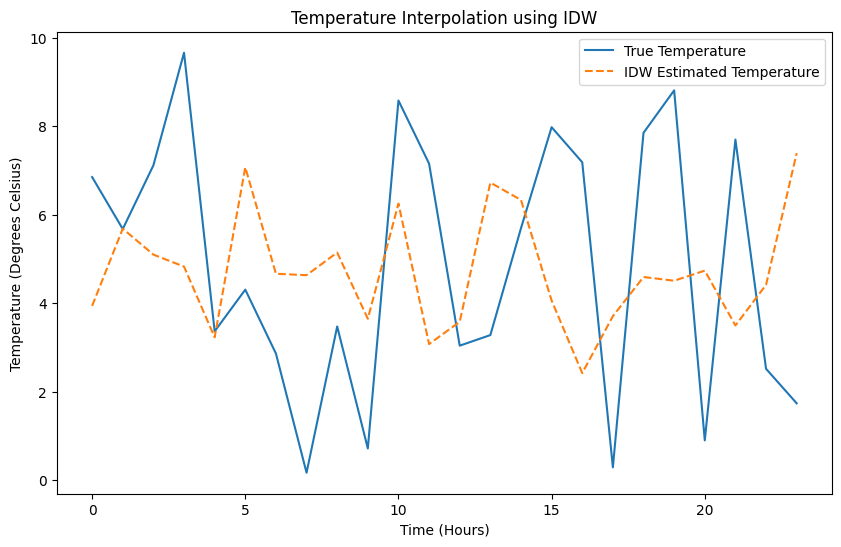

In [4]:
import numpy as np
from scipy.spatial.distance import euclidean
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Generate station locations
np.random.seed(42)
num_stations = 10
station_coords = np.random.rand(num_stations, 2)

# Temperature data for one year (one data point per hour, 24 hours * 365 days)
time_steps = 24 * 365
temperature_data = np.random.rand(num_stations, time_steps) * 30  # Temperature range 0 to 30 degrees

# Generate interpolation point location and true temperature values
interpolation_point = np.random.rand(1, 2)
true_interpolation_temp = np.random.rand(time_steps) * 10 # Assume true temperature range is also 0 to 30 degrees

# Define subgraphs (all stations will be used for IDW)
subgraph = np.arange(num_stations)

# Min-Max normalization
min_temp = np.min(temperature_data)
max_temp = np.max(temperature_data)
temperature_data_normalized = (temperature_data - min_temp) / (max_temp - min_temp)

true_min_temp = np.min(true_interpolation_temp)
true_max_temp = np.max(true_interpolation_temp)
true_interpolation_temp_normalized = (true_interpolation_temp - true_min_temp) / (true_max_temp - true_min_temp)

# Inverse Distance Weighting (IDW) interpolation
def idw_interpolation(station_coords, temperatures, target_point, power=2):
    distances = np.linalg.norm(station_coords - target_point, axis=1)
    weights = 1 / (distances ** power)
    weights /= weights.sum()
    interpolated_value = np.dot(weights, temperatures)
    return interpolated_value

# Apply IDW interpolation for all time steps on normalized data
idw_estimate_normalized = np.array([idw_interpolation(station_coords[subgraph], temperature_data_normalized[subgraph, t], interpolation_point) for t in range(time_steps)])

# Denormalize the IDW estimates
idw_estimate = idw_estimate_normalized * (true_max_temp - true_min_temp) + true_min_temp

# Evaluate the performance using Mean Squared Error (MSE)
mse = mean_squared_error(true_interpolation_temp, idw_estimate)

print(f'Inverse Distance Weighting (IDW) Interpolation Performance:')
print(f'Mean Squared Error (MSE): {mse}')

# Visualize the results for a subset of time steps (e.g., first 24 hours)
plt.figure(figsize=(10, 6))
plt.plot(true_interpolation_temp[:24], label='True Temperature')
plt.plot(idw_estimate[:24], label='IDW Estimated Temperature', linestyle='--')
plt.xlabel('Time (Hours)')
plt.ylabel('Temperature (Degrees Celsius)')
plt.title('Temperature Interpolation using IDW')
plt.legend()
plt.show()


In [22]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.metrics import mean_squared_error

# Generate station locations
np.random.seed(42)
num_stations = 10
station_coords = np.random.rand(num_stations, 2)

# Temperature data for one year (one data point per hour, 24 hours * 365 days)
time_steps = 24 * 365
temperature_data = np.random.rand(num_stations, time_steps) * 30  # Temperature range 0 to 30 degrees

# Generate interpolation point location and true temperature values
interpolation_point = np.random.rand(1, 2)
true_interpolation_temp = np.random.rand(time_steps) * 30  # Assume true temperature range is also 0 to 30 degrees

# Define two subgraphs
subgraph_1 = [0, 1, 2, 3, 4]
subgraph_2 = [5, 6, 7, 8, 9]

# Inverse Distance Weighting (IDW) interpolation
def idw_interpolation(station_coords, temperatures, target_point, power=2):
    distances = np.linalg.norm(station_coords - target_point, axis=1)
    weights = 1 / (distances ** power)
    weights /= weights.sum()
    interpolated_value = np.dot(weights, temperatures)
    return interpolated_value

# Apply IDW interpolation to the two subgraphs
idw_estimate_1 = np.array([idw_interpolation(station_coords[subgraph_1], temperature_data[subgraph_1, t], interpolation_point) for t in range(time_steps)])
idw_estimate_2 = np.array([idw_interpolation(station_coords[subgraph_2], temperature_data[subgraph_2, t], interpolation_point) for t in range(time_steps)])

# Define UKF
class UKF(nn.Module):
    def __init__(self, state_dim, obs_dim):
        super(UKF, self).__init__()
        self.state_dim = state_dim
        self.obs_dim = obs_dim
        self.state_transition = nn.Linear(state_dim, state_dim)
        self.observation_model = nn.Linear(state_dim, obs_dim)

    def forward(self, state, observation):
        state_pred = self.state_transition(state)
        obs_pred = self.observation_model(state_pred)
        innovation = observation - obs_pred
        state_update = state_pred + innovation
        return state_update

# Apply UKF to denoise IDW estimates
def apply_ukf(idw_estimates, obs_dim):
    state_dim = obs_dim  # Assuming state dimension is same as observation dimension
    ukf = UKF(state_dim, obs_dim)
    denoised_estimates = []

    state = torch.zeros((1, state_dim))  # Initialize state as zeros

    for t in range(idw_estimates.shape[0]):
        observation = torch.tensor(idw_estimates[t], dtype=torch.float).unsqueeze(0)
        state = ukf(state, observation)
        denoised_estimates.append(state.detach().numpy())

    denoised_estimates = np.squeeze(np.array(denoised_estimates), axis=1)
    return denoised_estimates

denoised_idw_1 = apply_ukf(idw_estimate_1, 1)
denoised_idw_2 = apply_ukf(idw_estimate_2, 1)

# Define GCN model
class GCNModel(nn.Module):
    def __init__(self, num_features, hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
    
    def forward(self, x, edge_index, adj):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

def calculate_inverse_distance_adj(station_coords, decay):
    num_nodes = station_coords.shape[0]
    adj = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                distance = np.linalg.norm(station_coords[i] - station_coords[j])
                adj[i, j] = np.exp(-decay * distance)
    return torch.tensor(adj, dtype=torch.float)

def prepare_data(subgraph, temperature_data, idw_estimate, decay):
    edge_index = torch.tensor([[i, j] for i in range(len(subgraph)) for j in range(len(subgraph))], dtype=torch.long).t().contiguous()
    adj = calculate_inverse_distance_adj(station_coords[subgraph], decay)
    x = torch.tensor(temperature_data[subgraph], dtype=torch.float).t()
    y = torch.tensor(idw_estimate, dtype=torch.float).t()
    data = Data(x=x, edge_index=edge_index, y=y, adj=adj)
    return data

# Initialize models
def initialize_models():
    model_1 = GCNModel(num_features=len(subgraph_1), hidden_dim=16, output_dim=1)
    model_2 = GCNModel(num_features=len(subgraph_2), hidden_dim=16, output_dim=1)
    return model_1, model_2

# Define MoE model
class MoEModel(nn.Module):
    def __init__(self, gcn1, gcn2, hidden_dim):
        super(MoEModel, self).__init__()
        self.gcn1 = gcn1
        self.gcn2 = gcn2
        self.gate = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x1, edge_index1, adj1, x2, edge_index2, adj2):
        out1 = self.gcn1(x1, edge_index1, adj1).view(-1, 1)
        out2 = self.gcn2(x2, edge_index2, adj2).view(-1, 1)
        gate_input = torch.cat([out1, out2], dim=1)
        gate_output = self.gate(gate_input)
        out = gate_output[:, 0].unsqueeze(1) * out1 + gate_output[:, 1].unsqueeze(1) * out2
        return out

# Train MoE model
def train_model(moe_model, data_1, data_2, optimizer, criterion, num_epochs=200):
    for epoch in range(num_epochs):
        moe_model.train()
        optimizer.zero_grad()
        
        out = moe_model(data_1.x, data_1.edge_index, data_1.adj, data_2.x, data_2.edge_index, data_2.adj)
        
        loss_1 = criterion(out.squeeze(), data_1.y)
        loss_2 = criterion(out.squeeze(), data_2.y)
        
        total_loss = loss_1 + loss_2
        total_loss.backward()
        
        optimizer.step()
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss_1: {loss_1.item()}, Loss_2: {loss_2.item()}, Total Loss: {total_loss.item()}')

# Predict temperature for the interpolation point
def predict(moe_model, data_1, data_2):
    moe_model.eval()
    with torch.no_grad():
        predicted_temp = moe_model(data_1.x, data_1.edge_index, data_1.adj, data_2.x, data_2.edge_index, data_2.adj)
    return predicted_temp.squeeze().numpy()

# Define loss function and optimizer
criterion = nn.MSELoss()

# MCMC for evaluating decay coefficients
def mcmc_decay_selection(decay_coefficients, num_samples=100):
    samples = []
    current_decay = np.random.choice(decay_coefficients)
    current_mse = evaluate_decay(current_decay)
    samples.append((current_decay, current_mse))

    for _ in range(num_samples):
        proposed_decay = np.random.choice(decay_coefficients)
        proposed_mse = evaluate_decay(proposed_decay)

        acceptance_prob = min(1, np.exp(current_mse - proposed_mse))
        if np.random.rand() < acceptance_prob:
            current_decay = proposed_decay
            current_mse = proposed_mse
        
        samples.append((current_decay, current_mse))
    
    return samples

def evaluate_decay(decay):
    data_1 = prepare_data(subgraph_1, temperature_data, denoised_idw_1, decay)
    data_2 = prepare_data(subgraph_2, temperature_data, denoised_idw_2, decay)
    model_1, model_2 = initialize_models()
    moe_model = MoEModel(model_1, model_2, hidden_dim)
    optimizer = optim.Adam(moe_model.parameters(), lr=0.01)
    
    train_model(moe_model, data_1, data_2, optimizer, criterion)
    predicted_temp = predict(moe_model, data_1, data_2)
    mse = mean_squared_error(true_interpolation_temp, predicted_temp)
    
    return mse

# Evaluate different decay coefficients using MCMC
decay_coefficients = np.arange(0, 1.6, 0.1)
samples = mcmc_decay_selection(decay_coefficients)
best_sample = min(samples, key=lambda x: x[1])
best_decay = best_sample[0]
best_mse = best_sample[1]

print(f'Best decay coefficient: {best_decay}, MSE: {best_mse}')


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 67.64292907714844, Loss_2: 13.550886154174805, Total Loss: 81.19381713867188
Epoch 40/200, Loss_1: 44.87471008300781, Loss_2: 23.074005126953125, Total Loss: 67.94871520996094
Epoch 60/200, Loss_1: 38.01762390136719, Loss_2: 25.739145278930664, Total Loss: 63.75676727294922
Epoch 80/200, Loss_1: 37.315391540527344, Loss_2: 25.96298599243164, Total Loss: 63.278377532958984
Epoch 100/200, Loss_1: 36.93281173706055, Loss_2: 25.827600479125977, Total Loss: 62.760414123535156
Epoch 120/200, Loss_1: 36.71731185913086, Loss_2: 25.452924728393555, Total Loss: 62.17023468017578
Epoch 140/200, Loss_1: 37.81958770751953, Loss_2: 22.263158798217773, Total Loss: 60.08274841308594
Epoch 160/200, Loss_1: 35.6573486328125, Loss_2: 21.642623901367188, Total Loss: 57.29997253417969
Epoch 180/200, Loss_1: 34.66404342651367, Loss_2: 22.350200653076172, Total Loss: 57.014244079589844
Epoch 200/200, Loss_1: 35.03673553466797, Loss_2: 21.841978073120117, Total Loss: 56.87871551513672


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 50.66238784790039, Loss_2: 52.52019500732422, Total Loss: 103.18258666992188
Epoch 40/200, Loss_1: 42.599342346191406, Loss_2: 23.923580169677734, Total Loss: 66.52291870117188
Epoch 60/200, Loss_1: 40.537132263183594, Loss_2: 20.282758712768555, Total Loss: 60.81989288330078
Epoch 80/200, Loss_1: 37.22311019897461, Loss_2: 21.970226287841797, Total Loss: 59.193336486816406
Epoch 100/200, Loss_1: 36.63315963745117, Loss_2: 21.798973083496094, Total Loss: 58.432132720947266
Epoch 120/200, Loss_1: 37.263710021972656, Loss_2: 20.668973922729492, Total Loss: 57.93268585205078
Epoch 140/200, Loss_1: 35.675437927246094, Loss_2: 23.095386505126953, Total Loss: 58.77082443237305
Epoch 160/200, Loss_1: 36.62958908081055, Loss_2: 20.765710830688477, Total Loss: 57.395301818847656
Epoch 180/200, Loss_1: 35.50163269042969, Loss_2: 21.477596282958984, Total Loss: 56.97922897338867
Epoch 200/200, Loss_1: 35.08555603027344, Loss_2: 21.739665985107422, Total Loss: 56.825222015380

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 80/200, Loss_1: 56.13463592529297, Loss_2: 16.092666625976562, Total Loss: 72.22730255126953
Epoch 100/200, Loss_1: 56.88938522338867, Loss_2: 15.109094619750977, Total Loss: 71.99848175048828
Epoch 120/200, Loss_1: 56.7205924987793, Loss_2: 15.111740112304688, Total Loss: 71.83233642578125
Epoch 140/200, Loss_1: 56.538970947265625, Loss_2: 15.153387069702148, Total Loss: 71.6923599243164
Epoch 160/200, Loss_1: 56.422054290771484, Loss_2: 15.147183418273926, Total Loss: 71.5692367553711
Epoch 180/200, Loss_1: 56.332332611083984, Loss_2: 15.125374794006348, Total Loss: 71.45771026611328
Epoch 200/200, Loss_1: 56.26497268676758, Loss_2: 15.0853271484375, Total Loss: 71.35029602050781
Epoch 20/200, Loss_1: 23.929859161376953, Loss_2: 56.56035232543945, Total Loss: 80.4902114868164


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 29.449718475341797, Loss_2: 38.25566482543945, Total Loss: 67.70538330078125
Epoch 60/200, Loss_1: 29.36783790588379, Loss_2: 33.415496826171875, Total Loss: 62.78333282470703
Epoch 80/200, Loss_1: 46.95384979248047, Loss_2: 15.585943222045898, Total Loss: 62.539794921875
Epoch 100/200, Loss_1: 31.68253517150879, Loss_2: 27.908418655395508, Total Loss: 59.5909538269043
Epoch 120/200, Loss_1: 33.71413803100586, Loss_2: 24.857330322265625, Total Loss: 58.571468353271484
Epoch 140/200, Loss_1: 35.66718292236328, Loss_2: 22.374202728271484, Total Loss: 58.041385650634766
Epoch 160/200, Loss_1: 34.1311149597168, Loss_2: 23.59432601928711, Total Loss: 57.725440979003906
Epoch 180/200, Loss_1: 37.82691192626953, Loss_2: 19.78483772277832, Total Loss: 57.61174774169922
Epoch 200/200, Loss_1: 38.48036193847656, Loss_2: 19.025985717773438, Total Loss: 57.50634765625
Epoch 20/200, Loss_1: 62.61188507080078, Loss_2: 18.7130069732666, Total Loss: 81.32489013671875
Epoch 40/200

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 60/200, Loss_1: 36.80654525756836, Loss_2: 27.17218589782715, Total Loss: 63.978729248046875
Epoch 80/200, Loss_1: 37.3575325012207, Loss_2: 25.74893569946289, Total Loss: 63.106468200683594
Epoch 100/200, Loss_1: 37.154537200927734, Loss_2: 25.625364303588867, Total Loss: 62.77989959716797
Epoch 120/200, Loss_1: 37.08797073364258, Loss_2: 25.499378204345703, Total Loss: 62.58734893798828
Epoch 140/200, Loss_1: 37.00400161743164, Loss_2: 25.428709030151367, Total Loss: 62.432708740234375
Epoch 160/200, Loss_1: 37.00838851928711, Loss_2: 25.276220321655273, Total Loss: 62.28460693359375
Epoch 180/200, Loss_1: 36.953983306884766, Loss_2: 25.168210983276367, Total Loss: 62.1221923828125
Epoch 200/200, Loss_1: 36.94532775878906, Loss_2: 24.93855857849121, Total Loss: 61.883888244628906
Epoch 20/200, Loss_1: 30.386104583740234, Loss_2: 44.05849838256836, Total Loss: 74.4446029663086


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 27.710302352905273, Loss_2: 40.187843322753906, Total Loss: 67.89814758300781
Epoch 60/200, Loss_1: 27.689315795898438, Loss_2: 39.243499755859375, Total Loss: 66.93281555175781
Epoch 80/200, Loss_1: 27.88834571838379, Loss_2: 38.669063568115234, Total Loss: 66.55741119384766
Epoch 100/200, Loss_1: 27.906707763671875, Loss_2: 38.33543395996094, Total Loss: 66.24214172363281
Epoch 120/200, Loss_1: 28.16413688659668, Loss_2: 37.79816818237305, Total Loss: 65.9623031616211
Epoch 140/200, Loss_1: 28.404586791992188, Loss_2: 37.304229736328125, Total Loss: 65.70881652832031
Epoch 160/200, Loss_1: 28.62249183654785, Loss_2: 36.856651306152344, Total Loss: 65.47914123535156
Epoch 180/200, Loss_1: 28.8555965423584, Loss_2: 36.42827606201172, Total Loss: 65.28387451171875
Epoch 200/200, Loss_1: 29.12611198425293, Loss_2: 35.996742248535156, Total Loss: 65.12285614013672


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 50.00823211669922, Loss_2: 39.47462844848633, Total Loss: 89.48286437988281
Epoch 40/200, Loss_1: 59.25349044799805, Loss_2: 13.203028678894043, Total Loss: 72.4565200805664
Epoch 60/200, Loss_1: 56.308597564697266, Loss_2: 14.142781257629395, Total Loss: 70.45137786865234
Epoch 80/200, Loss_1: 50.25394058227539, Loss_2: 16.470399856567383, Total Loss: 66.7243423461914
Epoch 100/200, Loss_1: 41.18593215942383, Loss_2: 20.214252471923828, Total Loss: 61.400184631347656
Epoch 120/200, Loss_1: 36.7089958190918, Loss_2: 21.98352813720703, Total Loss: 58.69252395629883
Epoch 140/200, Loss_1: 35.75094223022461, Loss_2: 21.8583927154541, Total Loss: 57.609336853027344
Epoch 160/200, Loss_1: 35.57914352416992, Loss_2: 21.482215881347656, Total Loss: 57.06135940551758
Epoch 180/200, Loss_1: 34.81765365600586, Loss_2: 22.017549514770508, Total Loss: 56.835205078125
Epoch 200/200, Loss_1: 34.93715286254883, Loss_2: 21.778308868408203, Total Loss: 56.71546173095703


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 26.227588653564453, Loss_2: 43.291236877441406, Total Loss: 69.51882934570312
Epoch 40/200, Loss_1: 25.390108108520508, Loss_2: 43.047672271728516, Total Loss: 68.43778228759766
Epoch 60/200, Loss_1: 27.169353485107422, Loss_2: 40.60273361206055, Total Loss: 67.77208709716797
Epoch 80/200, Loss_1: 27.138811111450195, Loss_2: 40.26003646850586, Total Loss: 67.39884948730469
Epoch 100/200, Loss_1: 26.903526306152344, Loss_2: 40.148128509521484, Total Loss: 67.05165100097656
Epoch 120/200, Loss_1: 27.037452697753906, Loss_2: 39.63992691040039, Total Loss: 66.67738342285156
Epoch 140/200, Loss_1: 27.322492599487305, Loss_2: 38.42163848876953, Total Loss: 65.74413299560547
Epoch 160/200, Loss_1: 37.921791076660156, Loss_2: 31.325748443603516, Total Loss: 69.24754333496094
Epoch 180/200, Loss_1: 25.396718978881836, Loss_2: 38.80733871459961, Total Loss: 64.20405578613281
Epoch 200/200, Loss_1: 34.333831787109375, Loss_2: 26.16031837463379, Total Loss: 60.49414825439453


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 58.85732650756836, Loss_2: 13.769559860229492, Total Loss: 72.62688446044922
Epoch 40/200, Loss_1: 46.401161193847656, Loss_2: 19.04856300354004, Total Loss: 65.44972229003906
Epoch 60/200, Loss_1: 43.03377914428711, Loss_2: 20.12417221069336, Total Loss: 63.15795135498047
Epoch 80/200, Loss_1: 42.86336135864258, Loss_2: 19.27203369140625, Total Loss: 62.13539505004883
Epoch 100/200, Loss_1: 41.827396392822266, Loss_2: 19.47413444519043, Total Loss: 61.30152893066406
Epoch 120/200, Loss_1: 39.79274368286133, Loss_2: 20.75414276123047, Total Loss: 60.5468864440918
Epoch 140/200, Loss_1: 41.186668395996094, Loss_2: 18.610708236694336, Total Loss: 59.79737854003906
Epoch 160/200, Loss_1: 37.6619987487793, Loss_2: 21.126583099365234, Total Loss: 58.78858184814453
Epoch 180/200, Loss_1: 36.72949981689453, Loss_2: 21.21010971069336, Total Loss: 57.93960952758789
Epoch 200/200, Loss_1: 36.265625, Loss_2: 21.164974212646484, Total Loss: 57.430599212646484


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 54.15079879760742, Loss_2: 19.481714248657227, Total Loss: 73.63251495361328
Epoch 40/200, Loss_1: 59.68772506713867, Loss_2: 12.651490211486816, Total Loss: 72.33921813964844
Epoch 60/200, Loss_1: 57.56062316894531, Loss_2: 14.145883560180664, Total Loss: 71.70650482177734
Epoch 80/200, Loss_1: 55.96791076660156, Loss_2: 15.457123756408691, Total Loss: 71.42503356933594
Epoch 100/200, Loss_1: 56.38929748535156, Loss_2: 14.847210884094238, Total Loss: 71.23651123046875
Epoch 120/200, Loss_1: 56.052677154541016, Loss_2: 15.011831283569336, Total Loss: 71.06450653076172
Epoch 140/200, Loss_1: 55.993690490722656, Loss_2: 14.896448135375977, Total Loss: 70.89013671875
Epoch 160/200, Loss_1: 55.83655548095703, Loss_2: 14.877864837646484, Total Loss: 70.71441650390625
Epoch 180/200, Loss_1: 55.67891311645508, Loss_2: 14.868185043334961, Total Loss: 70.5470962524414
Epoch 200/200, Loss_1: 55.517295837402344, Loss_2: 14.86636734008789, Total Loss: 70.3836669921875


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 19.652742385864258, Loss_2: 63.20625686645508, Total Loss: 82.85900115966797
Epoch 40/200, Loss_1: 24.433259963989258, Loss_2: 47.123939514160156, Total Loss: 71.55719757080078
Epoch 60/200, Loss_1: 26.14547348022461, Loss_2: 43.18438720703125, Total Loss: 69.32986450195312
Epoch 80/200, Loss_1: 27.01264190673828, Loss_2: 41.182411193847656, Total Loss: 68.19505310058594
Epoch 100/200, Loss_1: 27.635908126831055, Loss_2: 39.915035247802734, Total Loss: 67.55094146728516
Epoch 120/200, Loss_1: 27.670475006103516, Loss_2: 39.48100280761719, Total Loss: 67.15147399902344
Epoch 140/200, Loss_1: 27.701276779174805, Loss_2: 39.18566131591797, Total Loss: 66.8869400024414
Epoch 160/200, Loss_1: 27.775634765625, Loss_2: 38.925838470458984, Total Loss: 66.70147705078125
Epoch 180/200, Loss_1: 27.864368438720703, Loss_2: 38.68362045288086, Total Loss: 66.54798889160156
Epoch 200/200, Loss_1: 27.913522720336914, Loss_2: 38.505577087402344, Total Loss: 66.41909790039062


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 44.184207916259766, Loss_2: 37.784061431884766, Total Loss: 81.96826934814453
Epoch 40/200, Loss_1: 37.11309051513672, Loss_2: 24.767847061157227, Total Loss: 61.88093566894531
Epoch 60/200, Loss_1: 36.37987518310547, Loss_2: 22.311365127563477, Total Loss: 58.69123840332031
Epoch 80/200, Loss_1: 35.64268112182617, Loss_2: 22.306020736694336, Total Loss: 57.948699951171875
Epoch 100/200, Loss_1: 35.412330627441406, Loss_2: 22.245922088623047, Total Loss: 57.65825271606445
Epoch 120/200, Loss_1: 35.30519485473633, Loss_2: 22.153451919555664, Total Loss: 57.458648681640625
Epoch 140/200, Loss_1: 35.16204071044922, Loss_2: 22.114686965942383, Total Loss: 57.27672576904297
Epoch 160/200, Loss_1: 34.975257873535156, Loss_2: 22.177095413208008, Total Loss: 57.15235137939453
Epoch 180/200, Loss_1: 34.946929931640625, Loss_2: 22.104230880737305, Total Loss: 57.05116271972656
Epoch 200/200, Loss_1: 34.87568283081055, Loss_2: 22.08112144470215, Total Loss: 56.95680236816406

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 50.19316482543945, Loss_2: 31.38014793395996, Total Loss: 81.57331085205078
Epoch 40/200, Loss_1: 54.2288703918457, Loss_2: 22.575355529785156, Total Loss: 76.80422973632812
Epoch 60/200, Loss_1: 54.09463119506836, Loss_2: 19.606443405151367, Total Loss: 73.7010726928711
Epoch 80/200, Loss_1: 52.12459182739258, Loss_2: 18.542163848876953, Total Loss: 70.66675567626953
Epoch 100/200, Loss_1: 49.10708999633789, Loss_2: 19.04571533203125, Total Loss: 68.15280151367188
Epoch 120/200, Loss_1: 43.51734924316406, Loss_2: 20.964275360107422, Total Loss: 64.48162841796875
Epoch 140/200, Loss_1: 38.62856674194336, Loss_2: 21.37555694580078, Total Loss: 60.00412368774414
Epoch 160/200, Loss_1: 36.1457633972168, Loss_2: 21.978548049926758, Total Loss: 58.12431335449219
Epoch 180/200, Loss_1: 35.734432220458984, Loss_2: 21.85380744934082, Total Loss: 57.58824157714844
Epoch 200/200, Loss_1: 35.13114929199219, Loss_2: 22.227018356323242, Total Loss: 57.35816955566406
Epoch 20/2

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 53.01295852661133, Loss_2: 19.931772232055664, Total Loss: 72.94473266601562
Epoch 60/200, Loss_1: 40.96999740600586, Loss_2: 20.89313316345215, Total Loss: 61.863128662109375
Epoch 80/200, Loss_1: 38.22551345825195, Loss_2: 20.986217498779297, Total Loss: 59.21173095703125
Epoch 100/200, Loss_1: 36.69123458862305, Loss_2: 21.294727325439453, Total Loss: 57.9859619140625
Epoch 120/200, Loss_1: 36.36703109741211, Loss_2: 21.057512283325195, Total Loss: 57.42454528808594
Epoch 140/200, Loss_1: 35.90422439575195, Loss_2: 21.242847442626953, Total Loss: 57.147071838378906
Epoch 160/200, Loss_1: 35.67082977294922, Loss_2: 21.310285568237305, Total Loss: 56.981117248535156
Epoch 180/200, Loss_1: 35.508270263671875, Loss_2: 21.36251449584961, Total Loss: 56.870784759521484
Epoch 200/200, Loss_1: 35.387393951416016, Loss_2: 21.402027130126953, Total Loss: 56.78942108154297


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 38.3253288269043, Loss_2: 25.76592445373535, Total Loss: 64.09125518798828
Epoch 40/200, Loss_1: 35.314231872558594, Loss_2: 23.833030700683594, Total Loss: 59.14726257324219
Epoch 60/200, Loss_1: 35.92845153808594, Loss_2: 21.731691360473633, Total Loss: 57.66014099121094
Epoch 80/200, Loss_1: 35.85480880737305, Loss_2: 21.488847732543945, Total Loss: 57.343658447265625
Epoch 100/200, Loss_1: 35.206520080566406, Loss_2: 21.918676376342773, Total Loss: 57.12519836425781
Epoch 120/200, Loss_1: 35.23196029663086, Loss_2: 21.74488639831543, Total Loss: 56.976844787597656
Epoch 140/200, Loss_1: 35.11711502075195, Loss_2: 21.743330001831055, Total Loss: 56.860443115234375
Epoch 160/200, Loss_1: 35.05941390991211, Loss_2: 21.708415985107422, Total Loss: 56.76782989501953
Epoch 180/200, Loss_1: 35.00887680053711, Loss_2: 21.68760871887207, Total Loss: 56.69648742675781
Epoch 200/200, Loss_1: 34.96238708496094, Loss_2: 21.676883697509766, Total Loss: 56.6392707824707
Epoc

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 35.49854278564453, Loss_2: 26.697282791137695, Total Loss: 62.195823669433594
Epoch 60/200, Loss_1: 38.20294952392578, Loss_2: 19.82847785949707, Total Loss: 58.03142547607422
Epoch 80/200, Loss_1: 35.92439270019531, Loss_2: 21.52517318725586, Total Loss: 57.44956588745117
Epoch 100/200, Loss_1: 35.96110534667969, Loss_2: 21.19042205810547, Total Loss: 57.151527404785156
Epoch 120/200, Loss_1: 35.71262741088867, Loss_2: 21.235435485839844, Total Loss: 56.948062896728516
Epoch 140/200, Loss_1: 35.52005386352539, Loss_2: 21.267833709716797, Total Loss: 56.78788757324219
Epoch 160/200, Loss_1: 35.391624450683594, Loss_2: 21.276281356811523, Total Loss: 56.66790771484375
Epoch 180/200, Loss_1: 35.2971076965332, Loss_2: 21.2877140045166, Total Loss: 56.58482360839844
Epoch 200/200, Loss_1: 35.2042121887207, Loss_2: 21.31595230102539, Total Loss: 56.520164489746094


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 74.49761962890625, Loss_2: 16.813926696777344, Total Loss: 91.3115463256836
Epoch 40/200, Loss_1: 64.09877014160156, Loss_2: 11.517378807067871, Total Loss: 75.61614990234375
Epoch 60/200, Loss_1: 56.038204193115234, Loss_2: 16.759567260742188, Total Loss: 72.79777526855469
Epoch 80/200, Loss_1: 56.66339874267578, Loss_2: 15.620138168334961, Total Loss: 72.28353881835938
Epoch 100/200, Loss_1: 57.10869598388672, Loss_2: 14.807607650756836, Total Loss: 71.91630554199219
Epoch 120/200, Loss_1: 57.02249526977539, Loss_2: 14.600973129272461, Total Loss: 71.62346649169922
Epoch 140/200, Loss_1: 56.7635498046875, Loss_2: 14.609643936157227, Total Loss: 71.3731918334961
Epoch 160/200, Loss_1: 56.51209259033203, Loss_2: 14.675239562988281, Total Loss: 71.18733215332031
Epoch 180/200, Loss_1: 56.338253021240234, Loss_2: 14.724569320678711, Total Loss: 71.06282043457031
Epoch 200/200, Loss_1: 56.22948455810547, Loss_2: 14.732057571411133, Total Loss: 70.96154022216797
Epoch

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 80/200, Loss_1: 36.60336685180664, Loss_2: 20.26041030883789, Total Loss: 56.86377716064453
Epoch 100/200, Loss_1: 34.25432205200195, Loss_2: 22.39250946044922, Total Loss: 56.64683151245117
Epoch 120/200, Loss_1: 34.172977447509766, Loss_2: 22.381940841674805, Total Loss: 56.55491638183594
Epoch 140/200, Loss_1: 35.57650375366211, Loss_2: 20.915725708007812, Total Loss: 56.49222946166992
Epoch 160/200, Loss_1: 38.37766647338867, Loss_2: 18.456012725830078, Total Loss: 56.83367919921875
Epoch 180/200, Loss_1: 33.9595947265625, Loss_2: 22.501859664916992, Total Loss: 56.461456298828125
Epoch 200/200, Loss_1: 34.897579193115234, Loss_2: 21.527360916137695, Total Loss: 56.42494201660156
Epoch 20/200, Loss_1: 49.405765533447266, Loss_2: 46.44160079956055, Total Loss: 95.84736633300781


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 53.3486213684082, Loss_2: 20.31861114501953, Total Loss: 73.667236328125
Epoch 60/200, Loss_1: 58.476261138916016, Loss_2: 13.752485275268555, Total Loss: 72.22874450683594
Epoch 80/200, Loss_1: 56.52109146118164, Loss_2: 15.240710258483887, Total Loss: 71.76180267333984
Epoch 100/200, Loss_1: 56.27355194091797, Loss_2: 15.292840003967285, Total Loss: 71.56639099121094
Epoch 120/200, Loss_1: 56.4547233581543, Loss_2: 14.952485084533691, Total Loss: 71.40721130371094
Epoch 140/200, Loss_1: 56.2528076171875, Loss_2: 14.99543571472168, Total Loss: 71.24824523925781
Epoch 160/200, Loss_1: 56.2029914855957, Loss_2: 14.9015531539917, Total Loss: 71.10454559326172
Epoch 180/200, Loss_1: 55.99391555786133, Loss_2: 14.967596054077148, Total Loss: 70.96150970458984
Epoch 200/200, Loss_1: 55.96149444580078, Loss_2: 14.863526344299316, Total Loss: 70.82501983642578


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 37.11220932006836, Loss_2: 71.71133422851562, Total Loss: 108.82354736328125
Epoch 40/200, Loss_1: 35.060569763183594, Loss_2: 35.52269744873047, Total Loss: 70.58326721191406
Epoch 60/200, Loss_1: 35.342288970947266, Loss_2: 29.843257904052734, Total Loss: 65.185546875
Epoch 80/200, Loss_1: 34.88179397583008, Loss_2: 29.03348731994629, Total Loss: 63.915283203125
Epoch 100/200, Loss_1: 35.56203079223633, Loss_2: 27.583486557006836, Total Loss: 63.14551544189453
Epoch 120/200, Loss_1: 35.80729293823242, Loss_2: 26.889320373535156, Total Loss: 62.69661331176758
Epoch 140/200, Loss_1: 36.02461624145508, Loss_2: 26.398944854736328, Total Loss: 62.423561096191406
Epoch 160/200, Loss_1: 36.08072280883789, Loss_2: 26.18535804748535, Total Loss: 62.266082763671875
Epoch 180/200, Loss_1: 36.1406135559082, Loss_2: 26.02243423461914, Total Loss: 62.163047790527344
Epoch 200/200, Loss_1: 36.11087417602539, Loss_2: 25.98088836669922, Total Loss: 62.09176254272461


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 56.70541000366211, Loss_2: 17.37309455871582, Total Loss: 74.07850646972656
Epoch 40/200, Loss_1: 57.0637092590332, Loss_2: 13.289305686950684, Total Loss: 70.35301208496094
Epoch 60/200, Loss_1: 35.698368072509766, Loss_2: 22.483875274658203, Total Loss: 58.18224334716797
Epoch 80/200, Loss_1: 35.79880905151367, Loss_2: 21.35028648376465, Total Loss: 57.14909362792969
Epoch 100/200, Loss_1: 34.55876159667969, Loss_2: 22.16859245300293, Total Loss: 56.72735595703125
Epoch 120/200, Loss_1: 34.808929443359375, Loss_2: 21.763216018676758, Total Loss: 56.5721435546875
Epoch 140/200, Loss_1: 34.906429290771484, Loss_2: 21.592870712280273, Total Loss: 56.499298095703125
Epoch 160/200, Loss_1: 34.907325744628906, Loss_2: 21.547191619873047, Total Loss: 56.45451736450195
Epoch 180/200, Loss_1: 34.895904541015625, Loss_2: 21.526100158691406, Total Loss: 56.42200469970703
Epoch 200/200, Loss_1: 34.8813362121582, Loss_2: 21.51471519470215, Total Loss: 56.39604949951172


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 24.27663230895996, Loss_2: 54.20511245727539, Total Loss: 78.48174285888672
Epoch 40/200, Loss_1: 23.523706436157227, Loss_2: 46.11701965332031, Total Loss: 69.6407241821289
Epoch 60/200, Loss_1: 26.185148239135742, Loss_2: 41.82804870605469, Total Loss: 68.01319885253906
Epoch 80/200, Loss_1: 27.177383422851562, Loss_2: 40.4422721862793, Total Loss: 67.61965942382812
Epoch 100/200, Loss_1: 27.446975708007812, Loss_2: 39.945587158203125, Total Loss: 67.39256286621094
Epoch 120/200, Loss_1: 27.437488555908203, Loss_2: 39.772037506103516, Total Loss: 67.20952606201172
Epoch 140/200, Loss_1: 27.382680892944336, Loss_2: 39.6643180847168, Total Loss: 67.0469970703125
Epoch 160/200, Loss_1: 27.413576126098633, Loss_2: 39.481563568115234, Total Loss: 66.8951416015625
Epoch 180/200, Loss_1: 27.468103408813477, Loss_2: 39.287010192871094, Total Loss: 66.75511169433594
Epoch 200/200, Loss_1: 27.504526138305664, Loss_2: 39.11957931518555, Total Loss: 66.62410736083984
Epoch 

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 35.3536491394043, Loss_2: 23.22498321533203, Total Loss: 58.57863235473633
Epoch 60/200, Loss_1: 39.05691909790039, Loss_2: 18.714675903320312, Total Loss: 57.7715950012207
Epoch 80/200, Loss_1: 36.87388610839844, Loss_2: 20.36962890625, Total Loss: 57.24351501464844
Epoch 100/200, Loss_1: 35.52214431762695, Loss_2: 21.461671829223633, Total Loss: 56.98381805419922
Epoch 120/200, Loss_1: 35.431495666503906, Loss_2: 21.372438430786133, Total Loss: 56.803932189941406
Epoch 140/200, Loss_1: 39.161895751953125, Loss_2: 17.8798885345459, Total Loss: 57.041786193847656
Epoch 160/200, Loss_1: 34.17272186279297, Loss_2: 22.44951820373535, Total Loss: 56.62223815917969
Epoch 180/200, Loss_1: 34.58894348144531, Loss_2: 21.9390811920166, Total Loss: 56.52802276611328
Epoch 200/200, Loss_1: 34.54288864135742, Loss_2: 21.933250427246094, Total Loss: 56.476139068603516
Epoch 20/200, Loss_1: 22.27159309387207, Loss_2: 58.87815475463867, Total Loss: 81.14974975585938
Epoch 40/200

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 80/200, Loss_1: 37.0242919921875, Loss_2: 21.85893440246582, Total Loss: 58.88322448730469
Epoch 100/200, Loss_1: 35.77523422241211, Loss_2: 21.962356567382812, Total Loss: 57.73759078979492
Epoch 120/200, Loss_1: 35.803585052490234, Loss_2: 21.294147491455078, Total Loss: 57.09773254394531
Epoch 140/200, Loss_1: 35.68954849243164, Loss_2: 21.074539184570312, Total Loss: 56.76408767700195
Epoch 160/200, Loss_1: 35.41706466674805, Loss_2: 21.18634033203125, Total Loss: 56.6034049987793
Epoch 180/200, Loss_1: 36.761314392089844, Loss_2: 19.821529388427734, Total Loss: 56.58284378051758
Epoch 200/200, Loss_1: 34.858070373535156, Loss_2: 21.6188907623291, Total Loss: 56.476959228515625
Epoch 20/200, Loss_1: 21.36959457397461, Loss_2: 54.813419342041016, Total Loss: 76.18301391601562


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 24.032550811767578, Loss_2: 44.700096130371094, Total Loss: 68.73265075683594
Epoch 60/200, Loss_1: 28.050025939941406, Loss_2: 39.69975280761719, Total Loss: 67.7497787475586
Epoch 80/200, Loss_1: 26.399471282958984, Loss_2: 40.767539978027344, Total Loss: 67.16700744628906
Epoch 100/200, Loss_1: 27.03995704650879, Loss_2: 39.54792022705078, Total Loss: 66.58787536621094
Epoch 120/200, Loss_1: 29.179386138916016, Loss_2: 35.75128936767578, Total Loss: 64.93067932128906
Epoch 140/200, Loss_1: 35.69318771362305, Loss_2: 27.22374153137207, Total Loss: 62.91693115234375
Epoch 160/200, Loss_1: 37.17302322387695, Loss_2: 22.303258895874023, Total Loss: 59.476280212402344
Epoch 180/200, Loss_1: 35.11094284057617, Loss_2: 22.57793617248535, Total Loss: 57.688880920410156
Epoch 200/200, Loss_1: 35.66122817993164, Loss_2: 21.489700317382812, Total Loss: 57.15092849731445
Epoch 20/200, Loss_1: 47.48448944091797, Loss_2: 31.69161605834961, Total Loss: 79.17610168457031
Epoch

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 80/200, Loss_1: 37.87950897216797, Loss_2: 20.545835494995117, Total Loss: 58.42534637451172
Epoch 100/200, Loss_1: 37.443634033203125, Loss_2: 20.31009292602539, Total Loss: 57.753726959228516
Epoch 120/200, Loss_1: 36.30683135986328, Loss_2: 21.044185638427734, Total Loss: 57.351016998291016
Epoch 140/200, Loss_1: 35.928688049316406, Loss_2: 21.183338165283203, Total Loss: 57.11202621459961
Epoch 160/200, Loss_1: 35.684967041015625, Loss_2: 21.264299392700195, Total Loss: 56.94926452636719
Epoch 180/200, Loss_1: 35.44346237182617, Loss_2: 21.388248443603516, Total Loss: 56.83171081542969
Epoch 200/200, Loss_1: 35.31483840942383, Loss_2: 21.427202224731445, Total Loss: 56.742042541503906
Epoch 20/200, Loss_1: 57.48914337158203, Loss_2: 44.083988189697266, Total Loss: 101.57313537597656


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 26.347278594970703, Loss_2: 44.27928161621094, Total Loss: 70.62655639648438
Epoch 60/200, Loss_1: 28.9888916015625, Loss_2: 38.566707611083984, Total Loss: 67.55560302734375
Epoch 80/200, Loss_1: 32.612060546875, Loss_2: 33.05853271484375, Total Loss: 65.67059326171875
Epoch 100/200, Loss_1: 53.895198822021484, Loss_2: 11.96218204498291, Total Loss: 65.85738372802734
Epoch 120/200, Loss_1: 37.49797439575195, Loss_2: 21.286396026611328, Total Loss: 58.78437042236328
Epoch 140/200, Loss_1: 34.97526931762695, Loss_2: 22.905872344970703, Total Loss: 57.881141662597656
Epoch 160/200, Loss_1: 34.75324249267578, Loss_2: 22.608247756958008, Total Loss: 57.361488342285156
Epoch 180/200, Loss_1: 36.74428939819336, Loss_2: 20.294206619262695, Total Loss: 57.03849792480469
Epoch 200/200, Loss_1: 37.42378616333008, Loss_2: 19.56558609008789, Total Loss: 56.98937225341797
Epoch 20/200, Loss_1: 48.9664421081543, Loss_2: 30.366363525390625, Total Loss: 79.33280944824219
Epoch 40

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 60/200, Loss_1: 55.62959289550781, Loss_2: 16.191274642944336, Total Loss: 71.82086944580078
Epoch 80/200, Loss_1: 55.7292594909668, Loss_2: 15.793962478637695, Total Loss: 71.52322387695312
Epoch 100/200, Loss_1: 56.1290168762207, Loss_2: 15.18846321105957, Total Loss: 71.3174819946289
Epoch 120/200, Loss_1: 56.16673278808594, Loss_2: 14.966960906982422, Total Loss: 71.13369750976562
Epoch 140/200, Loss_1: 55.880393981933594, Loss_2: 15.04214859008789, Total Loss: 70.92254638671875
Epoch 160/200, Loss_1: 55.919517517089844, Loss_2: 14.857372283935547, Total Loss: 70.77688598632812
Epoch 180/200, Loss_1: 55.77480697631836, Loss_2: 14.871509552001953, Total Loss: 70.64631652832031
Epoch 200/200, Loss_1: 55.687774658203125, Loss_2: 14.834403991699219, Total Loss: 70.52217864990234
Epoch 20/200, Loss_1: 127.47859954833984, Loss_2: 23.091964721679688, Total Loss: 150.570556640625
Epoch 40/200, Loss_1: 54.35124969482422, Loss_2: 29.450748443603516, Total Loss: 83.802001953125
Epoch 60

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 80/200, Loss_1: 58.145999908447266, Loss_2: 14.179056167602539, Total Loss: 72.32505798339844
Epoch 100/200, Loss_1: 51.33810806274414, Loss_2: 17.94101905822754, Total Loss: 69.27912902832031
Epoch 120/200, Loss_1: 43.49921417236328, Loss_2: 16.673248291015625, Total Loss: 60.172462463378906
Epoch 140/200, Loss_1: 35.39247131347656, Loss_2: 22.52784538269043, Total Loss: 57.920318603515625
Epoch 160/200, Loss_1: 35.432838439941406, Loss_2: 22.219268798828125, Total Loss: 57.65210723876953
Epoch 180/200, Loss_1: 35.59882736206055, Loss_2: 21.89780616760254, Total Loss: 57.49663543701172
Epoch 200/200, Loss_1: 35.53147506713867, Loss_2: 21.833635330200195, Total Loss: 57.3651123046875
Epoch 20/200, Loss_1: 63.382286071777344, Loss_2: 11.630619049072266, Total Loss: 75.01290893554688


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 40.968055725097656, Loss_2: 22.032434463500977, Total Loss: 63.00048828125
Epoch 60/200, Loss_1: 36.491676330566406, Loss_2: 21.937835693359375, Total Loss: 58.42951202392578
Epoch 80/200, Loss_1: 35.89198684692383, Loss_2: 21.662975311279297, Total Loss: 57.554962158203125
Epoch 100/200, Loss_1: 35.350608825683594, Loss_2: 21.764944076538086, Total Loss: 57.11555480957031
Epoch 120/200, Loss_1: 35.28521728515625, Loss_2: 21.628746032714844, Total Loss: 56.913963317871094
Epoch 140/200, Loss_1: 34.996795654296875, Loss_2: 21.80759048461914, Total Loss: 56.804386138916016
Epoch 160/200, Loss_1: 34.99769592285156, Loss_2: 21.730804443359375, Total Loss: 56.72850036621094
Epoch 180/200, Loss_1: 34.933841705322266, Loss_2: 21.73621368408203, Total Loss: 56.6700553894043
Epoch 200/200, Loss_1: 34.90924835205078, Loss_2: 21.713315963745117, Total Loss: 56.62256622314453


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 37.881629943847656, Loss_2: 22.739559173583984, Total Loss: 60.62118911743164
Epoch 40/200, Loss_1: 37.3061408996582, Loss_2: 20.375123977661133, Total Loss: 57.68126678466797
Epoch 60/200, Loss_1: 35.3791389465332, Loss_2: 21.56406593322754, Total Loss: 56.943206787109375
Epoch 80/200, Loss_1: 35.38327407836914, Loss_2: 21.320024490356445, Total Loss: 56.70330047607422
Epoch 100/200, Loss_1: 35.16520309448242, Loss_2: 21.415576934814453, Total Loss: 56.580780029296875
Epoch 120/200, Loss_1: 35.0764045715332, Loss_2: 21.42587661743164, Total Loss: 56.502281188964844
Epoch 140/200, Loss_1: 35.00220489501953, Loss_2: 21.446378707885742, Total Loss: 56.448585510253906
Epoch 160/200, Loss_1: 34.97515869140625, Loss_2: 21.434873580932617, Total Loss: 56.4100341796875
Epoch 180/200, Loss_1: 34.94282913208008, Loss_2: 21.4373779296875, Total Loss: 56.38020706176758
Epoch 200/200, Loss_1: 34.92105484008789, Loss_2: 21.436771392822266, Total Loss: 56.357826232910156
Epoch 

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 38.060699462890625, Loss_2: 22.193012237548828, Total Loss: 60.25371170043945
Epoch 60/200, Loss_1: 34.532203674316406, Loss_2: 22.95505142211914, Total Loss: 57.48725509643555
Epoch 80/200, Loss_1: 35.01430892944336, Loss_2: 22.082128524780273, Total Loss: 57.096435546875
Epoch 100/200, Loss_1: 34.96841049194336, Loss_2: 21.933996200561523, Total Loss: 56.90240478515625
Epoch 120/200, Loss_1: 34.971858978271484, Loss_2: 21.791866302490234, Total Loss: 56.76372528076172
Epoch 140/200, Loss_1: 34.93351745605469, Loss_2: 21.731660842895508, Total Loss: 56.66517639160156
Epoch 160/200, Loss_1: 34.906497955322266, Loss_2: 21.690099716186523, Total Loss: 56.596595764160156
Epoch 180/200, Loss_1: 34.89046859741211, Loss_2: 21.651639938354492, Total Loss: 56.54210662841797
Epoch 200/200, Loss_1: 34.862091064453125, Loss_2: 21.63629150390625, Total Loss: 56.498382568359375
Epoch 20/200, Loss_1: 50.30014419555664, Loss_2: 29.799854278564453, Total Loss: 80.0999984741211


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 30.436355590820312, Loss_2: 34.69412612915039, Total Loss: 65.13047790527344
Epoch 60/200, Loss_1: 36.145877838134766, Loss_2: 26.592967987060547, Total Loss: 62.73884582519531
Epoch 80/200, Loss_1: 36.748294830322266, Loss_2: 25.640539169311523, Total Loss: 62.388832092285156
Epoch 100/200, Loss_1: 36.44858169555664, Loss_2: 25.79905891418457, Total Loss: 62.247642517089844
Epoch 120/200, Loss_1: 36.20285415649414, Loss_2: 25.95056915283203, Total Loss: 62.15342330932617
Epoch 140/200, Loss_1: 36.07986831665039, Loss_2: 25.961898803710938, Total Loss: 62.04176712036133
Epoch 160/200, Loss_1: 36.0306396484375, Loss_2: 25.797800064086914, Total Loss: 61.82843780517578
Epoch 180/200, Loss_1: 36.06153869628906, Loss_2: 24.784351348876953, Total Loss: 60.845890045166016
Epoch 200/200, Loss_1: 33.52973556518555, Loss_2: 23.829219818115234, Total Loss: 57.35895538330078


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 28.68524742126465, Loss_2: 33.53905487060547, Total Loss: 62.22430419921875
Epoch 40/200, Loss_1: 38.96589660644531, Loss_2: 19.20380210876465, Total Loss: 58.169700622558594
Epoch 60/200, Loss_1: 34.269737243652344, Loss_2: 22.819473266601562, Total Loss: 57.089210510253906
Epoch 80/200, Loss_1: 35.299800872802734, Loss_2: 21.49553680419922, Total Loss: 56.79533767700195
Epoch 100/200, Loss_1: 35.210548400878906, Loss_2: 21.42861557006836, Total Loss: 56.639163970947266
Epoch 120/200, Loss_1: 35.05933380126953, Loss_2: 21.49345588684082, Total Loss: 56.55278778076172
Epoch 140/200, Loss_1: 35.045684814453125, Loss_2: 21.449838638305664, Total Loss: 56.495521545410156
Epoch 160/200, Loss_1: 34.98602294921875, Loss_2: 21.462060928344727, Total Loss: 56.448081970214844
Epoch 180/200, Loss_1: 34.94218444824219, Loss_2: 21.47416877746582, Total Loss: 56.416351318359375
Epoch 200/200, Loss_1: 34.91185760498047, Loss_2: 21.481983184814453, Total Loss: 56.39384078979492


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 60/200, Loss_1: 37.32024383544922, Loss_2: 21.6106014251709, Total Loss: 58.93084716796875
Epoch 80/200, Loss_1: 36.607051849365234, Loss_2: 21.515533447265625, Total Loss: 58.12258529663086
Epoch 100/200, Loss_1: 36.018775939941406, Loss_2: 21.638465881347656, Total Loss: 57.65724182128906
Epoch 120/200, Loss_1: 35.4461669921875, Loss_2: 21.894784927368164, Total Loss: 57.34095001220703
Epoch 140/200, Loss_1: 35.19249725341797, Loss_2: 21.93410301208496, Total Loss: 57.12660217285156
Epoch 160/200, Loss_1: 35.0804328918457, Loss_2: 21.901063919067383, Total Loss: 56.98149871826172
Epoch 180/200, Loss_1: 34.96298599243164, Loss_2: 21.910987854003906, Total Loss: 56.87397384643555
Epoch 200/200, Loss_1: 34.900978088378906, Loss_2: 21.874658584594727, Total Loss: 56.775634765625
Epoch 20/200, Loss_1: 32.36396408081055, Loss_2: 37.92412567138672, Total Loss: 70.2880859375
Epoch 40/200, Loss_1: 24.79827308654785, Loss_2: 42.9942512512207, Total Loss: 67.79252624511719


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 60/200, Loss_1: 26.996490478515625, Loss_2: 40.2338981628418, Total Loss: 67.23039245605469
Epoch 80/200, Loss_1: 26.738445281982422, Loss_2: 40.2573127746582, Total Loss: 66.99575805664062
Epoch 100/200, Loss_1: 26.80009651184082, Loss_2: 39.99365234375, Total Loss: 66.79374694824219
Epoch 120/200, Loss_1: 27.09685707092285, Loss_2: 39.494564056396484, Total Loss: 66.59142303466797
Epoch 140/200, Loss_1: 27.247241973876953, Loss_2: 39.09906005859375, Total Loss: 66.34629821777344
Epoch 160/200, Loss_1: 27.792015075683594, Loss_2: 38.309776306152344, Total Loss: 66.10179138183594
Epoch 180/200, Loss_1: 28.164819717407227, Loss_2: 37.6262092590332, Total Loss: 65.79103088378906
Epoch 200/200, Loss_1: 27.892248153686523, Loss_2: 37.45905303955078, Total Loss: 65.35130310058594


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 43.42313766479492, Loss_2: 72.56600952148438, Total Loss: 115.98915100097656
Epoch 40/200, Loss_1: 34.92154312133789, Loss_2: 33.568443298339844, Total Loss: 68.489990234375
Epoch 60/200, Loss_1: 43.387393951416016, Loss_2: 20.764209747314453, Total Loss: 64.15160369873047
Epoch 80/200, Loss_1: 37.195045471191406, Loss_2: 24.52782440185547, Total Loss: 61.722869873046875
Epoch 100/200, Loss_1: 36.67378234863281, Loss_2: 23.73928451538086, Total Loss: 60.41306686401367
Epoch 120/200, Loss_1: 35.95506286621094, Loss_2: 23.577926635742188, Total Loss: 59.532989501953125
Epoch 140/200, Loss_1: 34.817691802978516, Loss_2: 24.114458084106445, Total Loss: 58.932151794433594
Epoch 160/200, Loss_1: 34.22876739501953, Loss_2: 24.28812026977539, Total Loss: 58.51688766479492
Epoch 180/200, Loss_1: 33.98479461669922, Loss_2: 24.21096420288086, Total Loss: 58.19575881958008
Epoch 200/200, Loss_1: 33.94526672363281, Loss_2: 23.96628761291504, Total Loss: 57.91155242919922
Epoch

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 37.73312759399414, Loss_2: 20.622358322143555, Total Loss: 58.35548400878906
Epoch 60/200, Loss_1: 35.85926818847656, Loss_2: 21.355098724365234, Total Loss: 57.2143669128418
Epoch 80/200, Loss_1: 35.072750091552734, Loss_2: 21.78704833984375, Total Loss: 56.859798431396484
Epoch 100/200, Loss_1: 35.02665710449219, Loss_2: 21.658859252929688, Total Loss: 56.685516357421875
Epoch 120/200, Loss_1: 34.915103912353516, Loss_2: 21.646392822265625, Total Loss: 56.56149673461914
Epoch 140/200, Loss_1: 34.83137130737305, Loss_2: 21.642919540405273, Total Loss: 56.47428894042969
Epoch 160/200, Loss_1: 34.78059387207031, Loss_2: 21.629926681518555, Total Loss: 56.4105224609375
Epoch 180/200, Loss_1: 34.75552749633789, Loss_2: 21.615785598754883, Total Loss: 56.371315002441406
Epoch 200/200, Loss_1: 34.75541687011719, Loss_2: 21.59109878540039, Total Loss: 56.34651565551758
Epoch 20/200, Loss_1: 47.314735412597656, Loss_2: 36.06537628173828, Total Loss: 83.38011169433594


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 36.83336639404297, Loss_2: 28.100486755371094, Total Loss: 64.93385314941406
Epoch 60/200, Loss_1: 35.932376861572266, Loss_2: 22.69500732421875, Total Loss: 58.627384185791016
Epoch 80/200, Loss_1: 36.07811737060547, Loss_2: 21.600749969482422, Total Loss: 57.67886734008789
Epoch 100/200, Loss_1: 34.145023345947266, Loss_2: 23.181331634521484, Total Loss: 57.32635498046875
Epoch 120/200, Loss_1: 36.90677261352539, Loss_2: 20.334680557250977, Total Loss: 57.241455078125
Epoch 140/200, Loss_1: 34.92903137207031, Loss_2: 22.095972061157227, Total Loss: 57.025001525878906
Epoch 160/200, Loss_1: 34.906734466552734, Loss_2: 21.9883975982666, Total Loss: 56.89513397216797
Epoch 180/200, Loss_1: 35.122859954833984, Loss_2: 21.673812866210938, Total Loss: 56.79667282104492
Epoch 200/200, Loss_1: 30.84702491760254, Loss_2: 26.482982635498047, Total Loss: 57.33000946044922


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 49.215171813964844, Loss_2: 42.70948791503906, Total Loss: 91.9246597290039
Epoch 40/200, Loss_1: 53.98318862915039, Loss_2: 18.97181510925293, Total Loss: 72.95500183105469
Epoch 60/200, Loss_1: 52.80223846435547, Loss_2: 16.062347412109375, Total Loss: 68.86458587646484
Epoch 80/200, Loss_1: 45.49005126953125, Loss_2: 16.940513610839844, Total Loss: 62.430564880371094
Epoch 100/200, Loss_1: 38.41019821166992, Loss_2: 20.778854370117188, Total Loss: 59.18905258178711
Epoch 120/200, Loss_1: 35.40504455566406, Loss_2: 22.094192504882812, Total Loss: 57.499237060546875
Epoch 140/200, Loss_1: 34.879112243652344, Loss_2: 21.9591121673584, Total Loss: 56.838226318359375
Epoch 160/200, Loss_1: 34.86078643798828, Loss_2: 21.835737228393555, Total Loss: 56.69652557373047
Epoch 180/200, Loss_1: 34.7553596496582, Loss_2: 21.88287925720215, Total Loss: 56.63823699951172
Epoch 200/200, Loss_1: 34.76443862915039, Loss_2: 21.835250854492188, Total Loss: 56.59968948364258
Epoch 

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 60.37168884277344, Loss_2: 12.699642181396484, Total Loss: 73.07133483886719
Epoch 60/200, Loss_1: 57.64757537841797, Loss_2: 13.969526290893555, Total Loss: 71.61710357666016
Epoch 80/200, Loss_1: 55.907352447509766, Loss_2: 14.888434410095215, Total Loss: 70.79578399658203
Epoch 100/200, Loss_1: 54.970062255859375, Loss_2: 15.08570384979248, Total Loss: 70.0557632446289
Epoch 120/200, Loss_1: 53.15433120727539, Loss_2: 15.889958381652832, Total Loss: 69.0442886352539
Epoch 140/200, Loss_1: 51.832489013671875, Loss_2: 16.250186920166016, Total Loss: 68.08267211914062
Epoch 160/200, Loss_1: 48.34766387939453, Loss_2: 17.294818878173828, Total Loss: 65.64248657226562
Epoch 180/200, Loss_1: 39.29243469238281, Loss_2: 20.85873031616211, Total Loss: 60.15116500854492
Epoch 200/200, Loss_1: 35.60714340209961, Loss_2: 22.337190628051758, Total Loss: 57.9443359375


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 75.14293670654297, Loss_2: 27.695711135864258, Total Loss: 102.8386459350586
Epoch 40/200, Loss_1: 31.84908676147461, Loss_2: 38.64009094238281, Total Loss: 70.48918151855469
Epoch 60/200, Loss_1: 28.148616790771484, Loss_2: 38.14714813232422, Total Loss: 66.29576110839844
Epoch 80/200, Loss_1: 33.03300476074219, Loss_2: 31.27584457397461, Total Loss: 64.30885314941406
Epoch 100/200, Loss_1: 34.117820739746094, Loss_2: 29.188339233398438, Total Loss: 63.30615997314453
Epoch 120/200, Loss_1: 35.504390716552734, Loss_2: 27.13223648071289, Total Loss: 62.636627197265625
Epoch 140/200, Loss_1: 36.1937370300293, Loss_2: 26.14162254333496, Total Loss: 62.335357666015625
Epoch 160/200, Loss_1: 36.11515426635742, Loss_2: 26.079666137695312, Total Loss: 62.194820404052734
Epoch 180/200, Loss_1: 36.225887298583984, Loss_2: 25.89011573791504, Total Loss: 62.116004943847656
Epoch 200/200, Loss_1: 36.230323791503906, Loss_2: 25.837766647338867, Total Loss: 62.068092346191406


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 65.31334686279297, Loss_2: 37.40547180175781, Total Loss: 102.71881866455078
Epoch 40/200, Loss_1: 40.656002044677734, Loss_2: 36.79123306274414, Total Loss: 77.44723510742188
Epoch 60/200, Loss_1: 26.58641242980957, Loss_2: 42.60544204711914, Total Loss: 69.19185638427734
Epoch 80/200, Loss_1: 24.891124725341797, Loss_2: 43.29291534423828, Total Loss: 68.18403625488281
Epoch 100/200, Loss_1: 25.05228614807129, Loss_2: 42.87745666503906, Total Loss: 67.92974090576172
Epoch 120/200, Loss_1: 25.382102966308594, Loss_2: 42.398719787597656, Total Loss: 67.78082275390625
Epoch 140/200, Loss_1: 25.63623046875, Loss_2: 42.00661087036133, Total Loss: 67.64283752441406
Epoch 160/200, Loss_1: 25.816953659057617, Loss_2: 41.690040588378906, Total Loss: 67.50699615478516
Epoch 180/200, Loss_1: 25.969175338745117, Loss_2: 41.40165710449219, Total Loss: 67.37083435058594
Epoch 200/200, Loss_1: 26.149744033813477, Loss_2: 41.082889556884766, Total Loss: 67.23263549804688


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 33.66706466674805, Loss_2: 54.55250549316406, Total Loss: 88.21957397460938
Epoch 40/200, Loss_1: 24.489356994628906, Loss_2: 45.426753997802734, Total Loss: 69.91610717773438
Epoch 60/200, Loss_1: 26.69805145263672, Loss_2: 41.48912811279297, Total Loss: 68.18717956542969
Epoch 80/200, Loss_1: 26.529769897460938, Loss_2: 40.89501190185547, Total Loss: 67.4247817993164
Epoch 100/200, Loss_1: 27.000642776489258, Loss_2: 40.044254302978516, Total Loss: 67.0448989868164
Epoch 120/200, Loss_1: 27.04159927368164, Loss_2: 39.70671844482422, Total Loss: 66.74832153320312
Epoch 140/200, Loss_1: 27.296125411987305, Loss_2: 39.1596565246582, Total Loss: 66.45578002929688
Epoch 160/200, Loss_1: 27.381025314331055, Loss_2: 38.875892639160156, Total Loss: 66.25691986083984
Epoch 180/200, Loss_1: 27.67401885986328, Loss_2: 38.39263916015625, Total Loss: 66.06665802001953
Epoch 200/200, Loss_1: 27.99248695373535, Loss_2: 37.91352081298828, Total Loss: 65.906005859375
Epoch 20/20

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 36.08665466308594, Loss_2: 22.45859718322754, Total Loss: 58.545249938964844
Epoch 60/200, Loss_1: 35.94440841674805, Loss_2: 21.482284545898438, Total Loss: 57.426692962646484
Epoch 80/200, Loss_1: 36.208370208740234, Loss_2: 20.818649291992188, Total Loss: 57.02701950073242
Epoch 100/200, Loss_1: 35.53908920288086, Loss_2: 21.294153213500977, Total Loss: 56.83324432373047
Epoch 120/200, Loss_1: 35.27066421508789, Loss_2: 21.455110549926758, Total Loss: 56.72577667236328
Epoch 140/200, Loss_1: 35.208160400390625, Loss_2: 21.441564559936523, Total Loss: 56.64972686767578
Epoch 160/200, Loss_1: 35.15167999267578, Loss_2: 21.436765670776367, Total Loss: 56.58844757080078
Epoch 180/200, Loss_1: 35.10885238647461, Loss_2: 21.436405181884766, Total Loss: 56.545257568359375
Epoch 200/200, Loss_1: 35.07881546020508, Loss_2: 21.431385040283203, Total Loss: 56.51020050048828
Epoch 20/200, Loss_1: 41.15446090698242, Loss_2: 20.888948440551758, Total Loss: 62.04341125488281


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 80/200, Loss_1: 35.535926818847656, Loss_2: 21.54016876220703, Total Loss: 57.07609558105469
Epoch 100/200, Loss_1: 35.281925201416016, Loss_2: 21.470487594604492, Total Loss: 56.752410888671875
Epoch 120/200, Loss_1: 34.98490524291992, Loss_2: 21.59674835205078, Total Loss: 56.5816535949707
Epoch 140/200, Loss_1: 34.91419219970703, Loss_2: 21.57845687866211, Total Loss: 56.49264907836914
Epoch 160/200, Loss_1: 34.867950439453125, Loss_2: 21.576290130615234, Total Loss: 56.44424057006836
Epoch 180/200, Loss_1: 34.85451889038086, Loss_2: 21.560964584350586, Total Loss: 56.41548156738281
Epoch 200/200, Loss_1: 34.84867477416992, Loss_2: 21.546180725097656, Total Loss: 56.39485549926758
Epoch 20/200, Loss_1: 32.2110595703125, Loss_2: 28.03925895690918, Total Loss: 60.25032043457031


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 38.66724395751953, Loss_2: 19.239477157592773, Total Loss: 57.90672302246094
Epoch 60/200, Loss_1: 36.071388244628906, Loss_2: 20.96865463256836, Total Loss: 57.040042877197266
Epoch 80/200, Loss_1: 35.19924545288086, Loss_2: 21.596431732177734, Total Loss: 56.795677185058594
Epoch 100/200, Loss_1: 35.28083801269531, Loss_2: 21.377132415771484, Total Loss: 56.6579704284668
Epoch 120/200, Loss_1: 35.1054801940918, Loss_2: 21.463455200195312, Total Loss: 56.56893539428711
Epoch 140/200, Loss_1: 35.030616760253906, Loss_2: 21.46954917907715, Total Loss: 56.50016784667969
Epoch 160/200, Loss_1: 34.968666076660156, Loss_2: 21.477153778076172, Total Loss: 56.44581985473633
Epoch 180/200, Loss_1: 34.91119384765625, Loss_2: 21.4918155670166, Total Loss: 56.40300750732422
Epoch 200/200, Loss_1: 34.870384216308594, Loss_2: 21.501407623291016, Total Loss: 56.37179183959961


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 39.876705169677734, Loss_2: 22.240833282470703, Total Loss: 62.11753845214844
Epoch 40/200, Loss_1: 35.31642532348633, Loss_2: 23.219005584716797, Total Loss: 58.535430908203125
Epoch 60/200, Loss_1: 36.90224838256836, Loss_2: 20.56468391418457, Total Loss: 57.46693420410156
Epoch 80/200, Loss_1: 35.51201629638672, Loss_2: 21.594709396362305, Total Loss: 57.106727600097656
Epoch 100/200, Loss_1: 35.40248107910156, Loss_2: 21.529619216918945, Total Loss: 56.932098388671875
Epoch 120/200, Loss_1: 35.37733840942383, Loss_2: 21.442575454711914, Total Loss: 56.819915771484375
Epoch 140/200, Loss_1: 35.26517105102539, Loss_2: 21.472307205200195, Total Loss: 56.73748016357422
Epoch 160/200, Loss_1: 35.18136215209961, Loss_2: 21.48771095275879, Total Loss: 56.66907501220703
Epoch 180/200, Loss_1: 35.1168212890625, Loss_2: 21.495737075805664, Total Loss: 56.61255645751953
Epoch 200/200, Loss_1: 35.05385208129883, Loss_2: 21.510494232177734, Total Loss: 56.56434631347656
Ep

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 28.884981155395508, Loss_2: 37.64242935180664, Total Loss: 66.52741241455078
Epoch 60/200, Loss_1: 31.874401092529297, Loss_2: 29.881685256958008, Total Loss: 61.75608825683594
Epoch 80/200, Loss_1: 36.1390380859375, Loss_2: 22.557510375976562, Total Loss: 58.69654846191406
Epoch 100/200, Loss_1: 36.41630554199219, Loss_2: 21.770109176635742, Total Loss: 58.18641662597656
Epoch 120/200, Loss_1: 35.816158294677734, Loss_2: 22.014070510864258, Total Loss: 57.830230712890625
Epoch 140/200, Loss_1: 35.9129638671875, Loss_2: 21.624095916748047, Total Loss: 57.53705978393555
Epoch 160/200, Loss_1: 35.7576904296875, Loss_2: 21.54824447631836, Total Loss: 57.30593490600586
Epoch 180/200, Loss_1: 35.66851806640625, Loss_2: 21.461843490600586, Total Loss: 57.13036346435547
Epoch 200/200, Loss_1: 35.57107925415039, Loss_2: 21.427032470703125, Total Loss: 56.998111724853516
Epoch 20/200, Loss_1: 27.76805877685547, Loss_2: 40.361080169677734, Total Loss: 68.12913513183594
Epoc

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 60/200, Loss_1: 34.47648620605469, Loss_2: 22.94855499267578, Total Loss: 57.42504119873047
Epoch 80/200, Loss_1: 33.89165115356445, Loss_2: 23.03853416442871, Total Loss: 56.93018341064453
Epoch 100/200, Loss_1: 34.59454345703125, Loss_2: 22.073911666870117, Total Loss: 56.66845703125
Epoch 120/200, Loss_1: 35.387550354003906, Loss_2: 21.15498924255371, Total Loss: 56.54254150390625
Epoch 140/200, Loss_1: 39.68395233154297, Loss_2: 17.488019943237305, Total Loss: 57.171974182128906
Epoch 160/200, Loss_1: 35.0136833190918, Loss_2: 21.48529052734375, Total Loss: 56.49897384643555
Epoch 180/200, Loss_1: 34.156063079833984, Loss_2: 22.302209854125977, Total Loss: 56.458274841308594
Epoch 200/200, Loss_1: 33.277130126953125, Loss_2: 23.227876663208008, Total Loss: 56.5050048828125


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 48.64453125, Loss_2: 32.85957717895508, Total Loss: 81.50410461425781
Epoch 40/200, Loss_1: 44.121036529541016, Loss_2: 27.40827178955078, Total Loss: 71.52931213378906
Epoch 60/200, Loss_1: 36.90886688232422, Loss_2: 22.831518173217773, Total Loss: 59.740386962890625
Epoch 80/200, Loss_1: 35.87037658691406, Loss_2: 23.006582260131836, Total Loss: 58.87696075439453
Epoch 100/200, Loss_1: 35.900875091552734, Loss_2: 22.04656219482422, Total Loss: 57.94743728637695
Epoch 120/200, Loss_1: 35.03022003173828, Loss_2: 22.480621337890625, Total Loss: 57.510841369628906
Epoch 140/200, Loss_1: 35.44049835205078, Loss_2: 21.87480926513672, Total Loss: 57.3153076171875
Epoch 160/200, Loss_1: 35.35063934326172, Loss_2: 21.744325637817383, Total Loss: 57.09496307373047
Epoch 180/200, Loss_1: 34.26731872558594, Loss_2: 24.787063598632812, Total Loss: 59.05438232421875
Epoch 200/200, Loss_1: 35.62039566040039, Loss_2: 21.619192123413086, Total Loss: 57.239585876464844
Epoch 20/2

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 60/200, Loss_1: 35.88349151611328, Loss_2: 20.887096405029297, Total Loss: 56.77058792114258
Epoch 80/200, Loss_1: 35.063385009765625, Loss_2: 21.511503219604492, Total Loss: 56.57489013671875
Epoch 100/200, Loss_1: 35.081485748291016, Loss_2: 21.414751052856445, Total Loss: 56.496238708496094
Epoch 120/200, Loss_1: 35.03964614868164, Loss_2: 21.418575286865234, Total Loss: 56.458221435546875
Epoch 140/200, Loss_1: 33.03236770629883, Loss_2: 23.517091751098633, Total Loss: 56.549461364746094
Epoch 160/200, Loss_1: 35.608211517333984, Loss_2: 20.831018447875977, Total Loss: 56.439231872558594
Epoch 180/200, Loss_1: 34.87435531616211, Loss_2: 21.52826499938965, Total Loss: 56.402618408203125
Epoch 200/200, Loss_1: 34.84251022338867, Loss_2: 21.541790008544922, Total Loss: 56.384300231933594
Epoch 20/200, Loss_1: 45.419429779052734, Loss_2: 20.56805992126465, Total Loss: 65.98748779296875
Epoch 40/200, Loss_1: 37.50593948364258, Loss_2: 20.52176856994629, Total Loss: 58.027709960937

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 80/200, Loss_1: 35.36994934082031, Loss_2: 21.423099517822266, Total Loss: 56.79304885864258
Epoch 100/200, Loss_1: 35.3712272644043, Loss_2: 21.310832977294922, Total Loss: 56.68206024169922
Epoch 120/200, Loss_1: 35.29023742675781, Loss_2: 21.319034576416016, Total Loss: 56.60927200317383
Epoch 140/200, Loss_1: 35.16476058959961, Loss_2: 21.388410568237305, Total Loss: 56.55316925048828
Epoch 160/200, Loss_1: 35.11759948730469, Loss_2: 21.386228561401367, Total Loss: 56.50382995605469
Epoch 180/200, Loss_1: 35.075618743896484, Loss_2: 21.392831802368164, Total Loss: 56.46845245361328
Epoch 200/200, Loss_1: 35.033504486083984, Loss_2: 21.40799903869629, Total Loss: 56.441505432128906
Epoch 20/200, Loss_1: 36.46448516845703, Loss_2: 24.243850708007812, Total Loss: 60.708335876464844


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 36.544857025146484, Loss_2: 20.9429988861084, Total Loss: 57.48785400390625
Epoch 60/200, Loss_1: 34.75830078125, Loss_2: 22.06751823425293, Total Loss: 56.82582092285156
Epoch 80/200, Loss_1: 35.15036392211914, Loss_2: 21.459917068481445, Total Loss: 56.61028289794922
Epoch 100/200, Loss_1: 35.035728454589844, Loss_2: 21.479585647583008, Total Loss: 56.51531219482422
Epoch 120/200, Loss_1: 34.92061233520508, Loss_2: 21.53629493713379, Total Loss: 56.4569091796875
Epoch 140/200, Loss_1: 34.9035758972168, Loss_2: 21.51593780517578, Total Loss: 56.41951370239258
Epoch 160/200, Loss_1: 34.88547897338867, Loss_2: 21.507965087890625, Total Loss: 56.3934440612793
Epoch 180/200, Loss_1: 34.87088394165039, Loss_2: 21.501142501831055, Total Loss: 56.37202453613281
Epoch 200/200, Loss_1: 34.85193634033203, Loss_2: 21.50213623046875, Total Loss: 56.35407257080078
Epoch 20/200, Loss_1: 82.91802215576172, Loss_2: 11.841148376464844, Total Loss: 94.75917053222656
Epoch 40/200, 

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 80/200, Loss_1: 37.54738998413086, Loss_2: 25.927005767822266, Total Loss: 63.474395751953125
Epoch 100/200, Loss_1: 37.097068786621094, Loss_2: 25.794876098632812, Total Loss: 62.891944885253906
Epoch 120/200, Loss_1: 36.59083938598633, Loss_2: 26.154882431030273, Total Loss: 62.74571990966797
Epoch 140/200, Loss_1: 36.3826904296875, Loss_2: 26.26339340209961, Total Loss: 62.64608383178711
Epoch 160/200, Loss_1: 36.29781723022461, Loss_2: 26.250789642333984, Total Loss: 62.548606872558594
Epoch 180/200, Loss_1: 36.21971130371094, Loss_2: 26.19084358215332, Total Loss: 62.410552978515625
Epoch 200/200, Loss_1: 36.05228805541992, Loss_2: 26.18682289123535, Total Loss: 62.239112854003906
Epoch 20/200, Loss_1: 86.1668930053711, Loss_2: 9.110509872436523, Total Loss: 95.27740478515625


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 55.83167266845703, Loss_2: 18.808305740356445, Total Loss: 74.63997650146484
Epoch 60/200, Loss_1: 58.994293212890625, Loss_2: 13.896872520446777, Total Loss: 72.89116668701172
Epoch 80/200, Loss_1: 57.790279388427734, Loss_2: 14.652517318725586, Total Loss: 72.44279479980469
Epoch 100/200, Loss_1: 57.48456573486328, Loss_2: 14.588488578796387, Total Loss: 72.07305145263672
Epoch 120/200, Loss_1: 57.28165817260742, Loss_2: 14.465703010559082, Total Loss: 71.74736022949219
Epoch 140/200, Loss_1: 56.9828987121582, Loss_2: 14.463759422302246, Total Loss: 71.4466552734375
Epoch 160/200, Loss_1: 56.64702224731445, Loss_2: 14.503957748413086, Total Loss: 71.1509780883789
Epoch 180/200, Loss_1: 56.291786193847656, Loss_2: 14.575335502624512, Total Loss: 70.86711883544922
Epoch 200/200, Loss_1: 56.005802154541016, Loss_2: 14.575394630432129, Total Loss: 70.5811996459961
Epoch 20/200, Loss_1: 54.10497283935547, Loss_2: 25.657421112060547, Total Loss: 79.76239013671875


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 61.586265563964844, Loss_2: 12.213323593139648, Total Loss: 73.79959106445312
Epoch 60/200, Loss_1: 59.183677673339844, Loss_2: 12.908098220825195, Total Loss: 72.0917739868164
Epoch 80/200, Loss_1: 52.206077575683594, Loss_2: 19.862335205078125, Total Loss: 72.06841278076172
Epoch 100/200, Loss_1: 55.411705017089844, Loss_2: 16.382299423217773, Total Loss: 71.79400634765625
Epoch 120/200, Loss_1: 56.26847839355469, Loss_2: 15.219256401062012, Total Loss: 71.48773193359375
Epoch 140/200, Loss_1: 56.71382141113281, Loss_2: 14.610618591308594, Total Loss: 71.3244400024414
Epoch 160/200, Loss_1: 56.570770263671875, Loss_2: 14.622833251953125, Total Loss: 71.193603515625
Epoch 180/200, Loss_1: 56.35444641113281, Loss_2: 14.719047546386719, Total Loss: 71.07349395751953
Epoch 200/200, Loss_1: 56.28554916381836, Loss_2: 14.667679786682129, Total Loss: 70.95323181152344
Epoch 20/200, Loss_1: 54.552215576171875, Loss_2: 16.028446197509766, Total Loss: 70.58065795898438


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 37.83522415161133, Loss_2: 23.246826171875, Total Loss: 61.08205032348633
Epoch 60/200, Loss_1: 36.64654541015625, Loss_2: 21.5947208404541, Total Loss: 58.24126434326172
Epoch 80/200, Loss_1: 35.25791931152344, Loss_2: 22.08399772644043, Total Loss: 57.3419189453125
Epoch 100/200, Loss_1: 35.11541748046875, Loss_2: 21.861013412475586, Total Loss: 56.97643280029297
Epoch 120/200, Loss_1: 35.01822280883789, Loss_2: 21.741207122802734, Total Loss: 56.759429931640625
Epoch 140/200, Loss_1: 34.98493194580078, Loss_2: 21.659591674804688, Total Loss: 56.64452362060547
Epoch 160/200, Loss_1: 34.92005920410156, Loss_2: 21.650144577026367, Total Loss: 56.57020568847656
Epoch 180/200, Loss_1: 34.85831832885742, Loss_2: 21.654033660888672, Total Loss: 56.512351989746094
Epoch 200/200, Loss_1: 34.83745574951172, Loss_2: 21.635730743408203, Total Loss: 56.47318649291992
Epoch 20/200, Loss_1: 44.957984924316406, Loss_2: 36.58987808227539, Total Loss: 81.54786682128906
Epoch 40/

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 80/200, Loss_1: 29.11407470703125, Loss_2: 36.22425842285156, Total Loss: 65.33833312988281
Epoch 100/200, Loss_1: 36.56026840209961, Loss_2: 23.660385131835938, Total Loss: 60.22065353393555
Epoch 120/200, Loss_1: 40.93272399902344, Loss_2: 17.664289474487305, Total Loss: 58.597015380859375
Epoch 140/200, Loss_1: 36.41413879394531, Loss_2: 20.683622360229492, Total Loss: 57.09776306152344
Epoch 160/200, Loss_1: 34.785953521728516, Loss_2: 22.125314712524414, Total Loss: 56.91127014160156
Epoch 180/200, Loss_1: 35.937747955322266, Loss_2: 20.835033416748047, Total Loss: 56.77278137207031
Epoch 200/200, Loss_1: 35.40072250366211, Loss_2: 21.296289443969727, Total Loss: 56.69701385498047
Epoch 20/200, Loss_1: 25.089460372924805, Loss_2: 46.12863540649414, Total Loss: 71.21809387207031


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 26.284395217895508, Loss_2: 41.51433181762695, Total Loss: 67.7987289428711
Epoch 60/200, Loss_1: 26.917930603027344, Loss_2: 39.99342727661133, Total Loss: 66.91136169433594
Epoch 80/200, Loss_1: 27.41853904724121, Loss_2: 39.10100173950195, Total Loss: 66.51953887939453
Epoch 100/200, Loss_1: 27.63365364074707, Loss_2: 38.60371780395508, Total Loss: 66.23737335205078
Epoch 120/200, Loss_1: 27.884368896484375, Loss_2: 38.11958312988281, Total Loss: 66.00395202636719
Epoch 140/200, Loss_1: 28.078054428100586, Loss_2: 37.73165512084961, Total Loss: 65.80970764160156
Epoch 160/200, Loss_1: 28.269140243530273, Loss_2: 37.3668327331543, Total Loss: 65.63597106933594
Epoch 180/200, Loss_1: 28.44114875793457, Loss_2: 37.034881591796875, Total Loss: 65.47602844238281
Epoch 200/200, Loss_1: 28.567626953125, Loss_2: 36.75368881225586, Total Loss: 65.32131958007812
Epoch 20/200, Loss_1: 113.02018737792969, Loss_2: 45.14419937133789, Total Loss: 158.1643829345703
Epoch 40/20

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 80/200, Loss_1: 53.79706573486328, Loss_2: 18.025306701660156, Total Loss: 71.82237243652344
Epoch 100/200, Loss_1: 39.375762939453125, Loss_2: 21.8831787109375, Total Loss: 61.258941650390625
Epoch 120/200, Loss_1: 36.01824188232422, Loss_2: 21.80040168762207, Total Loss: 57.818641662597656
Epoch 140/200, Loss_1: 34.831520080566406, Loss_2: 22.371376037597656, Total Loss: 57.20289611816406
Epoch 160/200, Loss_1: 33.2319221496582, Loss_2: 23.870227813720703, Total Loss: 57.102149963378906
Epoch 180/200, Loss_1: 34.37007522583008, Loss_2: 22.49496078491211, Total Loss: 56.86503601074219
Epoch 200/200, Loss_1: 39.291648864746094, Loss_2: 17.91445541381836, Total Loss: 57.20610427856445
Epoch 20/200, Loss_1: 44.76171112060547, Loss_2: 34.10841369628906, Total Loss: 78.87012481689453


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 39.112178802490234, Loss_2: 23.5609188079834, Total Loss: 62.673095703125
Epoch 60/200, Loss_1: 35.98292922973633, Loss_2: 22.346004486083984, Total Loss: 58.32893371582031
Epoch 80/200, Loss_1: 34.59596633911133, Loss_2: 22.735763549804688, Total Loss: 57.331729888916016
Epoch 100/200, Loss_1: 35.03658676147461, Loss_2: 22.035634994506836, Total Loss: 57.07221984863281
Epoch 120/200, Loss_1: 34.70595932006836, Loss_2: 22.235240936279297, Total Loss: 56.941200256347656
Epoch 140/200, Loss_1: 34.727752685546875, Loss_2: 22.120365142822266, Total Loss: 56.84811782836914
Epoch 160/200, Loss_1: 34.75931930541992, Loss_2: 22.012754440307617, Total Loss: 56.772071838378906
Epoch 180/200, Loss_1: 34.74764633178711, Loss_2: 21.958080291748047, Total Loss: 56.705726623535156
Epoch 200/200, Loss_1: 34.76126480102539, Loss_2: 21.885343551635742, Total Loss: 56.6466064453125
Epoch 20/200, Loss_1: 32.49094009399414, Loss_2: 37.04976272583008, Total Loss: 69.54070281982422


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 35.026493072509766, Loss_2: 27.864700317382812, Total Loss: 62.89119338989258
Epoch 60/200, Loss_1: 33.86912536621094, Loss_2: 26.130048751831055, Total Loss: 59.999176025390625
Epoch 80/200, Loss_1: 34.95298767089844, Loss_2: 22.651716232299805, Total Loss: 57.604705810546875
Epoch 100/200, Loss_1: 35.1764030456543, Loss_2: 21.594942092895508, Total Loss: 56.77134704589844
Epoch 120/200, Loss_1: 35.04458999633789, Loss_2: 21.555517196655273, Total Loss: 56.60010528564453
Epoch 140/200, Loss_1: 35.04388427734375, Loss_2: 21.47289276123047, Total Loss: 56.51677703857422
Epoch 160/200, Loss_1: 35.002113342285156, Loss_2: 21.466962814331055, Total Loss: 56.469078063964844
Epoch 180/200, Loss_1: 34.969139099121094, Loss_2: 21.46958351135254, Total Loss: 56.438720703125
Epoch 200/200, Loss_1: 34.9476318359375, Loss_2: 21.471603393554688, Total Loss: 56.41923522949219
Epoch 20/200, Loss_1: 54.0984001159668, Loss_2: 27.54827880859375, Total Loss: 81.64668273925781
Epoch 

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 80/200, Loss_1: 56.743350982666016, Loss_2: 14.910818099975586, Total Loss: 71.65416717529297
Epoch 100/200, Loss_1: 56.659053802490234, Loss_2: 14.820357322692871, Total Loss: 71.47940826416016
Epoch 120/200, Loss_1: 56.338157653808594, Loss_2: 15.006508827209473, Total Loss: 71.34466552734375
Epoch 140/200, Loss_1: 56.38871383666992, Loss_2: 14.830057144165039, Total Loss: 71.2187728881836
Epoch 160/200, Loss_1: 56.2488899230957, Loss_2: 14.845426559448242, Total Loss: 71.09431457519531
Epoch 180/200, Loss_1: 56.16508865356445, Loss_2: 14.807352066040039, Total Loss: 70.97244262695312
Epoch 200/200, Loss_1: 56.05951690673828, Loss_2: 14.794191360473633, Total Loss: 70.85370635986328
Epoch 20/200, Loss_1: 46.95628356933594, Loss_2: 19.03766632080078, Total Loss: 65.99394989013672


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 42.83479690551758, Loss_2: 18.63334083557129, Total Loss: 61.4681396484375
Epoch 60/200, Loss_1: 34.80823516845703, Loss_2: 23.416173934936523, Total Loss: 58.22441101074219
Epoch 80/200, Loss_1: 35.74827575683594, Loss_2: 21.511356353759766, Total Loss: 57.2596321105957
Epoch 100/200, Loss_1: 35.6624641418457, Loss_2: 21.284942626953125, Total Loss: 56.94740676879883
Epoch 120/200, Loss_1: 34.401973724365234, Loss_2: 22.618215560913086, Total Loss: 57.02018737792969
Epoch 140/200, Loss_1: 35.5338249206543, Loss_2: 21.217533111572266, Total Loss: 56.75135803222656
Epoch 160/200, Loss_1: 35.00630569458008, Loss_2: 21.631439208984375, Total Loss: 56.63774490356445
Epoch 180/200, Loss_1: 34.408470153808594, Loss_2: 22.640419006347656, Total Loss: 57.04888916015625
Epoch 200/200, Loss_1: 36.268733978271484, Loss_2: 20.605270385742188, Total Loss: 56.87400436401367
Epoch 20/200, Loss_1: 47.99918746948242, Loss_2: 41.62044143676758, Total Loss: 89.61962890625
Epoch 40/2

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 60/200, Loss_1: 55.49550247192383, Loss_2: 17.018083572387695, Total Loss: 72.51358795166016
Epoch 80/200, Loss_1: 54.11957931518555, Loss_2: 16.925010681152344, Total Loss: 71.04458618164062
Epoch 100/200, Loss_1: 53.25266647338867, Loss_2: 16.716747283935547, Total Loss: 69.96941375732422
Epoch 120/200, Loss_1: 51.96152877807617, Loss_2: 16.861675262451172, Total Loss: 68.82320404052734
Epoch 140/200, Loss_1: 49.93480682373047, Loss_2: 17.312705993652344, Total Loss: 67.24751281738281
Epoch 160/200, Loss_1: 46.22114181518555, Loss_2: 18.56863784790039, Total Loss: 64.78977966308594
Epoch 180/200, Loss_1: 41.233497619628906, Loss_2: 20.18061065673828, Total Loss: 61.41410827636719
Epoch 200/200, Loss_1: 36.94281005859375, Loss_2: 21.400577545166016, Total Loss: 58.343387603759766


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 28.149765014648438, Loss_2: 65.63489532470703, Total Loss: 93.78466033935547
Epoch 40/200, Loss_1: 24.634342193603516, Loss_2: 46.75715637207031, Total Loss: 71.39149475097656
Epoch 60/200, Loss_1: 27.7630672454834, Loss_2: 40.1318473815918, Total Loss: 67.89491271972656
Epoch 80/200, Loss_1: 37.03078842163086, Loss_2: 25.679424285888672, Total Loss: 62.71021270751953
Epoch 100/200, Loss_1: 36.13996124267578, Loss_2: 22.662736892700195, Total Loss: 58.802696228027344
Epoch 120/200, Loss_1: 37.699825286865234, Loss_2: 20.059396743774414, Total Loss: 57.75922393798828
Epoch 140/200, Loss_1: 36.01752471923828, Loss_2: 21.44501495361328, Total Loss: 57.46253967285156
Epoch 160/200, Loss_1: 36.32840347290039, Loss_2: 20.92505645751953, Total Loss: 57.25345993041992
Epoch 180/200, Loss_1: 36.19512176513672, Loss_2: 20.897048950195312, Total Loss: 57.09217071533203
Epoch 200/200, Loss_1: 35.879066467285156, Loss_2: 21.07900619506836, Total Loss: 56.958072662353516
Epoch 

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 60/200, Loss_1: 45.097476959228516, Loss_2: 20.31160545349121, Total Loss: 65.4090805053711
Epoch 80/200, Loss_1: 40.16325378417969, Loss_2: 21.280439376831055, Total Loss: 61.443695068359375
Epoch 100/200, Loss_1: 37.06190872192383, Loss_2: 21.82269859313965, Total Loss: 58.884605407714844
Epoch 120/200, Loss_1: 36.07080078125, Loss_2: 22.08289337158203, Total Loss: 58.15369415283203
Epoch 140/200, Loss_1: 35.62250518798828, Loss_2: 22.07801628112793, Total Loss: 57.700523376464844
Epoch 160/200, Loss_1: 35.30720520019531, Loss_2: 22.10893440246582, Total Loss: 57.4161376953125
Epoch 180/200, Loss_1: 35.32882308959961, Loss_2: 21.83562469482422, Total Loss: 57.16444778442383
Epoch 200/200, Loss_1: 39.24646759033203, Loss_2: 20.13343048095703, Total Loss: 59.37989807128906
Epoch 20/200, Loss_1: 76.41068267822266, Loss_2: 15.01496696472168, Total Loss: 91.42565155029297


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 67.05559539794922, Loss_2: 9.343741416931152, Total Loss: 76.39933776855469
Epoch 60/200, Loss_1: 58.97624206542969, Loss_2: 13.415960311889648, Total Loss: 72.39220428466797
Epoch 80/200, Loss_1: 57.03150177001953, Loss_2: 14.972390174865723, Total Loss: 72.00389099121094
Epoch 100/200, Loss_1: 56.813255310058594, Loss_2: 14.968598365783691, Total Loss: 71.78185272216797
Epoch 120/200, Loss_1: 56.743812561035156, Loss_2: 14.852104187011719, Total Loss: 71.59591674804688
Epoch 140/200, Loss_1: 56.622283935546875, Loss_2: 14.80946159362793, Total Loss: 71.43174743652344
Epoch 160/200, Loss_1: 56.512481689453125, Loss_2: 14.775189399719238, Total Loss: 71.28767395019531
Epoch 180/200, Loss_1: 56.371788024902344, Loss_2: 14.792989730834961, Total Loss: 71.16477966308594
Epoch 200/200, Loss_1: 56.27708435058594, Loss_2: 14.778298377990723, Total Loss: 71.05538177490234


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 111.5313949584961, Loss_2: 19.11733055114746, Total Loss: 130.6487274169922
Epoch 40/200, Loss_1: 42.43955612182617, Loss_2: 34.87650680541992, Total Loss: 77.3160629272461
Epoch 60/200, Loss_1: 43.5165901184082, Loss_2: 23.035785675048828, Total Loss: 66.55237579345703
Epoch 80/200, Loss_1: 44.860984802246094, Loss_2: 18.036792755126953, Total Loss: 62.89777755737305
Epoch 100/200, Loss_1: 39.89668655395508, Loss_2: 20.794904708862305, Total Loss: 60.69158935546875
Epoch 120/200, Loss_1: 37.45143508911133, Loss_2: 21.816635131835938, Total Loss: 59.268070220947266
Epoch 140/200, Loss_1: 36.33683395385742, Loss_2: 21.947555541992188, Total Loss: 58.28438949584961
Epoch 160/200, Loss_1: 35.654903411865234, Loss_2: 22.028217315673828, Total Loss: 57.68312072753906
Epoch 180/200, Loss_1: 35.2406005859375, Loss_2: 22.093809127807617, Total Loss: 57.33441162109375
Epoch 200/200, Loss_1: 35.09260177612305, Loss_2: 22.028718948364258, Total Loss: 57.12132263183594


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 23.015172958374023, Loss_2: 55.36591720581055, Total Loss: 78.38108825683594
Epoch 40/200, Loss_1: 23.86048698425293, Loss_2: 45.563133239746094, Total Loss: 69.42362213134766
Epoch 60/200, Loss_1: 26.363567352294922, Loss_2: 41.547119140625, Total Loss: 67.91069030761719
Epoch 80/200, Loss_1: 27.792266845703125, Loss_2: 39.715267181396484, Total Loss: 67.50753784179688
Epoch 100/200, Loss_1: 27.523569107055664, Loss_2: 39.733638763427734, Total Loss: 67.25720977783203
Epoch 120/200, Loss_1: 27.458709716796875, Loss_2: 39.61176681518555, Total Loss: 67.07048034667969
Epoch 140/200, Loss_1: 27.542020797729492, Loss_2: 39.367835998535156, Total Loss: 66.90985870361328
Epoch 160/200, Loss_1: 27.59522247314453, Loss_2: 39.16945266723633, Total Loss: 66.76467895507812
Epoch 180/200, Loss_1: 27.686237335205078, Loss_2: 38.945648193359375, Total Loss: 66.63188171386719
Epoch 200/200, Loss_1: 27.788801193237305, Loss_2: 38.71953582763672, Total Loss: 66.50833892822266
Epo

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 24.369426727294922, Loss_2: 44.68335723876953, Total Loss: 69.05278015136719
Epoch 60/200, Loss_1: 27.57523536682129, Loss_2: 40.162109375, Total Loss: 67.73734283447266
Epoch 80/200, Loss_1: 27.51755142211914, Loss_2: 39.59170150756836, Total Loss: 67.1092529296875
Epoch 100/200, Loss_1: 27.489164352416992, Loss_2: 39.23163604736328, Total Loss: 66.7208023071289
Epoch 120/200, Loss_1: 27.543296813964844, Loss_2: 38.90873718261719, Total Loss: 66.45203399658203
Epoch 140/200, Loss_1: 27.63681411743164, Loss_2: 38.60504150390625, Total Loss: 66.24185180664062
Epoch 160/200, Loss_1: 27.84003257751465, Loss_2: 38.217002868652344, Total Loss: 66.05703735351562
Epoch 180/200, Loss_1: 28.016891479492188, Loss_2: 37.869197845458984, Total Loss: 65.88609313964844
Epoch 200/200, Loss_1: 28.144712448120117, Loss_2: 37.582672119140625, Total Loss: 65.72738647460938
Epoch 20/200, Loss_1: 48.89360046386719, Loss_2: 24.94529914855957, Total Loss: 73.83889770507812


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 55.056068420410156, Loss_2: 16.110841751098633, Total Loss: 71.16690826416016
Epoch 60/200, Loss_1: 54.169795989990234, Loss_2: 14.431276321411133, Total Loss: 68.60107421875
Epoch 80/200, Loss_1: 45.82242965698242, Loss_2: 18.23625946044922, Total Loss: 64.05868530273438
Epoch 100/200, Loss_1: 41.66132736206055, Loss_2: 19.62854766845703, Total Loss: 61.28987503051758
Epoch 120/200, Loss_1: 38.676063537597656, Loss_2: 20.266136169433594, Total Loss: 58.94219970703125
Epoch 140/200, Loss_1: 36.529998779296875, Loss_2: 21.226200103759766, Total Loss: 57.75619888305664
Epoch 160/200, Loss_1: 35.809410095214844, Loss_2: 21.426950454711914, Total Loss: 57.236358642578125
Epoch 180/200, Loss_1: 35.552894592285156, Loss_2: 21.448423385620117, Total Loss: 57.001319885253906
Epoch 200/200, Loss_1: 35.31418228149414, Loss_2: 21.56414031982422, Total Loss: 56.87832260131836
Epoch 20/200, Loss_1: 67.14588165283203, Loss_2: 25.69695472717285, Total Loss: 92.84283447265625


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 33.854122161865234, Loss_2: 32.49221420288086, Total Loss: 66.3463363647461
Epoch 60/200, Loss_1: 37.402591705322266, Loss_2: 23.14211654663086, Total Loss: 60.544708251953125
Epoch 80/200, Loss_1: 36.46073913574219, Loss_2: 21.82795524597168, Total Loss: 58.2886962890625
Epoch 100/200, Loss_1: 35.72801971435547, Loss_2: 21.811155319213867, Total Loss: 57.53917694091797
Epoch 120/200, Loss_1: 35.539703369140625, Loss_2: 21.76848793029785, Total Loss: 57.308189392089844
Epoch 140/200, Loss_1: 35.6676025390625, Loss_2: 21.505840301513672, Total Loss: 57.17344284057617
Epoch 160/200, Loss_1: 35.049808502197266, Loss_2: 22.02385139465332, Total Loss: 57.07366180419922
Epoch 180/200, Loss_1: 35.095924377441406, Loss_2: 21.901256561279297, Total Loss: 56.9971809387207
Epoch 200/200, Loss_1: 35.01152420043945, Loss_2: 21.928329467773438, Total Loss: 56.93985366821289
Epoch 20/200, Loss_1: 55.57564163208008, Loss_2: 20.289690017700195, Total Loss: 75.8653335571289


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 53.12152099609375, Loss_2: 17.461950302124023, Total Loss: 70.5834732055664
Epoch 60/200, Loss_1: 43.31000900268555, Loss_2: 22.87619400024414, Total Loss: 66.18620300292969
Epoch 80/200, Loss_1: 41.705318450927734, Loss_2: 22.675243377685547, Total Loss: 64.38056182861328
Epoch 100/200, Loss_1: 38.49689865112305, Loss_2: 24.695701599121094, Total Loss: 63.19260025024414
Epoch 120/200, Loss_1: 37.91307067871094, Loss_2: 24.76719093322754, Total Loss: 62.680259704589844
Epoch 140/200, Loss_1: 37.363773345947266, Loss_2: 25.11757469177246, Total Loss: 62.481346130371094
Epoch 160/200, Loss_1: 37.17586135864258, Loss_2: 25.177888870239258, Total Loss: 62.35375213623047
Epoch 180/200, Loss_1: 36.93130111694336, Loss_2: 25.320907592773438, Total Loss: 62.2522087097168
Epoch 200/200, Loss_1: 36.7943000793457, Loss_2: 25.370697021484375, Total Loss: 62.16499710083008


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 45.97115707397461, Loss_2: 27.086084365844727, Total Loss: 73.05724334716797
Epoch 40/200, Loss_1: 40.493568420410156, Loss_2: 19.297277450561523, Total Loss: 59.79084777832031
Epoch 60/200, Loss_1: 34.97426223754883, Loss_2: 22.854759216308594, Total Loss: 57.82902145385742
Epoch 80/200, Loss_1: 35.20071792602539, Loss_2: 22.106664657592773, Total Loss: 57.30738067626953
Epoch 100/200, Loss_1: 35.262142181396484, Loss_2: 21.851093292236328, Total Loss: 57.11323547363281
Epoch 120/200, Loss_1: 35.44601058959961, Loss_2: 21.5743408203125, Total Loss: 57.02035140991211
Epoch 140/200, Loss_1: 35.498695373535156, Loss_2: 21.460174560546875, Total Loss: 56.95886993408203
Epoch 160/200, Loss_1: 35.414955139160156, Loss_2: 21.485288619995117, Total Loss: 56.900245666503906
Epoch 180/200, Loss_1: 36.34041213989258, Loss_2: 20.48290252685547, Total Loss: 56.82331466674805
Epoch 200/200, Loss_1: 35.74917984008789, Loss_2: 20.95789337158203, Total Loss: 56.70707321166992
Epo

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 52.99256134033203, Loss_2: 19.169578552246094, Total Loss: 72.16213989257812
Epoch 60/200, Loss_1: 52.363346099853516, Loss_2: 16.555253982543945, Total Loss: 68.9186019897461
Epoch 80/200, Loss_1: 39.273338317871094, Loss_2: 21.043725967407227, Total Loss: 60.31706237792969
Epoch 100/200, Loss_1: 37.890708923339844, Loss_2: 20.37287712097168, Total Loss: 58.263587951660156
Epoch 120/200, Loss_1: 34.94062423706055, Loss_2: 22.329090118408203, Total Loss: 57.26971435546875
Epoch 140/200, Loss_1: 35.389617919921875, Loss_2: 21.653104782104492, Total Loss: 57.042724609375
Epoch 160/200, Loss_1: 35.21260452270508, Loss_2: 21.65948486328125, Total Loss: 56.87208938598633
Epoch 180/200, Loss_1: 34.789764404296875, Loss_2: 22.60224723815918, Total Loss: 57.39201354980469
Epoch 200/200, Loss_1: 34.77906799316406, Loss_2: 22.298377990722656, Total Loss: 57.07744598388672
Epoch 20/200, Loss_1: 46.04448318481445, Loss_2: 60.148075103759766, Total Loss: 106.19255828857422
Epo

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 60/200, Loss_1: 59.9211311340332, Loss_2: 13.529949188232422, Total Loss: 73.45108032226562
Epoch 80/200, Loss_1: 58.719364166259766, Loss_2: 14.109128952026367, Total Loss: 72.8284912109375
Epoch 100/200, Loss_1: 57.542274475097656, Loss_2: 14.598584175109863, Total Loss: 72.14086151123047
Epoch 120/200, Loss_1: 56.7019157409668, Loss_2: 14.949126243591309, Total Loss: 71.65103912353516
Epoch 140/200, Loss_1: 56.52425765991211, Loss_2: 14.842340469360352, Total Loss: 71.3666000366211
Epoch 160/200, Loss_1: 56.318416595458984, Loss_2: 14.873379707336426, Total Loss: 71.1917953491211
Epoch 180/200, Loss_1: 56.2277717590332, Loss_2: 14.80962085723877, Total Loss: 71.03739166259766
Epoch 200/200, Loss_1: 56.109214782714844, Loss_2: 14.795231819152832, Total Loss: 70.90444946289062
Epoch 20/200, Loss_1: 44.71202850341797, Loss_2: 24.954931259155273, Total Loss: 69.66696166992188
Epoch 40/200, Loss_1: 36.788780212402344, Loss_2: 28.107595443725586, Total Loss: 64.89637756347656


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 60/200, Loss_1: 34.60507583618164, Loss_2: 25.960941314697266, Total Loss: 60.566017150878906
Epoch 80/200, Loss_1: 37.96037673950195, Loss_2: 19.87213706970215, Total Loss: 57.83251190185547
Epoch 100/200, Loss_1: 35.848419189453125, Loss_2: 21.39522933959961, Total Loss: 57.243648529052734
Epoch 120/200, Loss_1: 35.616416931152344, Loss_2: 21.40981674194336, Total Loss: 57.0262336730957
Epoch 140/200, Loss_1: 34.23240661621094, Loss_2: 22.687084197998047, Total Loss: 56.919490814208984
Epoch 160/200, Loss_1: 34.88394546508789, Loss_2: 21.881011962890625, Total Loss: 56.764957427978516
Epoch 180/200, Loss_1: 34.60961151123047, Loss_2: 22.083572387695312, Total Loss: 56.69318389892578
Epoch 200/200, Loss_1: 36.082763671875, Loss_2: 20.559532165527344, Total Loss: 56.642295837402344


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 36.581790924072266, Loss_2: 35.05437088012695, Total Loss: 71.63616180419922
Epoch 40/200, Loss_1: 37.08798599243164, Loss_2: 28.0132999420166, Total Loss: 65.10128784179688
Epoch 60/200, Loss_1: 32.049007415771484, Loss_2: 28.158172607421875, Total Loss: 60.20718002319336
Epoch 80/200, Loss_1: 44.493534088134766, Loss_2: 17.34299659729004, Total Loss: 61.83653259277344
Epoch 100/200, Loss_1: 38.18695831298828, Loss_2: 19.593843460083008, Total Loss: 57.780799865722656
Epoch 120/200, Loss_1: 36.53450393676758, Loss_2: 20.60072135925293, Total Loss: 57.135223388671875
Epoch 140/200, Loss_1: 35.5800666809082, Loss_2: 21.271854400634766, Total Loss: 56.85192108154297
Epoch 160/200, Loss_1: 35.55411911010742, Loss_2: 21.170330047607422, Total Loss: 56.724449157714844
Epoch 180/200, Loss_1: 35.384361267089844, Loss_2: 21.263671875, Total Loss: 56.648033142089844
Epoch 200/200, Loss_1: 35.31244659423828, Loss_2: 21.27935218811035, Total Loss: 56.591796875
Epoch 20/200, 

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 60/200, Loss_1: 34.572776794433594, Loss_2: 22.637969970703125, Total Loss: 57.21074676513672
Epoch 80/200, Loss_1: 35.66619873046875, Loss_2: 21.19746971130371, Total Loss: 56.863670349121094
Epoch 100/200, Loss_1: 35.482147216796875, Loss_2: 21.228723526000977, Total Loss: 56.71086883544922
Epoch 120/200, Loss_1: 35.207191467285156, Loss_2: 21.432430267333984, Total Loss: 56.63962173461914
Epoch 140/200, Loss_1: 35.149391174316406, Loss_2: 21.436601638793945, Total Loss: 56.58599090576172
Epoch 160/200, Loss_1: 35.0756721496582, Loss_2: 21.465490341186523, Total Loss: 56.541160583496094
Epoch 180/200, Loss_1: 35.124786376953125, Loss_2: 21.380653381347656, Total Loss: 56.50543975830078
Epoch 200/200, Loss_1: 33.21038055419922, Loss_2: 23.359745025634766, Total Loss: 56.570125579833984


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 52.583927154541016, Loss_2: 17.677658081054688, Total Loss: 70.26158142089844
Epoch 40/200, Loss_1: 44.253658294677734, Loss_2: 23.494935989379883, Total Loss: 67.74859619140625
Epoch 60/200, Loss_1: 44.887020111083984, Loss_2: 19.41330909729004, Total Loss: 64.30033111572266
Epoch 80/200, Loss_1: 37.33219528198242, Loss_2: 21.508668899536133, Total Loss: 58.84086608886719
Epoch 100/200, Loss_1: 35.46833419799805, Loss_2: 21.888628005981445, Total Loss: 57.356964111328125
Epoch 120/200, Loss_1: 34.97145462036133, Loss_2: 22.02767562866211, Total Loss: 56.99913024902344
Epoch 140/200, Loss_1: 35.03209686279297, Loss_2: 21.778759002685547, Total Loss: 56.810855865478516
Epoch 160/200, Loss_1: 36.36638259887695, Loss_2: 20.57039451599121, Total Loss: 56.93677520751953
Epoch 180/200, Loss_1: 35.494205474853516, Loss_2: 21.24977684020996, Total Loss: 56.743980407714844
Epoch 200/200, Loss_1: 35.76723861694336, Loss_2: 20.970773696899414, Total Loss: 56.738014221191406


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 60/200, Loss_1: 36.28000259399414, Loss_2: 20.933198928833008, Total Loss: 57.21320343017578
Epoch 80/200, Loss_1: 35.55815505981445, Loss_2: 21.3441104888916, Total Loss: 56.90226745605469
Epoch 100/200, Loss_1: 35.29573440551758, Loss_2: 21.41883087158203, Total Loss: 56.71456527709961
Epoch 120/200, Loss_1: 35.435035705566406, Loss_2: 21.182865142822266, Total Loss: 56.61790084838867
Epoch 140/200, Loss_1: 35.24839782714844, Loss_2: 21.302810668945312, Total Loss: 56.55120849609375
Epoch 160/200, Loss_1: 35.1844482421875, Loss_2: 21.314714431762695, Total Loss: 56.49916076660156
Epoch 180/200, Loss_1: 37.616756439208984, Loss_2: 19.006853103637695, Total Loss: 56.62361145019531
Epoch 200/200, Loss_1: 35.92200469970703, Loss_2: 20.574783325195312, Total Loss: 56.496788024902344
Epoch 20/200, Loss_1: 32.937461853027344, Loss_2: 26.792491912841797, Total Loss: 59.72995376586914


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 34.46166229248047, Loss_2: 23.21126365661621, Total Loss: 57.67292785644531
Epoch 60/200, Loss_1: 35.234615325927734, Loss_2: 21.78899383544922, Total Loss: 57.02360916137695
Epoch 80/200, Loss_1: 35.32842254638672, Loss_2: 21.431961059570312, Total Loss: 56.76038360595703
Epoch 100/200, Loss_1: 35.15251159667969, Loss_2: 21.469989776611328, Total Loss: 56.622501373291016
Epoch 120/200, Loss_1: 35.06196594238281, Loss_2: 21.472766876220703, Total Loss: 56.534732818603516
Epoch 140/200, Loss_1: 35.026546478271484, Loss_2: 21.44954490661621, Total Loss: 56.47608947753906
Epoch 160/200, Loss_1: 34.990333557128906, Loss_2: 21.443225860595703, Total Loss: 56.43355941772461
Epoch 180/200, Loss_1: 34.95714569091797, Loss_2: 21.445476531982422, Total Loss: 56.40262222290039
Epoch 200/200, Loss_1: 34.92488479614258, Loss_2: 21.451610565185547, Total Loss: 56.376495361328125
Epoch 20/200, Loss_1: 41.32902908325195, Loss_2: 28.250322341918945, Total Loss: 69.57935333251953


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 40.36717987060547, Loss_2: 20.027523040771484, Total Loss: 60.39470291137695
Epoch 60/200, Loss_1: 35.10850524902344, Loss_2: 22.5831298828125, Total Loss: 57.69163513183594
Epoch 80/200, Loss_1: 35.1913948059082, Loss_2: 21.94313621520996, Total Loss: 57.13452911376953
Epoch 100/200, Loss_1: 35.578147888183594, Loss_2: 21.385467529296875, Total Loss: 56.96361541748047
Epoch 120/200, Loss_1: 35.354644775390625, Loss_2: 21.48613739013672, Total Loss: 56.840782165527344
Epoch 140/200, Loss_1: 35.32027053833008, Loss_2: 21.426790237426758, Total Loss: 56.74706268310547
Epoch 160/200, Loss_1: 35.24906539916992, Loss_2: 21.427900314331055, Total Loss: 56.676963806152344
Epoch 180/200, Loss_1: 35.195289611816406, Loss_2: 21.420726776123047, Total Loss: 56.61601638793945
Epoch 200/200, Loss_1: 35.14678192138672, Loss_2: 21.41795539855957, Total Loss: 56.564735412597656
Epoch 20/200, Loss_1: 29.943403244018555, Loss_2: 33.0901985168457, Total Loss: 63.033599853515625


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 34.38865280151367, Loss_2: 24.547962188720703, Total Loss: 58.936614990234375
Epoch 60/200, Loss_1: 35.275535583496094, Loss_2: 22.129714965820312, Total Loss: 57.405250549316406
Epoch 80/200, Loss_1: 35.409873962402344, Loss_2: 21.473901748657227, Total Loss: 56.88377380371094
Epoch 100/200, Loss_1: 35.429603576660156, Loss_2: 21.260271072387695, Total Loss: 56.68987274169922
Epoch 120/200, Loss_1: 35.22576141357422, Loss_2: 21.365280151367188, Total Loss: 56.591041564941406
Epoch 140/200, Loss_1: 35.16032409667969, Loss_2: 21.370386123657227, Total Loss: 56.53070831298828
Epoch 160/200, Loss_1: 35.119903564453125, Loss_2: 21.367822647094727, Total Loss: 56.48772430419922
Epoch 180/200, Loss_1: 35.06953048706055, Loss_2: 21.386476516723633, Total Loss: 56.45600891113281
Epoch 200/200, Loss_1: 35.03022003173828, Loss_2: 21.4000244140625, Total Loss: 56.43024444580078
Epoch 20/200, Loss_1: 35.02482604980469, Loss_2: 63.80170440673828, Total Loss: 98.82653045654297


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 44.77775573730469, Loss_2: 20.09688377380371, Total Loss: 64.87464141845703
Epoch 60/200, Loss_1: 39.38075637817383, Loss_2: 20.085569381713867, Total Loss: 59.46632385253906
Epoch 80/200, Loss_1: 37.72446823120117, Loss_2: 20.397294998168945, Total Loss: 58.12176513671875
Epoch 100/200, Loss_1: 36.375885009765625, Loss_2: 21.256305694580078, Total Loss: 57.6321907043457
Epoch 120/200, Loss_1: 36.2518196105957, Loss_2: 21.14697265625, Total Loss: 57.3987922668457
Epoch 140/200, Loss_1: 36.02335739135742, Loss_2: 21.23499298095703, Total Loss: 57.25835037231445
Epoch 160/200, Loss_1: 35.91452407836914, Loss_2: 21.23737144470215, Total Loss: 57.151893615722656
Epoch 180/200, Loss_1: 35.81144332885742, Loss_2: 21.249807357788086, Total Loss: 57.061248779296875
Epoch 200/200, Loss_1: 35.70997619628906, Loss_2: 21.272611618041992, Total Loss: 56.98258972167969
Epoch 20/200, Loss_1: 29.148517608642578, Loss_2: 34.53776931762695, Total Loss: 63.68628692626953


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 38.27151870727539, Loss_2: 20.877378463745117, Total Loss: 59.148895263671875
Epoch 60/200, Loss_1: 34.696712493896484, Loss_2: 22.480817794799805, Total Loss: 57.177528381347656
Epoch 80/200, Loss_1: 35.96389389038086, Loss_2: 20.790180206298828, Total Loss: 56.75407409667969
Epoch 100/200, Loss_1: 35.02378463745117, Loss_2: 21.590484619140625, Total Loss: 56.6142692565918
Epoch 120/200, Loss_1: 35.12062072753906, Loss_2: 21.415485382080078, Total Loss: 56.53610610961914
Epoch 140/200, Loss_1: 35.08292770385742, Loss_2: 21.402462005615234, Total Loss: 56.485389709472656
Epoch 160/200, Loss_1: 35.05315017700195, Loss_2: 21.395570755004883, Total Loss: 56.44872283935547
Epoch 180/200, Loss_1: 35.00630187988281, Loss_2: 21.413671493530273, Total Loss: 56.41997528076172
Epoch 200/200, Loss_1: 34.957923889160156, Loss_2: 21.440052032470703, Total Loss: 56.39797592163086
Epoch 20/200, Loss_1: 65.99597930908203, Loss_2: 26.492677688598633, Total Loss: 92.48865509033203


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 60/200, Loss_1: 38.67966079711914, Loss_2: 21.40093994140625, Total Loss: 60.08060073852539
Epoch 80/200, Loss_1: 36.27329635620117, Loss_2: 21.409727096557617, Total Loss: 57.683021545410156
Epoch 100/200, Loss_1: 35.33432388305664, Loss_2: 22.01768684387207, Total Loss: 57.352012634277344
Epoch 120/200, Loss_1: 35.3042106628418, Loss_2: 21.894495010375977, Total Loss: 57.198707580566406
Epoch 140/200, Loss_1: 35.298316955566406, Loss_2: 21.81634521484375, Total Loss: 57.114662170410156
Epoch 160/200, Loss_1: 35.204620361328125, Loss_2: 21.841569900512695, Total Loss: 57.04618835449219
Epoch 180/200, Loss_1: 35.172767639160156, Loss_2: 21.81525421142578, Total Loss: 56.98802185058594
Epoch 200/200, Loss_1: 35.1453857421875, Loss_2: 21.789663314819336, Total Loss: 56.93505096435547


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 54.5321044921875, Loss_2: 35.702911376953125, Total Loss: 90.23501586914062
Epoch 40/200, Loss_1: 64.96487426757812, Loss_2: 10.41730785369873, Total Loss: 75.3821792602539
Epoch 60/200, Loss_1: 60.57435607910156, Loss_2: 12.649291038513184, Total Loss: 73.22364807128906
Epoch 80/200, Loss_1: 58.17013931274414, Loss_2: 14.243402481079102, Total Loss: 72.41354370117188
Epoch 100/200, Loss_1: 57.445228576660156, Loss_2: 14.576452255249023, Total Loss: 72.02168273925781
Epoch 120/200, Loss_1: 57.04816818237305, Loss_2: 14.721638679504395, Total Loss: 71.76980590820312
Epoch 140/200, Loss_1: 56.84415054321289, Loss_2: 14.739934921264648, Total Loss: 71.5840835571289
Epoch 160/200, Loss_1: 56.72158432006836, Loss_2: 14.711247444152832, Total Loss: 71.43283081054688
Epoch 180/200, Loss_1: 56.6413688659668, Loss_2: 14.659625053405762, Total Loss: 71.30099487304688
Epoch 200/200, Loss_1: 56.53669357299805, Loss_2: 14.642420768737793, Total Loss: 71.17911529541016


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 54.73720932006836, Loss_2: 21.791372299194336, Total Loss: 76.52857971191406
Epoch 40/200, Loss_1: 57.82954025268555, Loss_2: 13.311388969421387, Total Loss: 71.14093017578125
Epoch 60/200, Loss_1: 40.82710647583008, Loss_2: 21.673688888549805, Total Loss: 62.50079345703125
Epoch 80/200, Loss_1: 37.97555160522461, Loss_2: 21.462158203125, Total Loss: 59.43770980834961
Epoch 100/200, Loss_1: 36.149505615234375, Loss_2: 22.163787841796875, Total Loss: 58.31329345703125
Epoch 120/200, Loss_1: 35.957183837890625, Loss_2: 22.077072143554688, Total Loss: 58.03425598144531
Epoch 140/200, Loss_1: 35.42135238647461, Loss_2: 22.371917724609375, Total Loss: 57.793270111083984
Epoch 160/200, Loss_1: 35.27323913574219, Loss_2: 22.38506317138672, Total Loss: 57.658302307128906
Epoch 180/200, Loss_1: 35.88230895996094, Loss_2: 21.518056869506836, Total Loss: 57.400367736816406
Epoch 200/200, Loss_1: 35.22236251831055, Loss_2: 21.99518394470215, Total Loss: 57.21754455566406
Epoc

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 60/200, Loss_1: 43.257083892822266, Loss_2: 18.681015014648438, Total Loss: 61.9380989074707
Epoch 80/200, Loss_1: 35.31993103027344, Loss_2: 23.716638565063477, Total Loss: 59.03656768798828
Epoch 100/200, Loss_1: 36.93040466308594, Loss_2: 20.910478591918945, Total Loss: 57.84088134765625
Epoch 120/200, Loss_1: 35.656654357910156, Loss_2: 21.597904205322266, Total Loss: 57.25455856323242
Epoch 140/200, Loss_1: 35.94146728515625, Loss_2: 21.0118350982666, Total Loss: 56.95330047607422
Epoch 160/200, Loss_1: 35.60860824584961, Loss_2: 21.189899444580078, Total Loss: 56.79850769042969
Epoch 180/200, Loss_1: 35.46815872192383, Loss_2: 21.237939834594727, Total Loss: 56.70610046386719
Epoch 200/200, Loss_1: 35.39509201049805, Loss_2: 21.243894577026367, Total Loss: 56.63898468017578
Epoch 20/200, Loss_1: 62.160850524902344, Loss_2: 18.770553588867188, Total Loss: 80.93140411376953


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 49.387290954589844, Loss_2: 16.080419540405273, Total Loss: 65.46771240234375
Epoch 60/200, Loss_1: 37.21966552734375, Loss_2: 22.803085327148438, Total Loss: 60.02275085449219
Epoch 80/200, Loss_1: 38.142189025878906, Loss_2: 20.56595230102539, Total Loss: 58.7081413269043
Epoch 100/200, Loss_1: 36.86457824707031, Loss_2: 21.324392318725586, Total Loss: 58.18897247314453
Epoch 120/200, Loss_1: 36.606590270996094, Loss_2: 21.27410125732422, Total Loss: 57.88069152832031
Epoch 140/200, Loss_1: 36.465641021728516, Loss_2: 21.174928665161133, Total Loss: 57.64057159423828
Epoch 160/200, Loss_1: 36.261043548583984, Loss_2: 21.18509292602539, Total Loss: 57.446136474609375
Epoch 180/200, Loss_1: 36.0635986328125, Loss_2: 21.22084617614746, Total Loss: 57.284446716308594
Epoch 200/200, Loss_1: 35.90962600708008, Loss_2: 21.239953994750977, Total Loss: 57.14958190917969
Epoch 20/200, Loss_1: 35.783836364746094, Loss_2: 42.89592742919922, Total Loss: 78.67976379394531
Epo

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 80/200, Loss_1: 26.925861358642578, Loss_2: 40.378719329833984, Total Loss: 67.30458068847656
Epoch 100/200, Loss_1: 27.10167694091797, Loss_2: 39.96909713745117, Total Loss: 67.07077026367188
Epoch 120/200, Loss_1: 27.26659393310547, Loss_2: 39.57888412475586, Total Loss: 66.84547424316406
Epoch 140/200, Loss_1: 27.374771118164062, Loss_2: 39.240848541259766, Total Loss: 66.61561584472656
Epoch 160/200, Loss_1: 27.478708267211914, Loss_2: 38.931697845458984, Total Loss: 66.41040802001953
Epoch 180/200, Loss_1: 27.605445861816406, Loss_2: 38.609073638916016, Total Loss: 66.21452331542969
Epoch 200/200, Loss_1: 27.771129608154297, Loss_2: 38.268558502197266, Total Loss: 66.03968811035156
Epoch 20/200, Loss_1: 140.30813598632812, Loss_2: 14.95366382598877, Total Loss: 155.2617950439453


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 52.71360778808594, Loss_2: 37.33305358886719, Total Loss: 90.04666137695312
Epoch 60/200, Loss_1: 61.069278717041016, Loss_2: 16.840187072753906, Total Loss: 77.90946960449219
Epoch 80/200, Loss_1: 61.24414825439453, Loss_2: 13.983898162841797, Total Loss: 75.22804260253906
Epoch 100/200, Loss_1: 58.82817077636719, Loss_2: 15.338050842285156, Total Loss: 74.16622161865234
Epoch 120/200, Loss_1: 58.48042297363281, Loss_2: 15.299213409423828, Total Loss: 73.77963256835938
Epoch 140/200, Loss_1: 58.40336608886719, Loss_2: 15.083230018615723, Total Loss: 73.4865951538086
Epoch 160/200, Loss_1: 58.24859619140625, Loss_2: 14.962118148803711, Total Loss: 73.2107162475586
Epoch 180/200, Loss_1: 58.05084228515625, Loss_2: 14.890968322753906, Total Loss: 72.94181060791016
Epoch 200/200, Loss_1: 57.85158157348633, Loss_2: 14.824821472167969, Total Loss: 72.67640686035156
Epoch 20/200, Loss_1: 57.799110412597656, Loss_2: 21.700353622436523, Total Loss: 79.49946594238281


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 53.726924896240234, Loss_2: 17.804256439208984, Total Loss: 71.53118133544922
Epoch 60/200, Loss_1: 46.272560119628906, Loss_2: 18.660974502563477, Total Loss: 64.93353271484375
Epoch 80/200, Loss_1: 38.065223693847656, Loss_2: 20.73246955871582, Total Loss: 58.797691345214844
Epoch 100/200, Loss_1: 35.25789260864258, Loss_2: 21.948209762573242, Total Loss: 57.20610046386719
Epoch 120/200, Loss_1: 35.05241012573242, Loss_2: 21.942026138305664, Total Loss: 56.99443817138672
Epoch 140/200, Loss_1: 35.01671600341797, Loss_2: 21.852787017822266, Total Loss: 56.869503021240234
Epoch 160/200, Loss_1: 34.992244720458984, Loss_2: 21.79779624938965, Total Loss: 56.7900390625
Epoch 180/200, Loss_1: 35.018314361572266, Loss_2: 21.715425491333008, Total Loss: 56.733741760253906
Epoch 200/200, Loss_1: 34.99560546875, Loss_2: 21.69525909423828, Total Loss: 56.69086456298828
Epoch 20/200, Loss_1: 39.30863952636719, Loss_2: 59.94758987426758, Total Loss: 99.2562255859375
Epoch 40

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 80/200, Loss_1: 37.907562255859375, Loss_2: 25.90322494506836, Total Loss: 63.810787200927734
Epoch 100/200, Loss_1: 36.82144546508789, Loss_2: 22.716094970703125, Total Loss: 59.537540435791016
Epoch 120/200, Loss_1: 36.590396881103516, Loss_2: 21.968360900878906, Total Loss: 58.55875778198242
Epoch 140/200, Loss_1: 36.355491638183594, Loss_2: 21.668865203857422, Total Loss: 58.024356842041016
Epoch 160/200, Loss_1: 36.13526153564453, Loss_2: 21.53028678894043, Total Loss: 57.665550231933594
Epoch 180/200, Loss_1: 35.96541213989258, Loss_2: 21.437297821044922, Total Loss: 57.4027099609375
Epoch 200/200, Loss_1: 35.81984329223633, Loss_2: 21.3831729888916, Total Loss: 57.20301818847656
Epoch 20/200, Loss_1: 78.77095031738281, Loss_2: 13.274129867553711, Total Loss: 92.04508209228516


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 47.6307373046875, Loss_2: 21.668758392333984, Total Loss: 69.29949951171875
Epoch 60/200, Loss_1: 41.034812927246094, Loss_2: 21.519243240356445, Total Loss: 62.554054260253906
Epoch 80/200, Loss_1: 37.51915740966797, Loss_2: 21.727548599243164, Total Loss: 59.2467041015625
Epoch 100/200, Loss_1: 35.807369232177734, Loss_2: 21.933921813964844, Total Loss: 57.74129104614258
Epoch 120/200, Loss_1: 35.26533889770508, Loss_2: 22.104875564575195, Total Loss: 57.370216369628906
Epoch 140/200, Loss_1: 35.22196960449219, Loss_2: 21.924171447753906, Total Loss: 57.146141052246094
Epoch 160/200, Loss_1: 35.12359619140625, Loss_2: 21.884510040283203, Total Loss: 57.00810623168945
Epoch 180/200, Loss_1: 35.082908630371094, Loss_2: 21.82470703125, Total Loss: 56.907615661621094
Epoch 200/200, Loss_1: 36.26823425292969, Loss_2: 20.592323303222656, Total Loss: 56.860557556152344
Epoch 20/200, Loss_1: 99.81319427490234, Loss_2: 7.354619979858398, Total Loss: 107.16781616210938
Ep

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 60/200, Loss_1: 56.243160247802734, Loss_2: 17.685510635375977, Total Loss: 73.92867279052734
Epoch 80/200, Loss_1: 56.074256896972656, Loss_2: 15.359596252441406, Total Loss: 71.43385314941406
Epoch 100/200, Loss_1: 52.06269073486328, Loss_2: 14.075536727905273, Total Loss: 66.13822937011719
Epoch 120/200, Loss_1: 44.84285354614258, Loss_2: 17.713817596435547, Total Loss: 62.556671142578125
Epoch 140/200, Loss_1: 38.98900604248047, Loss_2: 20.270912170410156, Total Loss: 59.259918212890625
Epoch 160/200, Loss_1: 35.6165657043457, Loss_2: 22.263282775878906, Total Loss: 57.87984848022461
Epoch 180/200, Loss_1: 34.961570739746094, Loss_2: 22.27922821044922, Total Loss: 57.24079895019531
Epoch 200/200, Loss_1: 35.06105041503906, Loss_2: 21.91702651977539, Total Loss: 56.97807693481445


/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Loss_1: 36.688392639160156, Loss_2: 22.35677146911621, Total Loss: 59.045166015625
Epoch 40/200, Loss_1: 34.789913177490234, Loss_2: 22.266305923461914, Total Loss: 57.05622100830078
Epoch 60/200, Loss_1: 35.40370559692383, Loss_2: 21.286733627319336, Total Loss: 56.69043731689453
Epoch 80/200, Loss_1: 35.102935791015625, Loss_2: 21.45990562438965, Total Loss: 56.562843322753906
Epoch 100/200, Loss_1: 35.043338775634766, Loss_2: 21.465560913085938, Total Loss: 56.5088996887207
Epoch 120/200, Loss_1: 35.035240173339844, Loss_2: 21.437570571899414, Total Loss: 56.472808837890625
Epoch 140/200, Loss_1: 34.01084899902344, Loss_2: 24.46718978881836, Total Loss: 58.4780387878418
Epoch 160/200, Loss_1: 35.450157165527344, Loss_2: 21.072477340698242, Total Loss: 56.52263641357422
Epoch 180/200, Loss_1: 35.03284454345703, Loss_2: 21.396900177001953, Total Loss: 56.429744720458984
Epoch 200/200, Loss_1: 34.880680084228516, Loss_2: 21.501094818115234, Total Loss: 56.38177490234375
E

/home/xren451/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8760])) that is different to the input size (torch.Size([8760])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/200, Loss_1: 38.08692169189453, Loss_2: 25.101028442382812, Total Loss: 63.187950134277344
Epoch 60/200, Loss_1: 39.230438232421875, Loss_2: 20.61819839477539, Total Loss: 59.848636627197266
Epoch 80/200, Loss_1: 36.74819564819336, Loss_2: 21.490371704101562, Total Loss: 58.23856735229492
Epoch 100/200, Loss_1: 35.734886169433594, Loss_2: 21.771556854248047, Total Loss: 57.50644302368164
Epoch 120/200, Loss_1: 35.51137924194336, Loss_2: 21.670021057128906, Total Loss: 57.181400299072266
Epoch 140/200, Loss_1: 35.23501205444336, Loss_2: 21.73845672607422, Total Loss: 56.97346878051758
Epoch 160/200, Loss_1: 35.086673736572266, Loss_2: 21.73988151550293, Total Loss: 56.82655334472656
Epoch 180/200, Loss_1: 35.02896499633789, Loss_2: 21.68797492980957, Total Loss: 56.716941833496094
Epoch 200/200, Loss_1: 34.97898864746094, Loss_2: 21.657943725585938, Total Loss: 56.636932373046875
Best decay coefficient: 1.3, MSE: 84.69286189149838


In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from spektral.layers import GCNConv
from sklearn.metrics import mean_squared_error

# Generate station locations
np.random.seed(42)
num_stations = 10
station_coords = np.random.rand(num_stations, 2)

# Temperature data for one year (one data point per hour, 24 hours * 365 days)
time_steps = 24 * 365
temperature_data = np.random.rand(num_stations, time_steps) * 30  # Temperature range 0 to 30 degrees

# Generate interpolation point location and true temperature values
interpolation_point = np.random.rand(1, 2)
true_interpolation_temp = np.random.rand(time_steps) * 30  # Assume true temperature range is also 0 to 30 degrees

# Define two subgraphs
subgraph_1 = [0, 1, 2, 3, 4]
subgraph_2 = [5, 6, 7, 8, 9]

# Inverse Distance Weighting (IDW) interpolation
def idw_interpolation(station_coords, temperatures, target_point, power=2):
    distances = np.linalg.norm(station_coords - target_point, axis=1)
    weights = 1 / (distances ** power)
    weights /= weights.sum()
    interpolated_value = np.dot(weights, temperatures)
    return interpolated_value

# Apply IDW interpolation to the two subgraphs
idw_estimate_1 = np.array([idw_interpolation(station_coords[subgraph_1], temperature_data[subgraph_1, t], interpolation_point) for t in range(time_steps)])
idw_estimate_2 = np.array([idw_interpolation(station_coords[subgraph_2], temperature_data[subgraph_2, t], interpolation_point) for t in range(time_steps)])

# Calculate adjacency matrix based on inverse distance
def calculate_inverse_distance_adj(station_coords, decay):
    num_nodes = station_coords.shape[0]
    adj = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                distance = np.linalg.norm(station_coords[i] - station_coords[j])
                adj[i, j] = np.exp(-decay * distance)
    return adj

# Prepare data for GCN
def prepare_data(subgraph, temperature_data, idw_estimate, decay):
    adj = calculate_inverse_distance_adj(station_coords[subgraph], decay)
    x = temperature_data[subgraph].T  # Shape (time_steps, num_stations_in_subgraph)
    y = idw_estimate.T  # Shape (time_steps,)
    return x, adj, y

# Initialize models using Spektral GCN
def initialize_spektral_model(input_shape, adj_shape):
    inputs_feat = Input(shape=(input_shape,))
    inputs_adj = Input(shape=(adj_shape[0], adj_shape[1]), sparse=True)
    
    gcn_output = GCNConv(16, activation='relu')([inputs_feat, inputs_adj])
    dense = Dense(8, activation='relu')(gcn_output)
    dense_out = Dropout(0.2)(dense)
    outputs = Dense(1)(dense_out)
    
    model = Model(inputs=[inputs_feat, inputs_adj], outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=["mae", "mape"])
    model.summary()
    return model

# Prepare data for subgraphs
x1, adj1, y1 = prepare_data(subgraph_1, temperature_data, idw_estimate_1, decay=0.1)
x2, adj2, y2 = prepare_data(subgraph_2, temperature_data, idw_estimate_2, decay=0.1)

# Convert adjacency matrices to sparse format
adj1 = tf.sparse.from_dense(adj1)
adj2 = tf.sparse.from_dense(adj2)

# Check shapes
print(f"x1 shape: {x1.shape}, adj1 shape: {adj1.shape}, y1 shape: {y1.shape}")
print(f"x2 shape: {x2.shape}, adj2 shape: {adj2.shape}, y2 shape: {y2.shape}")

# Initialize and train models
model_1 = initialize_spektral_model(x1.shape[1], adj1.shape)
model_2 = initialize_spektral_model(x2.shape[1], adj2.shape)

# Train the model
def train_model(model, x, adj, y, num_epochs=200):
    history = model.fit([x, adj], y, epochs=num_epochs, verbose=1)
    return history

train_model(model_1, x1, adj1, y1)
train_model(model_2, x2, adj2, y2)

# Predict temperature for the interpolation point
def predict(model, x, adj):
    predictions = model.predict([x, adj])
    return predictions

predicted_temp_1 = predict(model_1, x1, adj1)
predicted_temp_2 = predict(model_2, x2, adj2)

# Merge predictions from the two models
def merge_predictions(pred1, pred2):
    merged_pred = (pred1 + pred2) / 2
    return merged_pred

merged_predictions = merge_predictions(predicted_temp_1, predicted_temp_2)

# Ensure the merged predictions match the length of true interpolation temp
merged_predictions = merged_predictions.flatten()

# Compute the MSE for the merged predictions
mse = mean_squared_error(true_interpolation_temp, merged_predictions)
print(f'MSE: {mse}')


x1 shape: (8760, 5), adj1 shape: (5, 5), y1 shape: (8760,)
x2 shape: (8760, 5), adj2 shape: (5, 5), y2 shape: (8760,)
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 5)]          0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 5, 5)]       0           []                               
                                                                                                  
 gcn_conv_7 (GCNConv)           (None, None, 16)     96          ['input_15[0][0]',               
                                                                  'input_16[0][0]']               
                                                                         

ValueError: Dimensions 8760 and 5 are not compatible

/tmp/ipykernel_166471/2805466156.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  station_value= torch.tensor(station_value)  # Assuming station_values is your tensor


station_value.shape: torch.Size([103, 8784, 8])
Complete_Sub_matrix.shape (35, 8, 6)


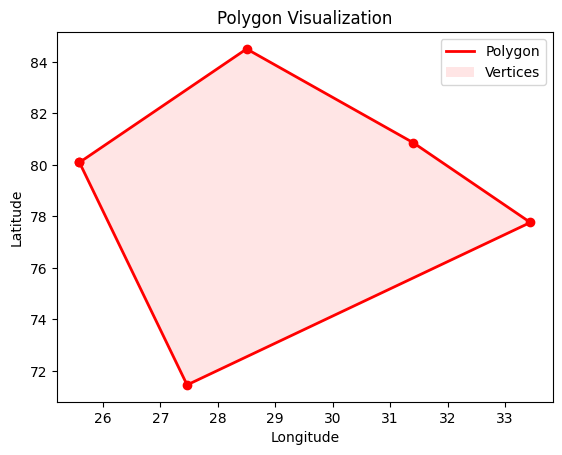

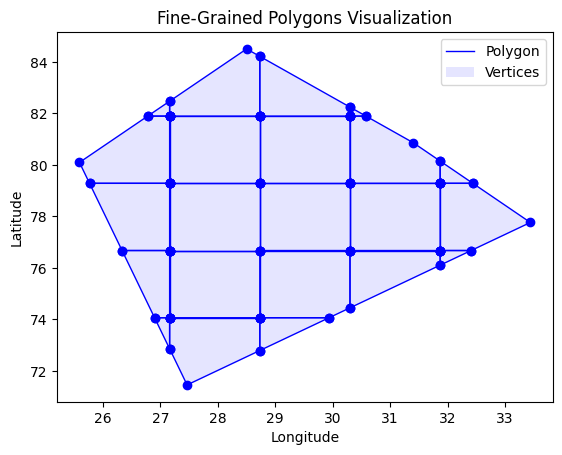

In [21]:
from MOESTKF_functions import Toy_generation, get_complete_stations, Feature_wise_Subgraph
import os
import numpy as np
import six.moves.cPickle as pickle
import torch
import torch.nn as nn
import torch.utils.data as data
import os
import pandas as pd
import torch
import random
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union
from scipy.stats import pearsonr
from scipy.spatial.distance import euclidean
##############################
#1. Input: Toy example generation #Can be replaced by other datasets here.
##############################
# Example usage

file_path = 'data/NDBC/all.npy'
station_value = np.load(file_path)
station_value = station_value.transpose(2, 0, 1)
station_value = station_value[:, :, 5:13]
station_value = torch.tensor(station_value)

lat_file_path = 'data/NDBC/Station_info_edit.csv'
station_info = pd.read_csv(lat_file_path, header=None).values  # Convert to NumPy array directly

station_value= torch.tensor(station_value)  # Assuming station_values is your tensor
print("station_value.shape:",station_value.shape)
complete_stations, complete_indices = get_complete_stations(station_info, station_value)
K = 5
subgraph_matrix = Feature_wise_Subgraph(station_info, station_value, complete_stations, complete_indices, K)#Subgraph Matrix: (16, 8)

# print("Feature-wise Subgraph Matrix:")
# print(subgraph_matrix.shape)#Feature-wise Subgraph Matrix: (16, 8)

# Initialize the new matrix with the desired shape
complete_sub_matrix = np.empty((subgraph_matrix.shape[0], subgraph_matrix.shape[1], 6), dtype=object)

# Fill the new matrix
for i, complete_station in enumerate(complete_stations):
    for j in range(subgraph_matrix.shape[1]):
        complete_sub_matrix[i, j] = np.insert(subgraph_matrix[i, j], 0, complete_station)

# Example output for verification
print("Complete_Sub_matrix.shape",complete_sub_matrix.shape)

import random
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import numpy as np
from shapely.ops import unary_union
from scipy.stats import pearsonr

# Convert station_info to a dictionary for easy lookup
station_coords = {row[0]: (float(row[1]), float(row[2])) for row in station_info}


def convex_hull(points):
    if len(points) < 3:
        return points  # Convex hull is not defined for fewer than 3 points
    hull = ConvexHull(points)
    return [points[vertex] for vertex in hull.vertices]


def create_polygon_matrix(complete_sub_matrix, station_coords):
    complete_sub_polygon = np.empty((complete_sub_matrix.shape[0], complete_sub_matrix.shape[1]), dtype=object)
    for i in range(complete_sub_matrix.shape[0]):
        for j in range(complete_sub_matrix.shape[1]):
            stations = complete_sub_matrix[i, j]
            coords = [station_coords[station] for station in stations if station in station_coords]
            if len(coords) > 2:
                hull_coords = convex_hull(coords)
                complete_sub_polygon[i, j] = Polygon(hull_coords)
            else:
                complete_sub_polygon[i, j] = Polygon(coords)
    return complete_sub_polygon


# Generate the Complete_Sub_polygon matrix
Complete_Sub_polygon = create_polygon_matrix(complete_sub_matrix, station_coords)

# Example usage: plot the first polygon in the matrix
polygon = Complete_Sub_polygon[0, 0]


def plot_polygon(polygon):
    fig, ax = plt.subplots()
    if polygon.is_valid:
        x, y = polygon.exterior.xy
        ax.plot(x, y, 'r-', lw=2)
        ax.fill(x, y, 'red', alpha=0.1)
        ax.scatter(x, y, color='red')

    ax.set_title('Polygon Visualization')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(['Polygon', 'Vertices'])
    plt.show()


# Plot the first polygon
plot_polygon(polygon)


def subdivide_polygon(polygon, num_subdivisions):
    minx, miny, maxx, maxy = polygon.bounds
    width = (maxx - minx) / num_subdivisions
    height = (maxy - miny) / num_subdivisions
    sub_polygons = []
    for i in range(num_subdivisions):
        for j in range(num_subdivisions):
            sub_poly = Polygon([
                (minx + i * width, miny + j * height),
                (minx + (i + 1) * width, miny + j * height),
                (minx + (i + 1) * width, miny + (j + 1) * height),
                (minx + i * width, miny + (j + 1) * height)
            ])
            if sub_poly.intersects(polygon):
                sub_polygons.append(sub_poly.intersection(polygon))
    return sub_polygons


def create_fine_grained_polygons(Complete_Sub_polygon, num_subdivisions):
    fine_grained_polygons = np.empty_like(Complete_Sub_polygon, dtype=object)
    for i in range(Complete_Sub_polygon.shape[0]):
        for j in range(Complete_Sub_polygon.shape[1]):
            coarse_polygon = Complete_Sub_polygon[i, j]
            if coarse_polygon.is_valid:
                fine_polygons = subdivide_polygon(coarse_polygon, num_subdivisions)
                fine_grained_polygons[i, j] = fine_polygons
    return fine_grained_polygons


# Generate the fine-grained polygons
num_subdivisions = 5  # Adjust this as needed for finer or coarser subdivisions
fine_grained_polygons = create_fine_grained_polygons(Complete_Sub_polygon, num_subdivisions)

# Example usage: plot the fine-grained polygons and display adjacency matrix for the first coarse polygon
fine_polygons = fine_grained_polygons[0, 0]


def plot_fine_polygons(fine_polygons):
    fig, ax = plt.subplots()
    for poly in fine_polygons:
        if poly.is_valid:
            x, y = poly.exterior.xy
            ax.plot(x, y, 'b-', lw=1)
            ax.fill(x, y, 'blue', alpha=0.1)
            ax.scatter(x, y, color='blue')

    ax.set_title('Fine-Grained Polygons Visualization')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(['Polygon', 'Vertices'])
    plt.show()


# Plot the fine-grained polygons
plot_fine_polygons(fine_polygons)


def generate_adj_matrix_for_polygons(fine_grained_polygons,K):#K represents the number of neighbors
    polygon_matrices = np.empty_like(fine_grained_polygons, dtype=object)
    for i in range(fine_grained_polygons.shape[0]):
        for j in range(fine_grained_polygons.shape[1]):
            fine_polygons = fine_grained_polygons[i, j]
            if fine_polygons:
                matrices = []
                for _ in fine_polygons:
                    matrix = np.random.rand(K+1+1, K+1+1)
                    np.fill_diagonal(matrix, 1)
                    matrix = (matrix + matrix.T) / 2  # Make the matrix symmetric
                    matrices.append(matrix)
                polygon_matrices[i, j] = matrices
    return polygon_matrices

def generate_rand_adj_matrix_for_polygons_(fine_grained_polygons,K):#K represents the number of neighbors
    polygon_matrices = np.empty_like(fine_grained_polygons, dtype=object)
    for i in range(fine_grained_polygons.shape[0]):
        for j in range(fine_grained_polygons.shape[1]):
            fine_polygons = fine_grained_polygons[i, j]
            if fine_polygons:
                matrices = []
                for _ in fine_polygons:
                    matrix = np.random.rand(K+1+1, K+1+1)
                    np.fill_diagonal(matrix, 1)
                    matrix = (matrix + matrix.T) / 2  # Make the matrix symmetric
                    matrices.append(matrix)
                polygon_matrices[i, j] = matrices
    return polygon_matrices



def plot_fine_polygons(fine_polygons):
    fig, ax = plt.subplots()
    for poly in fine_polygons:
        if poly.is_valid:
            x, y = poly.exterior.xy
            ax.plot(x, y, 'b-', lw=1)
            ax.fill(x, y, 'blue', alpha=0.1)
            ax.scatter(x, y, color='blue')

    ax.set_title('Fine-Grained Polygons Visualization')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(['Polygon', 'Vertices'])
    plt.show()

def get_centroid(polygon):
    centroid = polygon.centroid
    return (centroid.x, centroid.y)


def compute_weighted_correlation(station_value, coords, target_coords, den_fac, feature_index):
    correlations = []
    for coord in coords:
        distance = euclidean(coord, target_coords)
        weight = np.exp(-distance) ** den_fac
        correlation, _ = pearsonr(station_value, station_value)  # Using station_value correctly
        weighted_corr = correlation * weight
        correlations.append(weighted_corr)
    return correlations


station_indices_lookup = {str(station[0]).replace('Station_', ''): idx for idx, station in enumerate(station_info)}


# def create_adjacency_matrix_for_polygon(fine_grained_polygons, complete_sub_matrix, station_info, station_value, K):
#     fine_grained_polygon_adj = np.empty_like(fine_grained_polygons, dtype=object)
#
#     # Create a lookup for station indices
#     station_indices_lookup = {str(station[0]).replace('Station_', ''): idx for idx, station in enumerate(station_info)}
#
#     for i in range(fine_grained_polygons.shape[0]):
#         for j in range(fine_grained_polygons.shape[1]):
#             fine_polygons = fine_grained_polygons[i, j]
#             if not fine_polygons:
#                 continue  # Skip if no fine polygons
#
#             king_station = complete_sub_matrix[i, j][0]
#             target_station = complete_sub_matrix[i, j][-1]
#             station_indices = [station.replace('Station_', '') for station in complete_sub_matrix[i, j]]  # 处理字符串编号
#             print("station_indices", station_indices)
#             # if max(map(int, station_indices)) >= len(station_info):
#             if len(station_indices) >= len(station_info):
#                 print(f"Skipping invalid station index in sub-matrix: {station_indices}")
#                 continue
#
#             n = len(fine_polygons) - 1
#             A = fine_polygons[0].area if n > 0 else 1  # Avoid division by zero
#             den_fac = 1 / (2 * (n / A) ** 0.5)
#             #Get the center coordinates in each fine-grained polygons.
#             coords = [get_centroid(p) for p in fine_polygons]
#             print("coords", coords)
#             #Generate the adjacency matrix in the fine-grained polygons. The next code maybe wrong, don't need to +1
#             adjacency_matrix = np.zeros((len(coords) + 1, len(coords) + 1))  # Include space for target station
#
#             # #The next judge sentence might be not very useful. It's not make sense to me.
#             # if len(coords) != len(station_indices):
#             #     print(
#             #         f"Skipping due to mismatch in length: coords({len(coords)}) vs station_indices({len(station_indices)})")
#             #     continue
#
#             for m in range(len(coords)):
#                 for n in range(m + 1, len(coords)-1):
#                 # for n in range(len(coords)):
#                     # Convert station names to indices
#                     index_m = station_indices_lookup.get(station_indices[m])
#                     print("station_indices[m]",station_indices[m])
#                     print("index_m", index_m)
#                     index_n = station_indices_lookup.get(station_indices[n])
#                     print("station_indices[n]",station_indices[n])
#                     print("index_n", index_n)
#                     # if index_m is None or index_n is None:
#                     #     print(f"Skipping invalid index: {station_indices[m]} or {station_indices[n]}")
#                     #     continue
#
#                     # Calculate Pearson correlation for each feature across all time steps
#                     correlation, _ = pearsonr(station_value[index_m, :, j], station_value[index_n, :, j])
#                     adjacency_matrix[m, n] = correlation
#                     adjacency_matrix[n, m] = correlation
#
#             # Calculate weighted correlations for the target station
#             target_index = station_indices_lookup.get(str(target_station).replace('Station_', ''))
#             # if target_index is None:
#             #     print(f"Skipping invalid target index: {target_station}")
#             #     continue
#
#             target_weighted_correlations = compute_weighted_correlation(station_value[target_index, :, j], coords,
#                                                                         get_centroid(fine_polygons[-1]), den_fac, j)
#
#             for m in range(len(coords)):
#                 adjacency_matrix[m, -1] = target_weighted_correlations[m]
#                 adjacency_matrix[-1, m] = target_weighted_correlations[m]
#
#             fine_grained_polygon_adj[i, j] = adjacency_matrix
#
#     return fine_grained_polygon_adj


# Generate the adjacency matrices for fine-grained polygons
# polygon_matrices = create_adjacency_matrix_for_polygon(fine_grained_polygons, complete_sub_matrix, station_info,
#                                                        station_value,K)
# print("polygon_matrices[0,0][0]",polygon_matrices[0,0][0])

# polygon_matrices = generate_rand_adj_matrix_for_polygons_(fine_grained_polygons,K)
# print("polygon_matrices[0,0][0]",polygon_matrices[0,0][0])




def find_station_index_np(station_info, station_id):
    return np.where(station_info[:, 0] == station_id)[0][0]  # Using [0][0] to extract the first match's index



# import numpy as np
# import torch
# from scipy.stats import pearsonr
#
# def clean_data(series):
#     # Replace inf and -inf with NaN
#     series[torch.isinf(series)] = np.nan
#     # Impute NaNs, for example with the mean of the series; you might choose a different strategy
#     if torch.isnan(series).any():
#         mean_val = torch.nanmean(series).item()
#         series[torch.isnan(series)] = mean_val
#     return series
#
# def generate_try_adj_matrix_for_polygons(fine_grained_polygons, K, station_info, station_value):
#     num_polygons = fine_grained_polygons.shape[0]
#     num_sub_polygons = fine_grained_polygons.shape[1]
#     polygon_matrices = np.empty((num_polygons, num_sub_polygons), dtype=object)
#
#     for i in range(num_polygons):
#         for j in range(num_sub_polygons):
#             adjacency_matrix = np.zeros((K+1, K+1))
#
#             for l in range(K+1):
#                 for m in range(l + 1, K+1):
#                     index_l = np.where(station_info[:, 0] == complete_sub_matrix[i, j, l])[0][0]
#                     index_m = np.where(station_info[:, 0] == complete_sub_matrix[i, j, m])[0][0]
#
#                     data_series_l = station_value[index_l, :, :].reshape(-1)
#                     data_series_m = station_value[index_m, :, :].reshape(-1)
#
#                     # Clean the data
#                     data_series_l = clean_data(data_series_l)
#                     data_series_m = clean_data(data_series_m)
#
#                     # Compute the Pearson correlation
#                     if data_series_l.numel() > 1 and data_series_m.numel() > 1:
#                         correlation, _ = pearsonr(data_series_l.numpy(), data_series_m.numpy())
#                         adjacency_matrix[l, m] = correlation
#                         adjacency_matrix[m, l] = correlation
#             np.fill_diagonal(adjacency_matrix, 1)
#             polygon_matrices[i, j] = adjacency_matrix
#
#     return polygon_matrices
#
# # Example usage
# polygon_matrices = generate_try_adj_matrix_for_polygons(fine_grained_polygons, K, station_info, station_value)
#
# print(polygon_matrices.shape)

/tmp/ipykernel_166471/878951666.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  station_value= torch.tensor(station_value)  # Assuming station_values is your tensor


station_value.shape: torch.Size([103, 8784, 8])
Complete_Sub_matrix.shape (35, 8, 6)


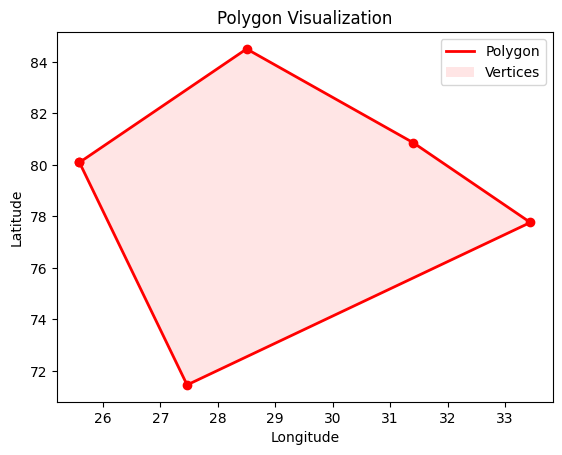

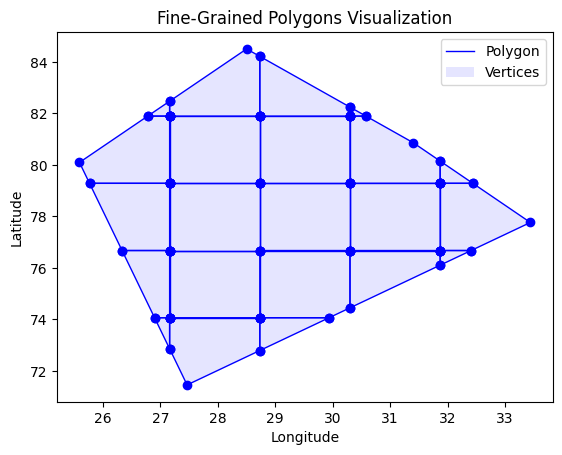

polygon_matrices[0,0][0] [[1.         0.52396587 0.40354786 0.31211338 0.3041555  0.28942888
  0.63954676]
 [0.52396587 1.         0.32757604 0.46199529 0.35184127 0.26601674
  0.48181743]
 [0.40354786 0.32757604 1.         0.14060828 0.30304809 0.49054627
  0.22244991]
 [0.31211338 0.46199529 0.14060828 1.         0.29583635 0.16326784
  0.50418004]
 [0.3041555  0.35184127 0.30304809 0.29583635 1.         0.25178827
  0.4040809 ]
 [0.28942888 0.26601674 0.49054627 0.16326784 0.25178827 1.
  0.53855369]
 [0.63954676 0.48181743 0.22244991 0.50418004 0.4040809  0.53855369
  1.        ]]


In [38]:
from MOESTKF_functions import Toy_generation, get_complete_stations, Feature_wise_Subgraph
import os
import numpy as np
import six.moves.cPickle as pickle
import torch
import torch.nn as nn
import torch.utils.data as data
import os
import pandas as pd
import torch
import random
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union
from scipy.stats import pearsonr
from scipy.spatial.distance import euclidean
##############################
#1. Input: Toy example generation #Can be replaced by other datasets here.
##############################
# Example usage

file_path = 'data/NDBC/all.npy'
station_value = np.load(file_path)
station_value = station_value.transpose(2, 0, 1)
station_value = station_value[:, :, 5:13]
station_value = torch.tensor(station_value)

lat_file_path = 'data/NDBC/Station_info_edit.csv'
station_info = pd.read_csv(lat_file_path, header=None).values  # Convert to NumPy array directly

station_value= torch.tensor(station_value)  # Assuming station_values is your tensor
print("station_value.shape:",station_value.shape)
complete_stations, complete_indices = get_complete_stations(station_info, station_value)
K = 5
subgraph_matrix = Feature_wise_Subgraph(station_info, station_value, complete_stations, complete_indices, K)#Subgraph Matrix: (16, 8)

# print("Feature-wise Subgraph Matrix:")
# print(subgraph_matrix.shape)#Feature-wise Subgraph Matrix: (16, 8)

# Initialize the new matrix with the desired shape
complete_sub_matrix = np.empty((subgraph_matrix.shape[0], subgraph_matrix.shape[1], 6), dtype=object)

# Fill the new matrix
for i, complete_station in enumerate(complete_stations):
    for j in range(subgraph_matrix.shape[1]):
        complete_sub_matrix[i, j] = np.insert(subgraph_matrix[i, j], 0, complete_station)

# Example output for verification
print("Complete_Sub_matrix.shape",complete_sub_matrix.shape)

import random
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import numpy as np
from shapely.ops import unary_union
from scipy.stats import pearsonr

# Convert station_info to a dictionary for easy lookup
station_coords = {row[0]: (float(row[1]), float(row[2])) for row in station_info}


def convex_hull(points):
    if len(points) < 3:
        return points  # Convex hull is not defined for fewer than 3 points
    hull = ConvexHull(points)
    return [points[vertex] for vertex in hull.vertices]


def create_polygon_matrix(complete_sub_matrix, station_coords):
    complete_sub_polygon = np.empty((complete_sub_matrix.shape[0], complete_sub_matrix.shape[1]), dtype=object)
    for i in range(complete_sub_matrix.shape[0]):
        for j in range(complete_sub_matrix.shape[1]):
            stations = complete_sub_matrix[i, j]
            coords = [station_coords[station] for station in stations if station in station_coords]
            if len(coords) > 2:
                hull_coords = convex_hull(coords)
                complete_sub_polygon[i, j] = Polygon(hull_coords)
            else:
                complete_sub_polygon[i, j] = Polygon(coords)
    return complete_sub_polygon


# Generate the Complete_Sub_polygon matrix
Complete_Sub_polygon = create_polygon_matrix(complete_sub_matrix, station_coords)

# Example usage: plot the first polygon in the matrix
polygon = Complete_Sub_polygon[0, 0]


def plot_polygon(polygon):
    fig, ax = plt.subplots()
    if polygon.is_valid:
        x, y = polygon.exterior.xy
        ax.plot(x, y, 'r-', lw=2)
        ax.fill(x, y, 'red', alpha=0.1)
        ax.scatter(x, y, color='red')

    ax.set_title('Polygon Visualization')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(['Polygon', 'Vertices'])
    plt.show()


# Plot the first polygon
plot_polygon(polygon)


def subdivide_polygon(polygon, num_subdivisions):
    minx, miny, maxx, maxy = polygon.bounds
    width = (maxx - minx) / num_subdivisions
    height = (maxy - miny) / num_subdivisions
    sub_polygons = []
    for i in range(num_subdivisions):
        for j in range(num_subdivisions):
            sub_poly = Polygon([
                (minx + i * width, miny + j * height),
                (minx + (i + 1) * width, miny + j * height),
                (minx + (i + 1) * width, miny + (j + 1) * height),
                (minx + i * width, miny + (j + 1) * height)
            ])
            if sub_poly.intersects(polygon):
                sub_polygons.append(sub_poly.intersection(polygon))
    return sub_polygons


def create_fine_grained_polygons(Complete_Sub_polygon, num_subdivisions):
    fine_grained_polygons = np.empty_like(Complete_Sub_polygon, dtype=object)
    for i in range(Complete_Sub_polygon.shape[0]):
        for j in range(Complete_Sub_polygon.shape[1]):
            coarse_polygon = Complete_Sub_polygon[i, j]
            if coarse_polygon.is_valid:
                fine_polygons = subdivide_polygon(coarse_polygon, num_subdivisions)
                fine_grained_polygons[i, j] = fine_polygons
    return fine_grained_polygons


# Generate the fine-grained polygons
num_subdivisions = 5  # Adjust this as needed for finer or coarser subdivisions
fine_grained_polygons = create_fine_grained_polygons(Complete_Sub_polygon, num_subdivisions)

# Example usage: plot the fine-grained polygons and display adjacency matrix for the first coarse polygon
fine_polygons = fine_grained_polygons[0, 0]


def plot_fine_polygons(fine_polygons):
    fig, ax = plt.subplots()
    for poly in fine_polygons:
        if poly.is_valid:
            x, y = poly.exterior.xy
            ax.plot(x, y, 'b-', lw=1)
            ax.fill(x, y, 'blue', alpha=0.1)
            ax.scatter(x, y, color='blue')

    ax.set_title('Fine-Grained Polygons Visualization')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(['Polygon', 'Vertices'])
    plt.show()


# Plot the fine-grained polygons
plot_fine_polygons(fine_polygons)


def generate_adj_matrix_for_polygons(fine_grained_polygons,K):#K represents the number of neighbors
    polygon_matrices = np.empty_like(fine_grained_polygons, dtype=object)
    for i in range(fine_grained_polygons.shape[0]):
        for j in range(fine_grained_polygons.shape[1]):
            fine_polygons = fine_grained_polygons[i, j]
            if fine_polygons:
                matrices = []
                for _ in fine_polygons:
                    matrix = np.random.rand(K+1+1, K+1+1)
                    np.fill_diagonal(matrix, 1)
                    matrix = (matrix + matrix.T) / 2  # Make the matrix symmetric
                    matrices.append(matrix)
                polygon_matrices[i, j] = matrices
    return polygon_matrices

def generate_rand_adj_matrix_for_polygons_(fine_grained_polygons,K):#K represents the number of neighbors
    polygon_matrices = np.empty_like(fine_grained_polygons, dtype=object)
    for i in range(fine_grained_polygons.shape[0]):
        for j in range(fine_grained_polygons.shape[1]):
            fine_polygons = fine_grained_polygons[i, j]
            if fine_polygons:
                matrices = []
                for _ in fine_polygons:
                    matrix = np.random.rand(K+1+1, K+1+1)
                    np.fill_diagonal(matrix, 1)
                    matrix = (matrix + matrix.T) / 2  # Make the matrix symmetric
                    matrices.append(matrix)
                polygon_matrices[i, j] = matrices
    return polygon_matrices



def plot_fine_polygons(fine_polygons):
    fig, ax = plt.subplots()
    for poly in fine_polygons:
        if poly.is_valid:
            x, y = poly.exterior.xy
            ax.plot(x, y, 'b-', lw=1)
            ax.fill(x, y, 'blue', alpha=0.1)
            ax.scatter(x, y, color='blue')

    ax.set_title('Fine-Grained Polygons Visualization')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(['Polygon', 'Vertices'])
    plt.show()

def get_centroid(polygon):
    centroid = polygon.centroid
    return (centroid.x, centroid.y)


def compute_weighted_correlation(station_value, coords, target_coords, den_fac, feature_index):
    correlations = []
    for coord in coords:
        distance = euclidean(coord, target_coords)
        weight = np.exp(-distance) ** den_fac
        correlation, _ = pearsonr(station_value, station_value)  # Using station_value correctly
        weighted_corr = correlation * weight
        correlations.append(weighted_corr)
    return correlations


station_indices_lookup = {str(station[0]).replace('Station_', ''): idx for idx, station in enumerate(station_info)}


# def create_adjacency_matrix_for_polygon(fine_grained_polygons, complete_sub_matrix, station_info, station_value, K):
#     fine_grained_polygon_adj = np.empty_like(fine_grained_polygons, dtype=object)
#
#     # Create a lookup for station indices
#     station_indices_lookup = {str(station[0]).replace('Station_', ''): idx for idx, station in enumerate(station_info)}
#
#     for i in range(fine_grained_polygons.shape[0]):
#         for j in range(fine_grained_polygons.shape[1]):
#             fine_polygons = fine_grained_polygons[i, j]
#             if not fine_polygons:
#                 continue  # Skip if no fine polygons
#
#             king_station = complete_sub_matrix[i, j][0]
#             target_station = complete_sub_matrix[i, j][-1]
#             station_indices = [station.replace('Station_', '') for station in complete_sub_matrix[i, j]]  # 处理字符串编号
#             print("station_indices", station_indices)
#             # if max(map(int, station_indices)) >= len(station_info):
#             if len(station_indices) >= len(station_info):
#                 print(f"Skipping invalid station index in sub-matrix: {station_indices}")
#                 continue
#
#             n = len(fine_polygons) - 1
#             A = fine_polygons[0].area if n > 0 else 1  # Avoid division by zero
#             den_fac = 1 / (2 * (n / A) ** 0.5)
#             #Get the center coordinates in each fine-grained polygons.
#             coords = [get_centroid(p) for p in fine_polygons]
#             print("coords", coords)
#             #Generate the adjacency matrix in the fine-grained polygons. The next code maybe wrong, don't need to +1
#             adjacency_matrix = np.zeros((len(coords) + 1, len(coords) + 1))  # Include space for target station
#
#             # #The next judge sentence might be not very useful. It's not make sense to me.
#             # if len(coords) != len(station_indices):
#             #     print(
#             #         f"Skipping due to mismatch in length: coords({len(coords)}) vs station_indices({len(station_indices)})")
#             #     continue
#
#             for m in range(len(coords)):
#                 for n in range(m + 1, len(coords)-1):
#                 # for n in range(len(coords)):
#                     # Convert station names to indices
#                     index_m = station_indices_lookup.get(station_indices[m])
#                     print("station_indices[m]",station_indices[m])
#                     print("index_m", index_m)
#                     index_n = station_indices_lookup.get(station_indices[n])
#                     print("station_indices[n]",station_indices[n])
#                     print("index_n", index_n)
#                     # if index_m is None or index_n is None:
#                     #     print(f"Skipping invalid index: {station_indices[m]} or {station_indices[n]}")
#                     #     continue
#
#                     # Calculate Pearson correlation for each feature across all time steps
#                     correlation, _ = pearsonr(station_value[index_m, :, j], station_value[index_n, :, j])
#                     adjacency_matrix[m, n] = correlation
#                     adjacency_matrix[n, m] = correlation
#
#             # Calculate weighted correlations for the target station
#             target_index = station_indices_lookup.get(str(target_station).replace('Station_', ''))
#             # if target_index is None:
#             #     print(f"Skipping invalid target index: {target_station}")
#             #     continue
#
#             target_weighted_correlations = compute_weighted_correlation(station_value[target_index, :, j], coords,
#                                                                         get_centroid(fine_polygons[-1]), den_fac, j)
#
#             for m in range(len(coords)):
#                 adjacency_matrix[m, -1] = target_weighted_correlations[m]
#                 adjacency_matrix[-1, m] = target_weighted_correlations[m]
#
#             fine_grained_polygon_adj[i, j] = adjacency_matrix
#
#     return fine_grained_polygon_adj


# Generate the adjacency matrices for fine-grained polygons
# polygon_matrices = create_adjacency_matrix_for_polygon(fine_grained_polygons, complete_sub_matrix, station_info,
#                                                        station_value,K)
# print("polygon_matrices[0,0][0]",polygon_matrices[0,0][0])

# polygon_matrices = generate_rand_adj_matrix_for_polygons_(fine_grained_polygons,K)
# print("polygon_matrices[0,0][0]",polygon_matrices[0,0][0])




def find_station_index_np(station_info, station_id):
    return np.where(station_info[:, 0] == station_id)[0][0]  # Using [0][0] to extract the first match's index

def generate_try_adj_matrix_for_polygons(fine_grained_polygons,K,station_info,station_value):#K represents the number of neighbors
#def generate_try_adj_matrix_for_polygons(fine_grained_polygons,K,station_info,station_value, lambda):#K represents the number of neighbors
    polygon_matrices = np.empty_like(fine_grained_polygons, dtype=object)
    for i in range(fine_grained_polygons.shape[0]):
        for j in range(fine_grained_polygons.shape[1]):
            fine_polygons = fine_grained_polygons[i, j]
            if fine_polygons:
                matrices = []
                for _ in fine_polygons:
                    matrix = np.random.rand(K+1+1, K+1+1)
                    np.fill_diagonal(matrix, 1)
                    matrix = (matrix + matrix.T) / 2  # Make the matrix symmetric
                    matrices.append(matrix)
                polygon_matrices[i, j] = matrices
    #Loop for all elements except for the unknown potential stations.
    for i in range(polygon_matrices.shape[0]-1):
        for j in range(polygon_matrices.shape[1]-1):
            for k in range (len(polygon_matrices[i, j])):
                for l in range (K+1):
                    for m in range(K+1):
                        polygon_matrices[i, j][k][l,m],_=pearsonr(station_value[np.where(station_info[:, 0] == complete_sub_matrix[i,j,l])[0][0],:,j],station_value[np.where(station_info[:, 0] == complete_sub_matrix[i,j,m])[0][0],:,j])
    return polygon_matrices


polygon_matrices = generate_try_adj_matrix_for_polygons(fine_grained_polygons,K,station_info,station_value)
print("polygon_matrices[0,0][0]",polygon_matrices[0,0][0])




# import numpy as np
# import torch
# from scipy.stats import pearsonr
#
# def clean_data(series):
#     # Replace inf and -inf with NaN
#     series[torch.isinf(series)] = np.nan
#     # Impute NaNs, for example with the mean of the series; you might choose a different strategy
#     if torch.isnan(series).any():
#         mean_val = torch.nanmean(series).item()
#         series[torch.isnan(series)] = mean_val
#     return series
#
# def generate_try_adj_matrix_for_polygons(fine_grained_polygons, K, station_info, station_value):
#     num_polygons = fine_grained_polygons.shape[0]
#     num_sub_polygons = fine_grained_polygons.shape[1]
#     polygon_matrices = np.empty((num_polygons, num_sub_polygons), dtype=object)
#
#     for i in range(num_polygons):
#         for j in range(num_sub_polygons):
#             adjacency_matrix = np.zeros((K+1, K+1))
#
#             for l in range(K+1):
#                 for m in range(l + 1, K+1):
#                     index_l = np.where(station_info[:, 0] == complete_sub_matrix[i, j, l])[0][0]
#                     index_m = np.where(station_info[:, 0] == complete_sub_matrix[i, j, m])[0][0]
#
#                     data_series_l = station_value[index_l, :, :].reshape(-1)
#                     data_series_m = station_value[index_m, :, :].reshape(-1)
#
#                     # Clean the data
#                     data_series_l = clean_data(data_series_l)
#                     data_series_m = clean_data(data_series_m)
#
#                     # Compute the Pearson correlation
#                     if data_series_l.numel() > 1 and data_series_m.numel() > 1:
#                         correlation, _ = pearsonr(data_series_l.numpy(), data_series_m.numpy())
#                         adjacency_matrix[l, m] = correlation
#                         adjacency_matrix[m, l] = correlation
#             np.fill_diagonal(adjacency_matrix, 1)
#             polygon_matrices[i, j] = adjacency_matrix
#
#     return polygon_matrices
#
# # Example usage
# polygon_matrices = generate_try_adj_matrix_for_polygons(fine_grained_polygons, K, station_info, station_value)
#
# print(polygon_matrices.shape)

Shape of the new matrices: (7, 7)


In [34]:
i=0
j=0
k=0
l=0
m=0
polygon_matrices = np.empty_like(fine_grained_polygons, dtype=object)
a,_=pearsonr(station_value[np.where(station_info[:, 0] == complete_sub_matrix[i,j,l])[0][0],:,j],station_value[np.where(station_info[:, 0] == complete_sub_matrix[i,j,m+1])[0][0],:,j])